In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.cluster import KMeans
from scipy import stats as st
from statistics import multimode



/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

Possibilities: 
- MPFC 2 tr after nacc and ains.

- Also, calculate slope between tr_1 and tr_2 that crosses a 1 std. 
- Get the highest correlation for comedy, see when TR happens. 
- What to do if there's more than one peak (i.e., if there's more than two points higher than std)?

- Code to get Arousal, Feel, and Watch z-score signal for each roi. 
- Get peaks ids from Like-Horror and Like-Comedy sub-groups. Compare these peaks with Yes-Horror and Yes-Comedy.
- Update extended peaks labels for AIns and MPFC.


- Spill over effects from previous trailer. 
- Why we get a negative nacc activation for aggregate? Highest variance from individual choice...
- Get peaks based on sub-groups comedy-horror. 






# Homemade functions

In [3]:

def get_dem_peak_ROI(all_participants_dic, all_participants_events_dic, sub_id, ROI_id, trailer_id, dem_id, tail):

    # Identy to which run the trailer belongs to.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']

    run_id = ''    

    if(trailer_id in r1_keys):
        run_id = '_r1'
    elif(trailer_id in r2_keys):
        run_id = '_r2'
    else:
        print("Trailer_id not found in any run: " + str(trailer_id))

    # Define roi labels
    if(ROI_id == 'NAcc'):
        ROI_key = 'Bilateral_NAcc' + run_id
    elif(ROI_id == 'AIns'):
        ROI_key = 'Bilateral_AIns' + run_id
    elif(ROI_id == 'MPFC'):
        ROI_key = 'Bilateral_MPFC' + run_id
    else:
        print("Incorrect ROI_id. Please use 'NAcc', 'AIns' or 'MPFC'.")

    # Get the timecourse of the ROI.
    timecourse = all_participants_dic[sub_id][ROI_key]
    time_length = len(timecourse)*2

    # Get onset for trailer.
    onset = all_participants_events_dic[sub_id].loc[all_participants_events_dic[sub_id]["Trailer"] == trailer_id]["Onset"].values[0]

    # Re-scale.
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, time_length, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, time_length, 2)  

    # Interpolate timecourse.
    trailer_onset = np.zeros(time_length)

    # Add add 4 sec from hemodynamic lag to onset.
    onset = onset + 4 

    # Get the onset in seconds.
    trailer_onset[int(onset)] = 1

    # Interpolate the timecourse.
    run_resampler = interp1d(time_scale, trailer_onset)
    run_trailer_vol_onset = run_resampler(vol_scale)

    # Get the peak of the timecourse.
    actual_onset = np.where(run_trailer_vol_onset == 1)[0][0]

    # Get peak location on raw timecourse.
    peak_id = int(actual_onset + int(dem_id))

    # Get the peak value.
    tail = int(tail)
    dem_peak = timecourse[peak_id:peak_id + tail]
    dem_peak = np.mean(dem_peak)

    return dem_peak

def get_avg_dem_peak(timecourse, peak_id):

    # Make sure peak id is an int value.
    try:
        peak_id = int(peak_id)
    except TypeError:
        print('We have two peaks here: ' + str(peak_id))
        peak_id = int(peak_id[0])

    peak_id = int(peak_id)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])    
    return peak

def get_avg_dem_peak2(timecourse, peak_id):

    # Make sure peak id is an int value.
    try:
        peak_id = int(peak_id)
    except TypeError:
        print('We have two peaks here: ' + str(peak_id))
        peak_id = int(peak_id[0])

    peak_id = int(peak_id)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id-1:peak_id])
        #peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id-1:peak_id+1])    
    return peak


In [4]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [5]:
def get_avg_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id-1:peak_id])
    else:
        peak = np.mean(timecourse[peak_id-1:peak_id+1])
    
    return peak

In [6]:
def get_individual_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # If    
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])
    
    return peak_id, peak


  

In [7]:
# Functions to get different peaks (slope and deltas).
#participant_dictionaries_raw

# get_dem_peak_slope(participant_dictionaries_raw, participants_events, sub_id, ROI_id, trailer_id, dem_id):

def get_dem_peak_slope(all_participants_dic, all_participants_events_dic, sub_id, ROI_id, trailer_id, dem_id):

    # Identy to which run the trailer belongs to.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']

    run_id = ''    

    if(trailer_id in r1_keys):
        run_id = '_r1'
    elif(trailer_id in r2_keys):
        run_id = '_r2'
    else:
        print("Trailer_id not found in any run: " + str(trailer_id))

    # Define roi labels
    if(ROI_id == 'NAcc'):
        ROI_key = 'Bilateral_NAcc' + run_id
    elif(ROI_id == 'AIns'):
        ROI_key = 'Bilateral_AIns' + run_id
    elif(ROI_id == 'MPFC'):
        ROI_key = 'Bilateral_MPFC' + run_id
    else:
        print("Incorrect ROI_id. Please use 'NAcc', 'AIns' or 'MPFC'.")

    # Get the timecourse of the ROI.
    timecourse = all_participants_dic[sub_id][ROI_key]
    time_length = len(timecourse)*2

    # Get onset for trailer.
    onset = all_participants_events_dic[sub_id].loc[all_participants_events_dic[sub_id]["Trailer"] == trailer_id]["Onset"].values[0]

    # Re-scale.
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, time_length, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, time_length, 2)  

    # Interpolate timecourse.
    trailer_onset = np.zeros(time_length)

    # Add add 4 sec from hemodynamic lag to onset.
    onset = onset + 4 

    # Get the onset in seconds.
    trailer_onset[int(onset)] = 1

    # Interpolate the timecourse.
    run_resampler = interp1d(time_scale, trailer_onset)
    run_trailer_vol_onset = run_resampler(vol_scale)

    # Get the peak of the timecourse.
    actual_onset = np.where(run_trailer_vol_onset == 1)[0][0]

    # Get peak location on raw timecourse.
    peak_id = int(actual_onset + int(dem_id))

    # Calculate slope. 
    #try:
    peak_slope = timecourse[peak_id] - timecourse[peak_id - 1]
    #except IndexError:
    #    print("IndexError: " + str(sub_id) + " " + str(ROI_key) + " " + str(trailer_id) + " " + str(dem_id) + " " + str(peak_id))

    return peak_slope
    


def get_peak_slope(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope

def get_narrow_peak_slope(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope
    
def get_peak_delta(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
    
def get_narrow_peak_delta(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
     


In [8]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [9]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [10]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [11]:
# watch -> valence -> arousal
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12 

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix 
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer offser. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    #mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    #mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    mean_centered_arousal = proccesed_events_df["A_score"] - proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"] - proccesed_events_df["F_score"].mean()

    proccesed_events_df["A_score_scaled"] = proccesed_events_df["A_score"] - proccesed_events_df["A_score"].mean()
    proccesed_events_df["F_score_scaled"] = proccesed_events_df["F_score"]- proccesed_events_df["F_score"].mean()

    # Derive the mean centered and negative arousal scores.

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    pos_arousal_std = np.std(proccesed_events_df["Pos_arousal"], axis=0, ddof=1)
    neg_arousal_std = np.std(proccesed_events_df["Neg_arousal"], axis=0, ddof=1)

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    watch_score_std = np.std(proccesed_events_df["W_score"], axis=0, ddof=1)
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [12]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])

        # Re-size arrays from batch 2 so they match the size of the arrays from batch 1.
        # Only cutting out the last 2 timepoints.
        if(roi_data.size > 378):
            roi_data = roi_data[:378]

        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass

def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"
    rROI = "Right_" + ROI
    rROI_r1 = "Right_" + ROI + "_r1"
    rROI_r2 = "Right_" + ROI + "_r2"
    lROI = "Left_" + ROI
    lROI_r1 = "Left_" + ROI + "_r1"
    lROI_r2 = "Left_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            values_Right_ROI_array = np.array(values_Right_ROI).T
            values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant],
                                                                                       lROI: values_Left_ROI_array[:, current_participant], 
                                                                                       rROI: values_Right_ROI_array[:, current_participant]}
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)
                label_left = np.repeat(lROI, 15)
                label_right = np.repeat(rROI, 15)
                roi_labels = [label_bi, label_left, label_right]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_left = values_Left_ROI_array[:, current_participant]
                current_participant_right = values_Right_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

                for x in range(3):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI, lROI: averageLeft_ROI, rROI: averageRight_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]
    Right_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r1) for sub_id in subjects_list]
    Right_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r2) for sub_id in subjects_list]
    Left_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r1) for sub_id in subjects_list]
    Left_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r2) for sub_id in subjects_list]    

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]
    Right_ROI_raw_r1_list = [x for x in Right_ROI_raw_r1_list if x is not None]
    Right_ROI_raw_r2_list = [x for x in Right_ROI_raw_r2_list if x is not None]
    Left_ROI_raw_r1_list = [x for x in Left_ROI_raw_r1_list if x is not None]
    Left_ROI_raw_r2_list = [x for x in Left_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)
    Right_ROI_raw_r1_average = np.mean(Right_ROI_raw_r1_list, axis=0)
    Right_ROI_raw_r2_average = np.mean(Right_ROI_raw_r2_list, axis=0)
    Left_ROI_raw_r1_average = np.mean(Left_ROI_raw_r1_list, axis=0)
    Left_ROI_raw_r2_average = np.mean(Left_ROI_raw_r2_list, axis=0)

    # Create TR array.
    TRs_raw = np.arange(0, 378, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average, Right_ROI_raw_r1_average, Right_ROI_raw_r2_average, Left_ROI_raw_r1_average, Left_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2, rROI_r1, rROI_r2, lROI_r1, lROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(6):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)

        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


In [13]:
# Taken from: https://bioimagesuiteweb.github.io/webapp/mni2tal.html
# Note, I am not transforming the coordinates, instead I am using the MNI coordinates 
# that the site suggests correspond to each region.
# mni_coords = {
#     "NAcc_RL": [(10, 10, -12), (-11, 9, -11)],
#     "MPFC_RL": [(12, 37, -19), (-11, 38, -18)],
#     "AIns_RL": [(36, 18, -4), (-36, 18, 4)], # Not sure about this one.
# }

# Taken from (Genevsky et al., 2017). -> NAcc, MPFC, AIns. 
# tal_coords = {
#     "NAcc_RL": [(10, 12, -2), (-10, 12, -2)], # Nucleus accumbes (NAcc) right, left
#     "MPFC_RL": [(4, 45, 0), (-4, 45, 0)], # Medial prefrontal cortex (MPFC) right, left
#     "AIns_RL": [(34, 24, -4), (-34, 24, -4)] # Anterior Insula right, left
# }

In [14]:

def getROIs_timecourse(participant_num, sub_motion): 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    sub_run1_confounds_meta_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.json"
    sub_run2_confounds_meta_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.json"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run1_watch_onsets_dic = {}
    run1_feel_onsets_dic = {}
    run1_arousal_onsets_dic = {}
    run2_onsets = {}
    run2_watch_onsets_dic = {}
    run2_feel_onsets_dic = {}
    run2_arousal_onsets_dic = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)
        run1_watch_onsets = np.zeros(n_timepoints)
        run2_watch_onsets = np.zeros(n_timepoints)
        run1_feel_onsets = np.zeros(n_timepoints)
        run2_feel_onsets = np.zeros(n_timepoints)
        run1_arousal_onsets = np.zeros(n_timepoints)
        run2_arousal_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id] 
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id] 
        # Add 30 sec for trailer duration.
        # Add 4 sec for watch question duration.
        # Add 4 sec for feel question duration.
        run1_current_trailer_w_onset = sub_run1_p_events["Onset"][id] + 30
        run2_current_trailer_w_onset = sub_run2_p_events["Onset"][id] + 30
        run1_current_trailer_f_onset = sub_run1_p_events["Onset"][id] + 30 + 4
        run2_current_trailer_f_onset = sub_run2_p_events["Onset"][id] + 30 + 4
        run1_current_trailer_a_onset = sub_run1_p_events["Onset"][id] + 30 + 4 + 4
        run2_current_trailer_a_onset = sub_run2_p_events["Onset"][id] + 30 + 4 + 4

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        HMD_lag = 4
        run1_trailer_onsets[int(run1_current_trailer_onset + HMD_lag):int(run1_current_trailer_onset)+ 30 + HMD_lag] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + HMD_lag):int(run2_current_trailer_onset)+ 30 + HMD_lag] = 1
        run1_watch_onsets[int(run1_current_trailer_w_onset + HMD_lag):int(run1_current_trailer_w_onset)+ 4 + HMD_lag] = 1
        run2_watch_onsets[int(run2_current_trailer_w_onset + HMD_lag):int(run2_current_trailer_w_onset)+ 4 + HMD_lag] = 1
        run1_feel_onsets[int(run1_current_trailer_f_onset + HMD_lag):int(run1_current_trailer_f_onset)+ 4 + HMD_lag] = 1
        run2_feel_onsets[int(run2_current_trailer_f_onset + HMD_lag):int(run2_current_trailer_f_onset)+ 4 + HMD_lag] = 1
        run1_arousal_onsets[int(run1_current_trailer_a_onset + HMD_lag):int(run1_current_trailer_a_onset)+ 4 + HMD_lag] = 1
        run2_arousal_onsets[int(run2_current_trailer_a_onset + HMD_lag):int(run2_current_trailer_a_onset)+ 4 + HMD_lag] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)
        run1_w_resampler = interp1d(time_scale, run1_watch_onsets)
        run2_w_resampler = interp1d(time_scale, run2_watch_onsets)
        run1_f_resampler = interp1d(time_scale, run1_feel_onsets)
        run2_f_resampler = interp1d(time_scale, run2_feel_onsets)
        run1_a_resampler = interp1d(time_scale, run1_arousal_onsets)
        run2_a_resampler = interp1d(time_scale, run2_arousal_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)
        run1_watch_vol_onsets = run1_w_resampler(vol_scale)
        run2_watch_vol_onsets = run2_w_resampler(vol_scale)
        run1_feel_vol_onsets = run1_f_resampler(vol_scale)
        run2_feel_vol_onsets = run2_f_resampler(vol_scale)
        run1_arousal_vol_onsets = run1_a_resampler(vol_scale)
        run2_arousal_vol_onsets = run2_a_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets
        run1_watch_onsets_dic[run1_trailer_labels[id]] = run1_watch_vol_onsets
        run2_watch_onsets_dic[run2_trailer_labels[id]] = run2_watch_vol_onsets
        run1_feel_onsets_dic[run1_trailer_labels[id]] = run1_feel_vol_onsets
        run2_feel_onsets_dic[run2_trailer_labels[id]] = run2_feel_vol_onsets
        run1_arousal_onsets_dic[run1_trailer_labels[id]] = run1_arousal_vol_onsets
        run2_arousal_onsets_dic[run2_trailer_labels[id]] = run2_arousal_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor", 
                         #"rot_x", "rot_y", "rot_z", "trans_x", "trans_y", "trans_z"
                         #'c_comp_cor_00', 'c_comp_cor_01', 'c_comp_cor_02', 'c_comp_cor_03', 'c_comp_cor_04'

                         'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04', # comment out just for testing
                         
                         ] 
                        #'cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06',
                        #'cosine07', 'cosine08', 'cosine09', "t_comp_cor_00"]
                        #'c_comp_cor_00','c_comp_cor_01'
                        #'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04',
                        #"edge_comp_00", "edge_comp_01", "edge_comp_02", "edge_comp_03", "edge_comp_04",
                        #"a_comp_cor_00", "a_comp_cor_01", "a_comp_cor_02", "a_comp_cor_03", "a_comp_cor_04",
                        #'trans_x_derivative1', 'trans_y_derivative1','trans_z_derivative1',
                        #'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                        #'trans_x_power2','trans_y_power2','trans_z_power2',
                        #'rot_x_power2','rot_y_power2','rot_z_power2'
                        

    # Get motion parameters.
    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] 
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_wcompcor_confounds = [i for i in sub_run1_confounds_df.columns if "w_comp_cor" in i]
    sub_run2_wcompcor_confounds = [i for i in sub_run2_confounds_df.columns if "w_comp_cor" in i]

    #sub_run1_motion_t_comp_cor_confounds = [i for i in sub_run1_confounds_df.columns if "t_comp_cor" in i] 
    #sub_run2_motion_t_comp_cor_confounds = [i for i in sub_run2_confounds_df.columns if "t_comp_cor" in i] 

    # Get physiological noise confounds.
    #sub_run1_confounds_meta_df = pd.read_json(sub_run1_confounds_meta_path, orient='index')
    #sub_run2_confounds_meta_df = pd.read_json(sub_run2_confounds_meta_path, orient='index')

    # Get the compcor confounds.
    #sub_run1_csf_compcor = sub_run1_confounds_meta_df[(sub_run1_confounds_meta_df["Method"] == "aCompCor") & (sub_run1_confounds_meta_df["Mask"] == "CSF") & (sub_run1_confounds_meta_df["CumulativeVarianceExplained"] < .36)].index.to_list()
    #sub_run1_wm_compcor = sub_run1_confounds_meta_df[(sub_run1_confounds_meta_df["Method"] == "aCompCor") & (sub_run1_confounds_meta_df["Mask"] == "WhiteMatter") & (sub_run1_confounds_meta_df["CumulativeVarianceExplained"] < .09)].index.to_list()

    #sub_run2_csf_compcor = sub_run2_confounds_meta_df[(sub_run2_confounds_meta_df["Method"] == "aCompCor") & (sub_run2_confounds_meta_df["Mask"] == "CSF") & (sub_run2_confounds_meta_df["CumulativeVarianceExplained"] < .36)].index.to_list()
    #sub_run2_wm_compcor = sub_run2_confounds_meta_df[(sub_run2_confounds_meta_df["Method"] == "aCompCor") & (sub_run2_confounds_meta_df["Mask"] == "WhiteMatter") & (sub_run2_confounds_meta_df["CumulativeVarianceExplained"] < .09)].index.to_list()

    # + sub_run1_motion_s_confounds
    # + sub_run2_motion_s_confounds
    sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds + sub_run1_motion_s_confounds] #+ sub_run1_wcompcor_confounds[:5] #+ sub_run1_motion_t_comp_cor_confounds]
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds + sub_run2_motion_s_confounds] #+ sub_run2_wcompcor_confounds[:5] #+ sub_run2_motion_t_comp_cor_confounds]

    #sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds] #+ sub_run1_wcompcor_confounds[:5] #+ sub_run1_motion_t_comp_cor_confounds]
    #sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds]

    # Test aggressive denoising
    # Best option
    #sub_run1_filtered_confounds_df, _ = load_confounds(sub_run1_func_path, strategy=["motion", "wm_csf", "compcor", "high_pass", "non_steady_state"], 
    #                                                motion="basic", wm_csf="basic", compcor="temporal_anat_separated", n_compcor=5,
    #                                                demean=False)
    #sub_run2_filtered_confounds_df, _ = load_confounds(sub_run2_func_path, strategy=["motion", "wm_csf", "compcor", "high_pass", "non_steady_state"],
    #                                                 motion="basic", wm_csf="basic", compcor="temporal_anat_separated", n_compcor=5, 
    #                                                 demean=False)
    
    # Testing
    # sub_run1_filtered_confounds_df, _ = load_confounds(sub_run1_func_path, strategy=["motion", "wm_csf", "compcor", "high_pass", "scrub"], 
    #                                                motion="basic", wm_csf="basic", compcor="temporal_anat_separated", n_compcor=5,
    #                                                fd_threshold=0.2, std_dvars_threshold=1.15, scrub=5, demean=False)
    # sub_run2_filtered_confounds_df, _ = load_confounds(sub_run2_func_path, strategy=["motion", "wm_csf", "compcor", "high_pass", "scrub"],
    #                                                 motion="basic", wm_csf="basic", compcor="temporal_anat_separated", n_compcor=5, 
    #                                                 fd_threshold=0.2, std_dvars_threshold=1.15, scrub=5, demean=False)

    # Change NaNs to 0s. 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0) 
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0) 

    # Get high variance confounds.
    high_var_confounds_run1 = pd.DataFrame(high_variance_confounds(sub_run1_func_path, percentile=2.5)) #detrend=False)) # add detrend=False
    high_var_confounds_run2 = pd.DataFrame(high_variance_confounds(sub_run2_func_path, percentile=2.5)) #detrend=False))

    # Combine with high variance confounds.
    sub_run1_filtered_confounds_df = pd.concat([sub_run1_filtered_confounds_df, high_var_confounds_run1], axis=1)
    sub_run2_filtered_confounds_df = pd.concat([sub_run2_filtered_confounds_df, high_var_confounds_run2], axis=1)
    sub_run1_filtered_confounds_df.reset_index(drop=True, inplace=True)
    sub_run2_filtered_confounds_df.reset_index(drop=True, inplace=True)

    # Declare parameters for Sphere Masker objects. 
    detrend = False
    standardize = "psc"
    standardize_confounds = "psc" 
    sphere_radius = 8 # from 6 to 8
    confounds1 = sub_run1_filtered_confounds_df
    confounds2 = sub_run2_filtered_confounds_df
    smoothing= 4 # from 6 to 4
    set_of_seeds = [(10, 12, -2), (-10, 12, -2), # Nucleus accumbes (NAcc) right, left
                (34, 24, -4), (-34, 24, -4), # Anterior Insula right (AIns), left
                (4, 45, 0), (-4, 45, 0), # Medial Prefrontal Cortex (MPFC) right, left
                (8, -76, 10), (-8, -76, 10)] # Visual cortex right, left
    
    set_of_seeds_mni = [(10, 9, -10), (-10, 9, -10), # Nucleus accumbes (NAcc) right, left
                (35, 18, 1), (-35, 18, 1), # Anterior Insula right (AIns), left
                (6, 49, -8), (-6, 49, -8), # Medial Prefrontal Cortex (MPFC) right, left
                (8, -76, 10), (-8, -76, 10)] # Visual cortex right, left
   
  
    ## 4) Apply mask to func data. 
    masker_AIM_ROI_r1 = NiftiSpheresMasker(
        seeds=set_of_seeds,
        allow_overlap=True,
        smoothing_fwhm=smoothing, 
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_variance_confounds=False,
        high_pass=1/360, # High cutoff frequency in Hertz. 
        )

    masker_AIM_ROI_r2 = NiftiSpheresMasker(
        seeds=set_of_seeds,
        allow_overlap=True,
        smoothing_fwhm=smoothing, 
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_variance_confounds=False,
        high_pass=1/360, # High cutoff frequency in Hertz.
        )

    ROI_raw_timecourses = {}
    ROI_raw_timecourses_zscored = {}
    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    ## Add if statement to only apply the masker if the run has acceptable motion parameters. 

    if((sub_motion[0] < 2) and (sub_motion[1] < 2)):

        # Apply function to get the percent signal change from each ROI timecourse. 
        sub_r1_AIM_ROI = masker_AIM_ROI_r1.fit_transform(sub_run1_func_path, confounds=confounds1)
        sub_r1_AIM_ROI_zscored = zscore(sub_r1_AIM_ROI, axis=1, nan_policy='omit')

        ## 5) Get the timecourses from each movie trailer. 
        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run1_timeseries = {}
        run1_timeseries_zcored = {}
        
        # Get the trailers presented in each run. 
        r1_keys = list(run1_onsets.keys())

        # Loop through each trailer and get its corresponding ROI timecourse
        for id in range(len(r1_keys)):

            run1_timeseries[r1_keys[id]] = {
                "Bilateral_NAcc": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Right_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                "Right_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                "Right_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4], 
                "Bilateral_NAcc_watch": np.mean(sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Bilateral_AIns_watch": np.mean(sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Bilateral_MPFC_watch": np.mean(sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Bilateral_NAcc_feel": np.mean(sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Bilateral_AIns_feel": np.mean(sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Bilateral_MPFC_feel": np.mean(sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Bilateral_NAcc_arousal": np.mean(sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Bilateral_AIns_arousal": np.mean(sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Bilateral_MPFC_arousal": np.mean(sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 4:6], axis=1)}
            
            run1_timeseries_zcored[r1_keys[id]] = {
                "Bilateral_NAcc_zscored": np.mean(sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Right_NAcc_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": np.mean(sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                "Right_AIns_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC_zscored": np.mean(sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                "Right_MPFC_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 4]}
        
        # This code gives me the un-trimmed timecourses for each ROI. 
        ROI_raw_timecourses["Bilateral_NAcc_r1"] = np.mean(sub_r1_AIM_ROI[:, 0:2], axis=1)
        ROI_raw_timecourses["Left_NAcc_r1"] = sub_r1_AIM_ROI[:, 1]
        ROI_raw_timecourses["Right_NAcc_r1"] = sub_r1_AIM_ROI[:, 0]
        ROI_raw_timecourses["Bilateral_AIns_r1"] = np.mean(sub_r1_AIM_ROI[:, 2:4], axis=1)
        ROI_raw_timecourses["Left_AIns_r1"] = sub_r1_AIM_ROI[:, 3]
        ROI_raw_timecourses["Right_AIns_r1"] = sub_r1_AIM_ROI[:, 2]
        ROI_raw_timecourses["Bilateral_MPFC_r1"] = np.mean(sub_r1_AIM_ROI[:, 4:6], axis=1)
        ROI_raw_timecourses["Left_MPFC_r1"] = sub_r1_AIM_ROI[:, 5]
        ROI_raw_timecourses["Right_MPFC_r1"] = sub_r1_AIM_ROI[:, 4]
        ROI_raw_timecourses["Bilateral_V1_r1"] = np.mean(sub_r1_AIM_ROI[:, 6:8], axis=1)
        ROI_raw_timecourses["Left_V1_r1"] = sub_r1_AIM_ROI[:, 6]
        ROI_raw_timecourses["Right_V1_r1"] = sub_r1_AIM_ROI[:, 7]

        # Get the same un-trimmed timecourses but z-scored.
        ROI_raw_timecourses_zscored["Bilateral_NAcc_r1"] = np.mean(sub_r1_AIM_ROI_zscored[:, 0:2], axis=1) 
        ROI_raw_timecourses_zscored["Bilateral_AIns_r1"] = np.mean(sub_r1_AIM_ROI_zscored[:, 2:4], axis=1)
        ROI_raw_timecourses_zscored["Bilateral_MPFC_r1"] = np.mean(sub_r1_AIM_ROI_zscored[:, 4:6], axis=1)

    # Apply for second run.
    if((sub_motion[2] < 2) and (sub_motion[3] < 2)):

        # Apply function to get the percent signal change from each ROI timecourse.
        sub_r2_AIM_ROI = masker_AIM_ROI_r2.fit_transform(sub_run2_func_path, confounds=confounds2)
        sub_r2_AIM_ROI_zscored = zscore(sub_r2_AIM_ROI, axis=1, nan_policy='omit')

        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run2_timeseries = {}
        run2_timeseries_zcored = {}

        r2_keys = list(run2_onsets.keys())

        # Loop through each traile and get its corresponding ROI timecourse
        for id in range(len(r2_keys)):
            run2_timeseries[r2_keys[id]] = {
                "Bilateral_NAcc": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Right_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "Right_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Right_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4], 
                "Bilateral_NAcc_watch": np.mean(sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Bilateral_AIns_watch": np.mean(sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Bilateral_MPFC_watch": np.mean(sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Bilateral_NAcc_feel": np.mean(sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Bilateral_AIns_feel": np.mean(sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Bilateral_MPFC_feel": np.mean(sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Bilateral_NAcc_arousal": np.mean(sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Bilateral_AIns_arousal": np.mean(sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Bilateral_MPFC_arousal": np.mean(sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 4:6], axis=1)}

            run2_timeseries_zcored[r2_keys[id]] = {
                "Bilateral_NAcc_zscored": np.mean(sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Right_NAcc_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": np.mean(sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "Right_AIns_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC_zscored": np.mean(sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Right_MPFC_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 4]}
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Bilateral_NAcc_r2"] = np.mean(sub_r2_AIM_ROI[:, 0:2], axis=1)
        ROI_raw_timecourses["Left_NAcc_r2"] = sub_r2_AIM_ROI[:, 1]
        ROI_raw_timecourses["Right_NAcc_r2"] = sub_r2_AIM_ROI[:, 0]
        ROI_raw_timecourses["Bilateral_AIns_r2"] = np.mean(sub_r2_AIM_ROI[:, 2:4], axis=1)
        ROI_raw_timecourses["Left_AIns_r2"] = sub_r2_AIM_ROI[:, 3]
        ROI_raw_timecourses["Right_AIns_r2"] = sub_r2_AIM_ROI[:, 2]
        ROI_raw_timecourses["Bilateral_MPFC_r2"] = np.mean(sub_r2_AIM_ROI[:, 4:6], axis=1)
        ROI_raw_timecourses["Left_MPFC_r2"] = sub_r2_AIM_ROI[:, 5]
        ROI_raw_timecourses["Right_MPFC_r2"] = sub_r2_AIM_ROI[:, 4]
        ROI_raw_timecourses["Bilateral_V1_r2"] = np.mean(sub_r2_AIM_ROI[:, 6:8], axis=1)
        ROI_raw_timecourses["Left_V1_r2"] = sub_r2_AIM_ROI[:, 6]
        ROI_raw_timecourses["Right_V1_r2"] = sub_r2_AIM_ROI[:, 7]

        # Get the same un-trimmed timecourses but z-scored.
        ROI_raw_timecourses_zscored["Bilateral_NAcc_r2"] = np.mean(sub_r2_AIM_ROI_zscored[:, 0:2], axis=1)
        ROI_raw_timecourses_zscored["Bilateral_AIns_r2"] = np.mean(sub_r2_AIM_ROI_zscored[:, 2:4], axis=1)
        ROI_raw_timecourses_zscored["Bilateral_MPFC_r2"] = np.mean(sub_r2_AIM_ROI_zscored[:, 4:6], axis=1)


    ## 6) Merge timecourses and events data. 
    if((sub_motion[0] < 2) and (sub_motion[2] < 2)): 

        # Merge the timecourses for both runs.
        all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries) 
        all_timeseries_zcored = merge_dictionaries(run1_timeseries_zcored, run2_timeseries_zcored)  
        sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)
        
        # Print message to indicate that the participant has acceptable data for both runs.
        #print("Participant " + participant_num + " has acceptable data for both runs.")

    elif((sub_motion[0] < 2) and (sub_motion[2] > 2)): 
        
        # Only data for first run. 
        all_timeseries = run1_timeseries
        all_timeseries_zcored = run1_timeseries_zcored
        sub_all_p_events = sub_run1_p_events
        #print("Participant " + participant_num + " has acceptable data for run 1 only.")
    elif((sub_motion[0] > 2) and (sub_motion[2] < 2)):

        # Only data for second run.
        all_timeseries = run2_timeseries
        all_timeseries_zcored = run2_timeseries_zcored
        sub_all_p_events = sub_run2_p_events
        #print("Participant " + participant_num + " has acceptable data for run 2 only.")
    else:
        #print("Participant " + participant_num + " has unacceptable data for both runs.")
        all_timeseries = {}
        all_timeseries_zcored = {}
        sub_all_p_events = []
    
    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "ROI_trimmed_timeseries_zcored": all_timeseries_zcored,
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses,
        "ROI_raw_timeseries_zscored": ROI_raw_timecourses_zscored
    }

    return Output_dic



# Get neural activation time courses. 

In [15]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [16]:
# Error processing 5 (aw231111) and 14 (hh231120).
# To included them create a new dictionary with the correct participant number.

participants_dic = {'ab231203': "sub-01", 'ag231213': "sub-02", 'ah231215': "sub-03", 
                     'av231211': "sub-04", 'aw231111': "sub-05", 'by231212': "sub-06", 
                     'cg231116': "sub-07", 'cw231123': "sub-08", 'dd231121': "sub-09", 
                     'dk231217': "sub-10", 'dl231123': "sub-11", 'dm231210': "sub-12",
                     'gc231130': "sub-13", 'hb231201': "sub-14", 'hh231120': "sub-15",
                     'hh231209': "sub-16", 'jd231209': "sub-17", 'jf231206': "sub-18", 
                     'jw231213': "sub-19", 'jz231215': "sub-20", 'km231214': "sub-21", 
                     'kn231108': "sub-22", 'ko231209': "sub-23", 'kp231213': "sub-24", 
                     'mm231117': "sub-26", 'mw231208': "sub-27", 'rm231215': "sub-28", 
                     'ry231123': "sub-29", 'sb231203': "sub-30", 'sl231122': "sub-31", #-> sl231121
                     'vl231116': "sub-32", 'yc231203': "sub-33", 'yl231114': "sub-34", 
                     'yl231210': "sub-35", 'yz231206': "sub-36", 'zz231130': "sub-37"}

# Drop sub-06, sub-07, sub-20, sub-24, 
# 'by231212', 'cg231116', 'km231214', 'kp231213'
# sub-16, sub-19, sub-26
# by231212, cg231116, hh231209, jz231215, kp231213, jw231213, mm231117

participants_list = ['ab231203', 'ag231213', 'ah231215', 'av231211', 'aw231111', #'by231212',
                     #'cg231116', 
                     'cw231123', 'dd231121', 'dk231217', 'dl231123', 'dm231210',
                     'gc231130', 'hb231201', 'hh231120', 'hh231209', 
                     'jd231209', 'jf231206',
                     'jw231213', #'jz231215', 
                     'km231214', 'kn231108', 'ko231209', #'kp231213',
                     'mm231117', 
                     'mw231208', 'rm231215', 'ry231123', 'sb231203', 'sl231122', 
                     'vl231116', 'yc231203', 'yl231114', 'yl231210', 'yz231206', 'zz231130']

# sub-25 -> lk231203

fMRI_prep_processed_data = pd.read_csv("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation.csv")

qa_participants_list = fMRI_prep_processed_data["Participant"].unique().tolist()
# Add subjects to match Cynthia's analysis. 
#qa_participants_list.append("sub-05")
#qa_participants_list.append("sub-14")
#qa_participants_list.append("sub-16")

trailer_dic = {1: "rh6", 2: "uh1", 3: "rc2", 4: "rh2", 5: "rh1",
               6: "rc9", 7: "uc4", 8: "rh9", 9: 'uh2', 10: "rc6",
               11: "rh3", 12: "rc11", 13: "uc1", 14: "rh11", 15: "rc12", 
               16: "rc5", 17: "rc3", 18: "rh12", 19: "rc1", 20: "rh7",
               21: "rc8", 22: "uc3", 23: "rh10", 24: "rc4", 25: "rh4",
               26: "uc2", 27: "rh5", 28: "rh8", 29: "rc10", 30: "uh3",
               31: "rc7", 32: "uh4"}

trailer_list = ["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6",
                "rh3", "rc11", "uc1", "rh11", "rc12", "rc5", "rc3", "rh12", "rc1", "rh7",
                "rc8", "uc3", "rh10", "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", "uh3",
                "rc7", "uh4"]


In [17]:
#qa_participants_list

In [18]:
all_participants_long_df = pd.read_csv("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/AllSubs_Neuro_AFNI_Long.csv")
all_participants_wide_df = pd.read_csv("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/AllSubs_Neuro_AFNI_Wide.csv")

#print("all_participants_long_df columns: ", all_participants_long_df.columns)
#print("all_participants_wide_df columns: ", all_participants_wide_df.columns)

all_participants_wide_df.head(10)



,Unnamed: 0,Trial,subject,nacc8mm_TR1,nacc8mm_TR2,nacc8mm_TR3,nacc8mm_TR4,nacc8mm_TR5,nacc8mm_TR6,nacc8mm_TR7,...,movie_arousal_meandev_median,watch_bin,valence_bin,arousal_bin,watch_meancenter_bin,valence_meancenter_bin,arousal_meancenter_bin,watch_meandev_bin,valence_meandev_bin,arousal_meandev_bin
0,1,1,ab231203,0.170572,0.895250,0.955701,NaN,1.118280,0.401965,-0.280706,...,-0.372012,True,False,True,True,False,True,True,False,True
1,2,2,ab231203,0.156615,0.016407,0.141641,0.258439,0.656473,-0.067470,-0.218438,...,0.826025,False,True,True,False,True,False,False,True,False
2,3,3,ab231203,0.814343,0.160773,-1.155910,-0.238270,-0.480355,-0.432636,-0.296307,...,-0.349359,False,True,False,False,False,False,False,False,False
3,4,4,ab231203,-0.379055,-0.132207,0.232092,0.230125,-0.018282,-0.379101,0.289403,...,0.360690,True,True,False,True,True,False,True,True,False
4,5,5,ab231203,0.582899,0.309992,0.085599,-0.170726,0.351875,0.779280,0.077423,...,0.000000,True,True,True,True,False,True,True,True,True
5,6,6,ab231203,0.084628,0.561971,0.316663,0.798030,0.202977,0.591255,0.304666,...,-0.157606,True,True,True,True,True,True,True,True,True
6,7,7,ab231203,0.612313,-0.203132,0.088656,-0.343157,-0.113012,-0.277232,-0.294533,...,0.203818,True,True,True,True,True,False,True,True,False
7,8,8,ab231203,0.621980,0.605062,0.505537,0.388519,-0.137196,-0.498832,0.019149,...,-0.021119,False,False,True,False,False,False,False,False,False
8,9,9,ab231203,-0.085424,0.072220,0.237115,-0.074053,0.203110,0.007667,0.210915,...,0.196476,True,False,True,True,False,True,True,False,True
9,10,10,ab231203,0.603724,0.636019,0.905767,0.380373,-0.280658,-0.254271,-0.023254,...,-0.599869,False,True,False,False,True,False,False,False,False


In [19]:
NAcc_columns = ['nacc8mm_TR1', 'nacc8mm_TR2', 'nacc8mm_TR3', 'nacc8mm_TR4', 'nacc8mm_TR5', 
                'nacc8mm_TR6', 'nacc8mm_TR7', 'nacc8mm_TR8', 'nacc8mm_TR9', 'nacc8mm_TR10',
                'nacc8mm_TR11', 'nacc8mm_TR12', 'nacc8mm_TR13', 'nacc8mm_TR14', 'nacc8mm_TR15', 
                'nacc8mm_TR16', 'nacc8mm_TR17', 'nacc8mm_TR18', 'nacc8mm_TR19', 'nacc8mm_TR20', 
                'nacc8mm_TR21', 'nacc8mm_TR22', 'nacc8mm_TR23', 'nacc8mm_TR24']

AIns_columns = ['anteriorinsula8mmkg_mni_TR1', 'anteriorinsula8mmkg_mni_TR2', 'anteriorinsula8mmkg_mni_TR3', 'anteriorinsula8mmkg_mni_TR4', 'anteriorinsula8mmkg_mni_TR5',
                'anteriorinsula8mmkg_mni_TR6', 'anteriorinsula8mmkg_mni_TR7', 'anteriorinsula8mmkg_mni_TR8', 'anteriorinsula8mmkg_mni_TR9',
                'anteriorinsula8mmkg_mni_TR10', 'anteriorinsula8mmkg_mni_TR11', 'anteriorinsula8mmkg_mni_TR12', 'anteriorinsula8mmkg_mni_TR13',
                'anteriorinsula8mmkg_mni_TR14', 'anteriorinsula8mmkg_mni_TR15', 'anteriorinsula8mmkg_mni_TR16', 'anteriorinsula8mmkg_mni_TR17',
                'anteriorinsula8mmkg_mni_TR18', 'anteriorinsula8mmkg_mni_TR19', 'anteriorinsula8mmkg_mni_TR20', 'anteriorinsula8mmkg_mni_TR21',
                'anteriorinsula8mmkg_mni_TR22', 'anteriorinsula8mmkg_mni_TR23', 'anteriorinsula8mmkg_mni_TR24']

Amyg_columns = ['amygdala_TR1', 'amygdala_TR2', 'amygdala_TR3', 'amygdala_TR4', 'amygdala_TR5', 'amygdala_TR6', 'amygdala_TR7',
                'amygdala_TR8', 'amygdala_TR9', 'amygdala_TR10', 'amygdala_TR11', 'amygdala_TR12', 'amygdala_TR13', 
                'amygdala_TR14', 'amygdala_TR15', 'amygdala_TR16', 'amygdala_TR17', 'amygdala_TR18', 'amygdala_TR19',
                'amygdala_TR20', 'amygdala_TR21', 'amygdala_TR22', 'amygdala_TR23', 'amygdala_TR24']

MPFC_columns = ['mpfc8mm_TR1', 'mpfc8mm_TR2', 'mpfc8mm_TR3', 'mpfc8mm_TR4', 'mpfc8mm_TR5', 'mpfc8mm_TR6', 'mpfc8mm_TR7',
                'mpfc8mm_TR8', 'mpfc8mm_TR9', 'mpfc8mm_TR10', 'mpfc8mm_TR11', 'mpfc8mm_TR12', 'mpfc8mm_TR13', 'mpfc8mm_TR14', 
                'mpfc8mm_TR15', 'mpfc8mm_TR16', 'mpfc8mm_TR17', 'mpfc8mm_TR18', 'mpfc8mm_TR19', 'mpfc8mm_TR20', 'mpfc8mm_TR21', 
                'mpfc8mm_TR22', 'mpfc8mm_TR23', 'mpfc8mm_TR24']

Rating_columns = ['watch', 'valence', 'arousal', "pos_arousal", "neg_arousal", "watch_meancenter", "valence_meancenter", "arousal_meancenter",
                  "pos_arousal_meancenter", "neg_arousal_meancenter"]

Ratings_renaming = {"watch": "W_score", "valence": "F_score", "arousal": "A_score", "pos_arousal": "Pos_arousal", "neg_arousal": "Neg_arousal",
                    "watch_meancenter": "W_score_scaled", "valence_meancenter": "F_score_scaled", "arousal_meancenter": "A_score_scaled", 
                    "pos_arousal_meancenter": "Pos_arousal_scaled", "neg_arousal_meancenter": "Neg_arousal_scaled"}
                    


In [20]:
NAcc_renaming = {"nacc8mm_TR1": "NAcc_TR1", "nacc8mm_TR2": "NAcc_TR2", "nacc8mm_TR3": "NAcc_TR3", "nacc8mm_TR4": "NAcc_TR4",
                 "nacc8mm_TR5": "NAcc_TR5", "nacc8mm_TR6": "NAcc_TR6", "nacc8mm_TR7": "NAcc_TR7", "nacc8mm_TR8": "NAcc_TR8",
                 "nacc8mm_TR9": "NAcc_TR9", "nacc8mm_TR10": "NAcc_TR10", "nacc8mm_TR11": "NAcc_TR11", "nacc8mm_TR12": "NAcc_TR12",
                 "nacc8mm_TR13": "NAcc_TR13", "nacc8mm_TR14": "NAcc_TR14", "nacc8mm_TR15": "NAcc_TR15", "nacc8mm_TR16": "NAcc_TR16",
                 "nacc8mm_TR17": "NAcc_TR17", "nacc8mm_TR18": "NAcc_TR18", "nacc8mm_TR19": "NAcc_TR19", "nacc8mm_TR20": "NAcc_TR20",
                 "nacc8mm_TR21": "NAcc_TR21", "nacc8mm_TR22": "NAcc_TR22", "nacc8mm_TR23": "NAcc_TR23", "nacc8mm_TR24": "NAcc_TR24"}

AIns_renaming = {"anteriorinsula8mmkg_mni_TR1": "AIns_TR1", "anteriorinsula8mmkg_mni_TR2": "AIns_TR2", "anteriorinsula8mmkg_mni_TR3": "AIns_TR3", "anteriorinsula8mmkg_mni_TR4": "AIns_TR4",
                    "anteriorinsula8mmkg_mni_TR5": "AIns_TR5", "anteriorinsula8mmkg_mni_TR6": "AIns_TR6", "anteriorinsula8mmkg_mni_TR7": "AIns_TR7",
                    "anteriorinsula8mmkg_mni_TR8": "AIns_TR8", "anteriorinsula8mmkg_mni_TR9": "AIns_TR9", "anteriorinsula8mmkg_mni_TR10": "AIns_TR10",
                    "anteriorinsula8mmkg_mni_TR11": "AIns_TR11", "anteriorinsula8mmkg_mni_TR12": "AIns_TR12", "anteriorinsula8mmkg_mni_TR13": "AIns_TR13",
                    "anteriorinsula8mmkg_mni_TR14": "AIns_TR14", "anteriorinsula8mmkg_mni_TR15": "AIns_TR15", "anteriorinsula8mmkg_mni_TR16": "AIns_TR16",
                    "anteriorinsula8mmkg_mni_TR17": "AIns_TR17", "anteriorinsula8mmkg_mni_TR18": "AIns_TR18", "anteriorinsula8mmkg_mni_TR19": "AIns_TR19",
                    "anteriorinsula8mmkg_mni_TR20": "AIns_TR20", "anteriorinsula8mmkg_mni_TR21": "AIns_TR21", "anteriorinsula8mmkg_mni_TR22": "AIns_TR22",
                    "anteriorinsula8mmkg_mni_TR23": "AIns_TR23", "anteriorinsula8mmkg_mni_TR24": "AIns_TR24"}

Amyg_renaming = {"amygdala_TR1": "Amyg_TR1", "amygdala_TR2": "Amyg_TR2", "amygdala_TR3": "Amyg_TR3", "amygdala_TR4": "Amyg_TR4", "amygdala_TR5": "Amyg_TR5",
                    "amygdala_TR6": "Amyg_TR6", "amygdala_TR7": "Amyg_TR7", "amygdala_TR8": "Amyg_TR8", "amygdala_TR9": "Amyg_TR9",
                    "amygdala_TR10": "Amyg_TR10", "amygdala_TR11": "Amyg_TR11", "amygdala_TR12": "Amyg_TR12", "amygdala_TR13": "Amyg_TR13",
                    "amygdala_TR14": "Amyg_TR14", "amygdala_TR15": "Amyg_TR15", "amygdala_TR16": "Amyg_TR16", "amygdala_TR17": "Amyg_TR17",
                    "amygdala_TR18": "Amyg_TR18", "amygdala_TR19": "Amyg_TR19", "amygdala_TR20": "Amyg_TR20", "amygdala_TR21": "Amyg_TR21",
                    "amygdala_TR22": "Amyg_TR22", "amygdala_TR23": "Amyg_TR23", "amygdala_TR24": "Amyg_TR24"}

MPFC_renaming = {"mpfc8mm_TR1": "MPFC_TR1", "mpfc8mm_TR2": "MPFC_TR2", "mpfc8mm_TR3": "MPFC_TR3", "mpfc8mm_TR4": "MPFC_TR4",
                    "mpfc8mm_TR5": "MPFC_TR5", "mpfc8mm_TR6": "MPFC_TR6", "mpfc8mm_TR7": "MPFC_TR7", "mpfc8mm_TR8": "MPFC_TR8",
                    "mpfc8mm_TR9": "MPFC_TR9", "mpfc8mm_TR10": "MPFC_TR10", "mpfc8mm_TR11": "MPFC_TR11", "mpfc8mm_TR12": "MPFC_TR12",
                    "mpfc8mm_TR13": "MPFC_TR13", "mpfc8mm_TR14": "MPFC_TR14", "mpfc8mm_TR15": "MPFC_TR15", "mpfc8mm_TR16": "MPFC_TR16",
                    "mpfc8mm_TR17": "MPFC_TR17", "mpfc8mm_TR18": "MPFC_TR18", "mpfc8mm_TR19": "MPFC_TR19", "mpfc8mm_TR20": "MPFC_TR20",
                    "mpfc8mm_TR21": "MPFC_TR21", "mpfc8mm_TR22": "MPFC_TR22", "mpfc8mm_TR23": "MPFC_TR23", "mpfc8mm_TR24": "MPFC_TR24"}

In [21]:
NAcc_renaming_short = {"nacc8mm_TR3": "NAcc_TR1", "nacc8mm_TR4": "NAcc_TR2", "nacc8mm_TR5": "NAcc_TR3", "nacc8mm_TR6": "NAcc_TR4",
                 "nacc8mm_TR7": "NAcc_TR5", "nacc8mm_TR8": "NAcc_TR6", "nacc8mm_TR9": "NAcc_TR7", "nacc8mm_TR10": "NAcc_TR8",
                 "nacc8mm_TR11": "NAcc_TR9", "nacc8mm_TR12": "NAcc_TR10", "nacc8mm_TR13": "NAcc_TR11", "nacc8mm_TR14": "NAcc_TR12",
                 "nacc8mm_TR15": "NAcc_TR13", "nacc8mm_TR16": "NAcc_TR14", "nacc8mm_TR17": "NAcc_TR15"}

AIns_renaming_short = {"anteriorinsula8mmkg_mni_TR3": "AIns_TR1", "anteriorinsula8mmkg_mni_TR4": "AIns_TR2", "anteriorinsula8mmkg_mni_TR5": "AIns_TR3", "anteriorinsula8mmkg_mni_TR6": "AIns_TR4",
                    "anteriorinsula8mmkg_mni_TR7": "AIns_TR5", "anteriorinsula8mmkg_mni_TR8": "AIns_TR6", "anteriorinsula8mmkg_mni_TR9": "AIns_TR7",
                    "anteriorinsula8mmkg_mni_TR10": "AIns_TR8", "anteriorinsula8mmkg_mni_TR11": "AIns_TR9", "anteriorinsula8mmkg_mni_TR12": "AIns_TR10",
                    "anteriorinsula8mmkg_mni_TR13": "AIns_TR11", "anteriorinsula8mmkg_mni_TR14": "AIns_TR12", "anteriorinsula8mmkg_mni_TR15": "AIns_TR13",
                    "anteriorinsula8mmkg_mni_TR16": "AIns_TR14", "anteriorinsula8mmkg_mni_TR17": "AIns_TR15"}

Amyg_renaming_short = {"amygdala_TR3": "Amyg_TR1", "amygdala_TR4": "Amyg_TR2", "amygdala_TR5": "Amyg_TR3", "amygdala_TR6": "Amyg_TR4", "amygdala_TR7": "Amyg_TR5",
                    "amygdala_TR8": "Amyg_TR6", "amygdala_TR9": "Amyg_TR7", "amygdala_TR10": "Amyg_TR8", "amygdala_TR11": "Amyg_TR9",
                    "amygdala_TR12": "Amyg_TR10", "amygdala_TR13": "Amyg_TR11", "amygdala_TR14": "Amyg_TR12", "amygdala_TR15": "Amyg_TR13",
                    "amygdala_TR16": "Amyg_TR14", "amygdala_TR17": "Amyg_TR15"}

MPFC_renaming_short = {"mpfc8mm_TR3": "MPFC_TR1", "mpfc8mm_TR4": "MPFC_TR2", "mpfc8mm_TR5": "MPFC_TR3", "mpfc8mm_TR6": "MPFC_TR4",
                    "mpfc8mm_TR7": "MPFC_TR5", "mpfc8mm_TR8": "MPFC_TR6", "mpfc8mm_TR9": "MPFC_TR7", "mpfc8mm_TR10": "MPFC_TR8",
                    "mpfc8mm_TR11": "MPFC_TR9", "mpfc8mm_TR12": "MPFC_TR10", "mpfc8mm_TR13": "MPFC_TR11", "mpfc8mm_TR14": "MPFC_TR12",
                    "mpfc8mm_TR15": "MPFC_TR13", "mpfc8mm_TR16": "MPFC_TR14", "mpfc8mm_TR17": "MPFC_TR15"}

In [22]:

all_participants_wide_formated_df = pd.DataFrame()

# Loop through each subject. 
for sub_id in range(len(participants_list)):

    # Get the data for the current subject.
    current_sub_df = all_participants_wide_df.loc[all_participants_wide_df["subject"] == participants_list[sub_id]]

    # Get data for each ROI and rename the columns.
    #current_sub_NAcc_df = current_sub_df[NAcc_columns].rename(columns=dict(zip(NAcc_columns, ["NAcc_" + "TR" + str(i) for i in range(1, 25)])))
    current_sub_NAcc_df = current_sub_df[NAcc_columns].rename(columns=NAcc_renaming_short)
    
    #current_sub_AIns_df = current_sub_df[AIns_columns].rename(columns=dict(zip(AIns_columns, ["AIns_" + "TR" + str(i) for i in range(1, 25)])))
    current_sub_AIns_df = current_sub_df[AIns_columns].rename(columns=AIns_renaming_short)

    #current_sub_Amyg_df = current_sub_df[Amyg_columns].rename(columns=dict(zip(Amyg_columns, ["Amyg_" + "TR" + str(i) for i in range(1, 25)])))
    current_sub_Amyg_df = current_sub_df[Amyg_columns].rename(columns=Amyg_renaming_short)

    #current_sub_MPFC_df = current_sub_df[MPFC_columns].rename(columns=dict(zip(MPFC_columns, ["MPFC_" + "TR" + str(i) for i in range(1, 25)])))
    current_sub_MPFC_df = current_sub_df[MPFC_columns].rename(columns=MPFC_renaming_short)

    current_sub_ratings_df = current_sub_df[Rating_columns].rename(columns=Ratings_renaming)

    # Concatenate all the dataframes.
    current_sub_df = pd.concat([current_sub_ratings_df, current_sub_NAcc_df, current_sub_AIns_df, current_sub_Amyg_df, current_sub_MPFC_df], axis=1)
    
    # Add participant label and trailer label.
    current_sub_df["Participant"] = np.repeat(participants_dic[participants_list[sub_id]], current_sub_df.shape[0])

    current_sub_df["Trailer"] = trailer_list

    # Get path and save data. 
    current_path = "/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/" + str(participants_dic[participants_list[sub_id]]) + "/" + str(participants_dic[participants_list[sub_id]]) + "_AFNI.csv"

    try:
        current_sub_df.to_csv(current_path, index=False)
        print("Saved data for participant:" + str(participants_dic[participants_list[sub_id]]))
        all_participants_wide_formated_df = pd.concat([all_participants_wide_formated_df, current_sub_df], ignore_index=False)
    except:
        print("Error saving data for participant:" + str(participants_dic[participants_list[sub_id]]))
   


Saved data for participant:sub-01
Saved data for participant:sub-02
Saved data for participant:sub-03
Saved data for participant:sub-04
Error saving data for participant:sub-05
Saved data for participant:sub-08
Saved data for participant:sub-09
Saved data for participant:sub-10
Saved data for participant:sub-11
Saved data for participant:sub-12
Saved data for participant:sub-13
Error saving data for participant:sub-14
Saved data for participant:sub-15
Saved data for participant:sub-16
Saved data for participant:sub-17
Saved data for participant:sub-18
Saved data for participant:sub-19
Saved data for participant:sub-21
Saved data for participant:sub-22
Saved data for participant:sub-23
Saved data for participant:sub-26
Saved data for participant:sub-27
Saved data for participant:sub-28
Saved data for participant:sub-29
Saved data for participant:sub-30
Saved data for participant:sub-31
Saved data for participant:sub-32
Saved data for participant:sub-33
Saved data for participant:sub-34


In [64]:
print(all_participants_wide_formated_df["Participant"].unique())

['sub-01' 'sub-02' 'sub-03' 'sub-04' 'sub-08' 'sub-09' 'sub-10' 'sub-11'
 'sub-12' 'sub-13' 'sub-15' 'sub-16' 'sub-17' 'sub-18' 'sub-19' 'sub-21'
 'sub-22' 'sub-23' 'sub-26' 'sub-27' 'sub-28' 'sub-29' 'sub-30' 'sub-31'
 'sub-32' 'sub-33' 'sub-34' 'sub-35' 'sub-36' 'sub-37']


In [23]:
# Reformate columns order.
NAcc_columns = [col for col in all_participants_wide_formated_df.columns if 'NAcc' in col]
AIns_columns = [col for col in all_participants_wide_formated_df.columns if 'AIns' in col]
Amyg_columns = [col for col in all_participants_wide_formated_df.columns if 'Amyg' in col]
MPFC_columns = [col for col in all_participants_wide_formated_df.columns if 'MPFC' in col]
Ratings_columns = ['W_score', 'F_score', 'A_score', 'Pos_arousal', 'Neg_arousal', 'W_score_scaled', 'F_score_scaled', 'A_score_scaled', 'Pos_arousal_scaled', 'Neg_arousal_scaled']

all_participants_wide_formated_df = all_participants_wide_formated_df[["Participant", "Trailer", 'W_score', 'F_score', 'A_score', 
                                                                       'Pos_arousal', 'Neg_arousal', 'W_score_scaled', 'F_score_scaled', 
                                                                       'A_score_scaled', 'Pos_arousal_scaled', 'Neg_arousal_scaled'] +
                                                                        NAcc_columns + AIns_columns + Amyg_columns + MPFC_columns]

all_participants_wide_formated_df.head(10)


,Participant,Trailer,W_score,F_score,A_score,Pos_arousal,Neg_arousal,W_score_scaled,F_score_scaled,A_score_scaled,...,MPFC_TR6,MPFC_TR7,MPFC_TR8,MPFC_TR9,MPFC_TR10,MPFC_TR11,MPFC_TR12,MPFC_TR13,MPFC_TR14,MPFC_TR15
0,sub-01,rh6,3.0,2.0,3.0,3.535534,0.707107,0.5625,-0.5,0.375,...,-0.017651,0.130593,0.669391,-0.114464,0.185538,-0.059828,-0.700006,-0.586191,-0.026419,-0.519548
1,sub-01,uh1,1.0,3.0,3.0,4.242641,0.000000,-1.4375,0.5,0.375,...,0.756678,1.020840,0.105204,-0.331479,-0.165720,-0.114452,0.712012,1.180400,0.805740,0.040790
2,sub-01,rc2,1.0,3.0,1.0,2.828427,-1.414214,-1.4375,0.5,-1.625,...,0.852137,0.013329,-0.015377,0.136451,0.124245,0.179678,-0.149836,-0.011022,0.408177,0.487413
3,sub-01,rh2,3.0,2.0,2.0,2.828427,0.000000,0.5625,-0.5,-0.625,...,-0.667911,-0.993326,0.012288,0.384224,-0.002358,0.021452,0.371250,0.097798,0.196087,0.585064
4,sub-01,rh1,4.0,2.0,3.0,3.535534,0.707107,1.5625,-0.5,0.375,...,-0.672417,-0.450896,-0.181072,-0.236193,0.506609,0.897501,0.178332,-0.470862,-0.414180,0.477916
5,sub-01,rc9,4.0,4.0,4.0,5.656854,0.000000,1.5625,1.5,1.375,...,-0.206874,-1.247460,-1.311270,-0.987064,-1.223970,-0.854177,0.185168,0.624454,0.825088,0.507399
6,sub-01,uc4,3.0,4.0,2.0,4.242641,-1.414214,0.5625,1.5,-0.625,...,-0.115726,0.242763,-0.016894,0.388087,0.725870,0.056695,-0.772247,-0.883871,-0.399425,-0.586076
7,sub-01,rh9,2.0,2.0,2.0,2.828427,0.000000,-0.4375,-0.5,-0.625,...,0.292234,0.085474,0.452383,0.367367,0.366057,-0.576939,-0.211994,0.044968,0.290272,-0.019333
8,sub-01,uh2,4.0,1.0,3.0,2.828427,1.414214,1.5625,-1.5,0.375,...,-0.418075,-0.352382,0.145329,0.341562,0.635247,0.272657,-0.055097,-0.462133,-0.606093,-0.970609
9,sub-01,rc6,1.0,3.0,1.0,2.828427,-1.414214,-1.4375,0.5,-1.625,...,0.127307,-0.478927,-0.323461,0.103950,-0.177336,-0.112504,0.020034,-0.116254,-0.110755,-0.104879


In [24]:
# Add type of trial (comedy or horror). 

all_participants_wide_formated_df.reset_index(drop=True, inplace=True)

for trial_id in range(all_participants_wide_formated_df.shape[0]):

    current_trial = all_participants_wide_formated_df["Trailer"][trial_id]

    if "c" in current_trial:
        all_participants_wide_formated_df.loc[trial_id, "Trial_Type"] = "Comedy"
    else:
        all_participants_wide_formated_df.loc[trial_id, "Trial_Type"] = "Horror"



Text(0.5, 1.0, 'Standard deviation of watch score for each participant')

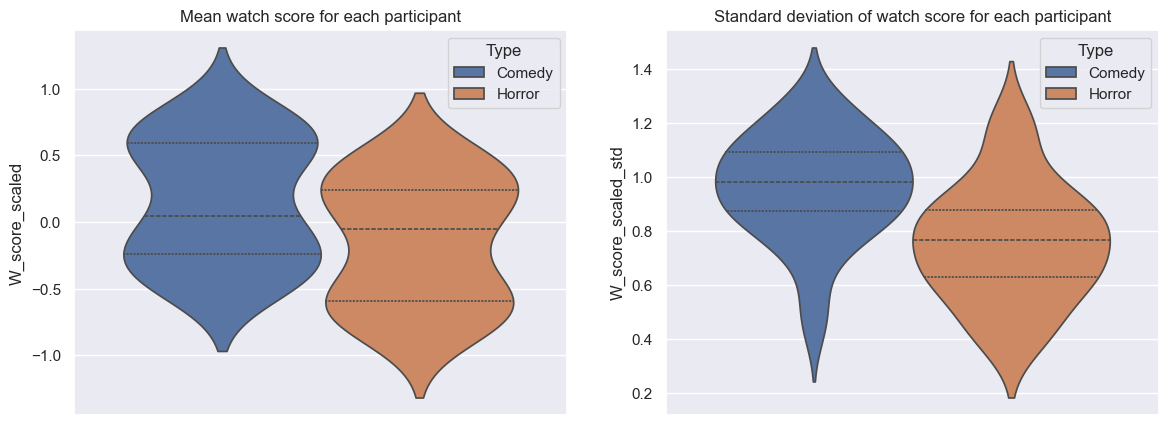

In [25]:
# Catching participants who consistently disliked horror/comedy movies. 
all_subs_events_comedy = all_participants_wide_formated_df.loc[all_participants_wide_formated_df["Trial_Type"] == "Comedy"]
all_subs_events_horror = all_participants_wide_formated_df.loc[all_participants_wide_formated_df["Trial_Type"] == "Horror"]

Individuals_mean_comedy_df = all_subs_events_comedy.groupby("Participant", as_index=False, dropna=False).mean()
Individuals_std_comedy_df = all_subs_events_comedy.groupby("Participant", as_index=False, dropna=False).std()
Individuals_mean_comedy_df["W_score_scaled_std"] = Individuals_std_comedy_df["W_score_scaled"]
Individuals_mean_comedy_df["Type"] = "Comedy"

Individuals_mean_horror_df = all_subs_events_horror.groupby("Participant", as_index=False, dropna=False).mean()
Individuals_std_horror_df = all_subs_events_horror.groupby("Participant", as_index=False, dropna=False).std()
Individuals_mean_horror_df["W_score_scaled_std"] = Individuals_std_horror_df["W_score_scaled"]
Individuals_mean_horror_df["Type"] = "Horror"

all_participants_means_df = pd.concat([Individuals_mean_comedy_df, Individuals_mean_horror_df], ignore_index=True)

sns.set(font_scale=1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.violinplot(data=all_participants_means_df, y="W_score_scaled", hue="Type", inner="quart", ax=axs[0])
axs[0].set_title("Mean watch score for each participant")

sns.violinplot(data=all_participants_means_df, y="W_score_scaled_std", hue="Type", inner="quart", ax=axs[1])
axs[1].set_title("Standard deviation of watch score for each participant")

In [26]:
# Use k-mean clustering to separate participants into subgroups: those who like and dislike horror and comedy movies.

kmeans_horror = KMeans(n_clusters = 2, random_state = 2)
kmeans_comedy = KMeans(n_clusters = 2, random_state = 2)

Individuals_mean_horror_array = np.array(Individuals_mean_horror_df["W_score_scaled"]).reshape(-1, 1)
Individuals_mean_comedy_array = np.array(Individuals_mean_comedy_df["W_score_scaled"]).reshape(-1, 1)

kmeans_horror.fit(Individuals_mean_horror_array)
kmeans_comedy.fit(Individuals_mean_comedy_array)

if(kmeans_horror.cluster_centers_[0] == kmeans_horror.cluster_centers_.max()):
    horror_cluster_label_LH = 0
    horror_cluster_label_DH = 1
else:
    horror_cluster_label_LH = 1
    horror_cluster_label_DH = 0

if(kmeans_comedy.cluster_centers_[0] == kmeans_comedy.cluster_centers_.max()):
    comedy_cluster_label_LC = 0
    comedy_cluster_label_DC = 1
else:
    comedy_cluster_label_LC = 1
    comedy_cluster_label_DC = 0

Individuals_mean_horror_df["LH_cluster_prefrence"] = kmeans_horror.labels_
Individuals_mean_comedy_df["LC_cluster_prefrence"] = kmeans_comedy.labels_

In [27]:
Dislike_horror_list = []
Like_horror_list = []

Dislike_comedy_list = []
Like_comedy_list = []

participants_list1 = Individuals_mean_horror_df["Participant"].unique()

for participant_id in range((Individuals_mean_horror_df.shape[0])):

    if Individuals_mean_horror_df.loc[participant_id, "LH_cluster_prefrence"] == horror_cluster_label_DH: 
        Dislike_horror_list.append(participants_list1[participant_id])
    else: 
        Like_horror_list.append(participants_list1[participant_id])

    if Individuals_mean_comedy_df.loc[participant_id, "LC_cluster_prefrence"] == comedy_cluster_label_DC: 
        Dislike_comedy_list.append(participants_list1[participant_id])
    else:
        Like_comedy_list.append(participants_list1[participant_id])

print("Participants who dislike horror movies: ", Dislike_horror_list)
print("Participants who like horror movies: ", Like_horror_list)

print("\nParticipants who dislike comedy movies: ", Dislike_comedy_list)
print("Participants who like comedy movies: ", Like_comedy_list)


Participants who dislike horror movies:  ['sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-18', 'sub-21', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']
Participants who like horror movies:  ['sub-01', 'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-15', 'sub-16', 'sub-17', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']

Participants who dislike comedy movies:  ['sub-01', 'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-15', 'sub-16', 'sub-17', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']
Participants who like comedy movies:  ['sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-18', 'sub-21', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']


In [28]:
# Add movie preference to the main dataframe.

all_participants_wide_formated_df["Horror_Preference"] = np.repeat("Like", all_participants_wide_formated_df.shape[0])
all_participants_wide_formated_df["Comedy_Preference"] = np.repeat("Like", all_participants_wide_formated_df.shape[0])

for participant_id in range(all_participants_wide_formated_df.shape[0]):

    if all_participants_wide_formated_df.loc[participant_id, "Participant"] in Dislike_horror_list:
        all_participants_wide_formated_df.loc[participant_id, "Horror_Preference"] = "Dislike"

    if all_participants_wide_formated_df.loc[participant_id, "Participant"] in Dislike_comedy_list:
        all_participants_wide_formated_df.loc[participant_id, "Comedy_Preference"] = "Dislike"

all_participants_wide_formated_df.head(10)

,Participant,Trailer,W_score,F_score,A_score,Pos_arousal,Neg_arousal,W_score_scaled,F_score_scaled,A_score_scaled,...,MPFC_TR9,MPFC_TR10,MPFC_TR11,MPFC_TR12,MPFC_TR13,MPFC_TR14,MPFC_TR15,Trial_Type,Horror_Preference,Comedy_Preference
0,sub-01,rh6,3.0,2.0,3.0,3.535534,0.707107,0.5625,-0.5,0.375,...,-0.114464,0.185538,-0.059828,-0.700006,-0.586191,-0.026419,-0.519548,Horror,Like,Dislike
1,sub-01,uh1,1.0,3.0,3.0,4.242641,0.000000,-1.4375,0.5,0.375,...,-0.331479,-0.165720,-0.114452,0.712012,1.180400,0.805740,0.040790,Horror,Like,Dislike
2,sub-01,rc2,1.0,3.0,1.0,2.828427,-1.414214,-1.4375,0.5,-1.625,...,0.136451,0.124245,0.179678,-0.149836,-0.011022,0.408177,0.487413,Comedy,Like,Dislike
3,sub-01,rh2,3.0,2.0,2.0,2.828427,0.000000,0.5625,-0.5,-0.625,...,0.384224,-0.002358,0.021452,0.371250,0.097798,0.196087,0.585064,Horror,Like,Dislike
4,sub-01,rh1,4.0,2.0,3.0,3.535534,0.707107,1.5625,-0.5,0.375,...,-0.236193,0.506609,0.897501,0.178332,-0.470862,-0.414180,0.477916,Horror,Like,Dislike
5,sub-01,rc9,4.0,4.0,4.0,5.656854,0.000000,1.5625,1.5,1.375,...,-0.987064,-1.223970,-0.854177,0.185168,0.624454,0.825088,0.507399,Comedy,Like,Dislike
6,sub-01,uc4,3.0,4.0,2.0,4.242641,-1.414214,0.5625,1.5,-0.625,...,0.388087,0.725870,0.056695,-0.772247,-0.883871,-0.399425,-0.586076,Comedy,Like,Dislike
7,sub-01,rh9,2.0,2.0,2.0,2.828427,0.000000,-0.4375,-0.5,-0.625,...,0.367367,0.366057,-0.576939,-0.211994,0.044968,0.290272,-0.019333,Horror,Like,Dislike
8,sub-01,uh2,4.0,1.0,3.0,2.828427,1.414214,1.5625,-1.5,0.375,...,0.341562,0.635247,0.272657,-0.055097,-0.462133,-0.606093,-0.970609,Horror,Like,Dislike
9,sub-01,rc6,1.0,3.0,1.0,2.828427,-1.414214,-1.4375,0.5,-1.625,...,0.103950,-0.177336,-0.112504,0.020034,-0.116254,-0.110755,-0.104879,Comedy,Like,Dislike


In [29]:
# NAcc_trailer_key = ["NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8",
#                      "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14",
#                      "NAcc_TR15", "NAcc_TR16", "NAcc_TR17"]


# NAcc_trailer_key = ["NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15", "NAcc_TR16", "NAcc_TR17", 
#                     "NAcc_TR18", "NAcc_TR19", "NAcc_TR20", "NAcc_TR21", "NAcc_TR22", "NAcc_TR23", "NAcc_TR24"] 

# AIns_trailer_key = ["AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8",
#                     "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14",
#                     "AIns_TR15", "AIns_TR16", "AIns_TR17"]

# AIns_trailer_key = ["AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15", "AIns_TR16", "AIns_TR17",
#                     "AIns_TR18", "AIns_TR19", "AIns_TR20", "AIns_TR21", "AIns_TR22", "AIns_TR23", "AIns_TR24"]

# Amyg_trailer_key = ["Amyg_TR3", "Amyg_TR4", "Amyg_TR5", "Amyg_TR6", "Amyg_TR7", "Amyg_TR8",
#                     "Amyg_TR9", "Amyg_TR10", "Amyg_TR11", "Amyg_TR12", "Amyg_TR13", "Amyg_TR14",
#                     "Amyg_TR15", "Amyg_TR16", "Amyg_TR17"]

# Amyg_trailer_key = ["Amyg_TR12", "Amyg_TR13", "Amyg_TR14", "Amyg_TR15", "Amyg_TR16", "Amyg_TR17",
#                     "Amyg_TR18", "Amyg_TR19", "Amyg_TR20", "Amyg_TR21", "Amyg_TR22", "Amyg_TR23", "Amyg_TR24"]

# MPFC_trailer_key = ["MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8",
#                     "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14",
#                     "MPFC_TR15", "MPFC_TR16", "MPFC_TR17"]

# MPFC_trailer_key = ["MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15", "MPFC_TR16", "MPFC_TR17",
#                     "MPFC_TR18", "MPFC_TR19", "MPFC_TR20", "MPFC_TR21", "MPFC_TR22", "MPFC_TR23", "MPFC_TR24"]


In [30]:
NAcc_trailer_key = ["NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8",
                    "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15"]

AIns_trailer_key = ["AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8",
                    "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15"]

Amyg_trailer_key = ["Amyg_TR1", "Amyg_TR2", "Amyg_TR3", "Amyg_TR4", "Amyg_TR5", "Amyg_TR6", "Amyg_TR7", "Amyg_TR8",
                    "Amyg_TR9", "Amyg_TR10", "Amyg_TR11", "Amyg_TR12", "Amyg_TR13", "Amyg_TR14", "Amyg_TR15"]

MPFC_trailer_key = ["MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8",
                    "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15"]

In [31]:

# Create final dataframe to store all the data.
all_participants_proccessed_df = pd.DataFrame() 

# Loop through each subject.
for sub_id in all_participants_wide_formated_df["Participant"].unique():

    # Get the data for the current subject.
    current_sub_df = all_participants_wide_formated_df.loc[all_participants_wide_formated_df["Participant"] == sub_id]

    # Get the trailer keys for the current subject.
    current_sub_trailer_keys = current_sub_df["Trailer"].unique().tolist() 

    # Add zero columns for each ROI.
    current_sub_df["NAcc_S1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_S1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_S1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_S2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_S2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_S2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_S2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_S2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_S3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_S3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_S3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_S3"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_S4"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_S4"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_S4"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_S4"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_S5"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_S5"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_S5"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_S5"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_AVG"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_AVG"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_AVG"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_AVG"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_max"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_max"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_max"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_max"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_max_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_max_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_max_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_max_id"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_max2_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_max2_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_max2_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_max2_id"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_min"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_min"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_min"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_min"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_min_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_min_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_min_id"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_min_id"] = np.zeros(current_sub_df.shape[0])

    # Add descriptive columns for trailer. 
    current_sub_df["Type"] = np.zeros(current_sub_df.shape[0])

    # Loop through each trailer.
    for trailer_id in current_sub_trailer_keys: 

        # Get NAcc data for the current trailer.
        current_sub_NAcc_trailer_df = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][NAcc_trailer_key].to_numpy().flatten()

        # Get AIns data for the current trailer.
        current_sub_AIns_trailer_df = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][AIns_trailer_key].to_numpy().flatten()

        # Get Amyg data for the current trailer.
        current_sub_Amyg_trailer_df = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][Amyg_trailer_key].to_numpy().flatten()

        # Get MPFC data for the current trailer.
        current_sub_MPFC_trailer_df = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][MPFC_trailer_key].to_numpy().flatten()

        # Get onset (S1) for current trailer.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_S1"] = np.nanmean(current_sub_NAcc_trailer_df[0:3])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_S1"] = np.nanmean(current_sub_AIns_trailer_df[0:3])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_S1"] = np.nanmean(current_sub_Amyg_trailer_df[0:3])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_S1"] = np.nanmean(current_sub_MPFC_trailer_df[0:3])

        # Get S2 for current trailer.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_S2"] = np.nanmean(current_sub_NAcc_trailer_df[3:6])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_S2"] = np.nanmean(current_sub_AIns_trailer_df[3:6])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_S2"] = np.nanmean(current_sub_Amyg_trailer_df[3:6])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_S2"] = np.nanmean(current_sub_MPFC_trailer_df[3:6])

        # Get S3 for current trailer.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_S3"] = np.nanmean(current_sub_NAcc_trailer_df[6:9])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_S3"] = np.nanmean(current_sub_AIns_trailer_df[6:9])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_S3"] = np.nanmean(current_sub_Amyg_trailer_df[6:9])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_S3"] = np.nanmean(current_sub_MPFC_trailer_df[6:9])

        # Get S4 for current trailer.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_S4"] = np.nanmean(current_sub_NAcc_trailer_df[9:12])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_S4"] = np.nanmean(current_sub_AIns_trailer_df[9:12])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_S4"] = np.nanmean(current_sub_Amyg_trailer_df[9:12])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_S4"] = np.nanmean(current_sub_MPFC_trailer_df[9:12])

        # Get S5 for current trailer.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_S5"] = np.nanmean(current_sub_NAcc_trailer_df[12:15])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_S5"] = np.nanmean(current_sub_AIns_trailer_df[12:15])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_S5"] = np.nanmean(current_sub_Amyg_trailer_df[12:15])
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_S5"] = np.nanmean(current_sub_MPFC_trailer_df[12:15])

        # Get the average for each ROI.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_AVG"] = np.nanmean(current_sub_NAcc_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_AVG"] = np.nanmean(current_sub_AIns_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_AVG"] = np.nanmean(current_sub_Amyg_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_AVG"] = np.nanmean(current_sub_MPFC_trailer_df)

        # Get the max for each ROI.
        #print(np.nanmax(current_sub_NAcc_trailer_df))
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_max"] = np.nanmax(current_sub_NAcc_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_max"] = np.nanmax(current_sub_AIns_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_max"] = np.nanmax(current_sub_Amyg_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_max"] = np.nanmax(current_sub_MPFC_trailer_df)

        # Get the max id for each ROI.
        # current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_max_id"] = np.nanargmax(current_sub_NAcc_trailer_df)
        # current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_max_id"] = np.nanargmax(current_sub_AIns_trailer_df)
        # current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_max_id"] = np.nanargmax(current_sub_Amyg_trailer_df)
        # current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_max_id"] = np.nanargmax(current_sub_MPFC_trailer_df)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_max_id"] = np.argsort(current_sub_NAcc_trailer_df)[-1]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_max_id"] = np.argsort(current_sub_AIns_trailer_df)[-1]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_max_id"] = np.argsort(current_sub_Amyg_trailer_df)[-1]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_max_id"] = np.argsort(current_sub_MPFC_trailer_df)[-1]

        # Get the second max id for each ROI.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_max2_id"] = np.argsort(current_sub_NAcc_trailer_df)[-2]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_max2_id"] = np.argsort(current_sub_AIns_trailer_df)[-2]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_max2_id"] = np.argsort(current_sub_Amyg_trailer_df)[-2]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_max2_id"] = np.argsort(current_sub_MPFC_trailer_df)[-2]

        # Get the min for each ROI.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_min"] = np.nanmin(current_sub_NAcc_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_min"] = np.nanmin(current_sub_AIns_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_min"] = np.nanmin(current_sub_Amyg_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_min"] = np.nanmin(current_sub_MPFC_trailer_df)

        # Get the min id for each ROI.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_min_id"] = np.nanargmin(current_sub_NAcc_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_min_id"] = np.nanargmin(current_sub_AIns_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_min_id"] = np.nanargmin(current_sub_Amyg_trailer_df)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_min_id"] = np.nanargmin(current_sub_MPFC_trailer_df)

        if 'c' in trailer_id:
            current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Type"] = "Comedy"
        else:
            current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Type"] = "Horror"

    all_participants_proccessed_df = pd.concat([all_participants_proccessed_df, current_sub_df], ignore_index=False)

all_participants_proccessed_df.head(10)
    

,Participant,Trailer,W_score,F_score,A_score,Pos_arousal,Neg_arousal,W_score_scaled,F_score_scaled,A_score_scaled,...,NAcc_min,AIns_min,Amyg_min,MPFC_min,NAcc_min_id,AIns_min_id,Amyg_min_id,MPFC_min_id,Type,MPFC_S1
0,sub-01,rh6,3.0,2.0,3.0,3.535534,0.707107,0.5625,-0.5,0.375,...,-0.782105,-0.358532,-0.559010,-0.700006,12.0,14.0,13.0,11.0,Horror,1.442070
1,sub-01,uh1,1.0,3.0,3.0,4.242641,0.000000,-1.4375,0.5,0.375,...,-0.251042,-1.084540,-0.222955,-0.430813,10.0,8.0,10.0,2.0,Horror,0.126978
2,sub-01,rc2,1.0,3.0,1.0,2.828427,-1.414214,-1.4375,0.5,-1.625,...,-1.155910,-0.451600,-0.304609,-0.756714,0.0,9.0,14.0,1.0,Comedy,-0.366204
3,sub-01,rh2,3.0,2.0,2.0,2.828427,0.000000,0.5625,-0.5,-0.625,...,-0.670634,-0.839715,-0.364911,-0.993326,8.0,5.0,6.0,6.0,Horror,0.186127
4,sub-01,rh1,4.0,2.0,3.0,3.535534,0.707107,1.5625,-0.5,0.375,...,-0.545023,-0.386388,-0.552224,-0.672417,5.0,5.0,8.0,5.0,Horror,0.490204
5,sub-01,rc9,4.0,4.0,4.0,5.656854,0.000000,1.5625,1.5,1.375,...,-0.707963,-1.143570,-0.218200,-1.311270,9.0,2.0,3.0,7.0,Comedy,0.533000
6,sub-01,uc4,3.0,4.0,2.0,4.242641,-1.414214,0.5625,1.5,-0.625,...,-0.633380,-1.090750,-0.651060,-0.883871,8.0,7.0,2.0,12.0,Comedy,-0.468203
7,sub-01,rh9,2.0,2.0,2.0,2.828427,0.000000,-0.4375,-0.5,-0.625,...,-0.824935,-0.518469,-0.367982,-0.576939,13.0,4.0,3.0,10.0,Horror,0.028364
8,sub-01,uh2,4.0,1.0,3.0,2.828427,1.414214,1.5625,-1.5,0.375,...,-0.666039,-1.038200,-0.226509,-0.970609,14.0,13.0,9.0,14.0,Horror,0.706648
9,sub-01,rc6,1.0,3.0,1.0,2.828427,-1.414214,-1.4375,0.5,-1.625,...,-0.281931,-1.007440,-0.208577,-0.478927,5.0,6.0,9.0,6.0,Comedy,0.813341


In [32]:
# 

def select_peak_std(P1, P2, P3, time_series_std):

    P1_std = np.abs(time_series_std[P1])
    P2_std = np.abs(time_series_std[P2])
    P3_std = np.abs(time_series_std[P3])
  

    # From the peaks which has the lowest std?
    peak_std = 0

    # Determine which has lower std.
    if (P1_std < P2_std) and (P1_std < P3_std):
        peak_std = P1
    elif(time_series_std[P2] < time_series_std[P1]) and (time_series_std[P2] < time_series_std[P3]):
        peak_std = P2
    else:
        peak_std = P3

    return peak_std



In [33]:
# Try sum of 2 - 3 peaks.
# Try selecting peak based on signal and std.

# Create column for binary choice to watch the trailer.
all_participants_proccessed_df["Watch_choice"] = "No"
all_participants_proccessed_df.loc[all_participants_proccessed_df["W_score"] > 2, "Watch_choice"] = "Yes"

all_participants_proccessed_YES_df = all_participants_proccessed_df[all_participants_proccessed_df["Watch_choice"] == "Yes"]
all_participants_proccessed_NO_df = all_participants_proccessed_df[all_participants_proccessed_df["Watch_choice"] == "No"]

# Create dic to store peak information. 
peak_info = {}

for trailer_id in all_participants_proccessed_df["Trailer"].unique():

    # Create dic for current trailer. 
    current_trailer_dic = {}

    # Get the data for the current trailer.
    current_trailer_df = all_participants_proccessed_df.loc[all_participants_proccessed_df["Trailer"] == trailer_id]
    current_trailer_YES_df = all_participants_proccessed_YES_df.loc[all_participants_proccessed_YES_df["Trailer"] == trailer_id]

    # Get democratic peack (most popular location).

    ## Testing
    # Pool max 1 and max two to select democratic peak.

    NAcc_array_ids = np.array([current_trailer_df["NAcc_max_id"].to_numpy(), current_trailer_df["NAcc_max2_id"].to_numpy()]).flatten()
    AIns_array_ids = np.array([current_trailer_df["AIns_max_id"].to_numpy(), current_trailer_df["AIns_max2_id"].to_numpy()]).flatten()
    Amyg_array_ids = np.array([current_trailer_df["Amyg_max_id"].to_numpy(), current_trailer_df["Amyg_max2_id"].to_numpy()]).flatten()
    MPFC_array_ids = np.array([current_trailer_df["MPFC_max_id"].to_numpy(), current_trailer_df["MPFC_max2_id"].to_numpy()]).flatten()

    NAcc_array_ids_YES = np.array([current_trailer_YES_df["NAcc_max_id"].to_numpy(), current_trailer_YES_df["NAcc_max2_id"].to_numpy()]).flatten()
    AIns_array_ids_YES = np.array([current_trailer_YES_df["AIns_max_id"].to_numpy(), current_trailer_YES_df["AIns_max2_id"].to_numpy()]).flatten()
    Amyg_array_ids_YES = np.array([current_trailer_YES_df["Amyg_max_id"].to_numpy(), current_trailer_YES_df["Amyg_max2_id"].to_numpy()]).flatten()
    MPFC_array_ids_YES = np.array([current_trailer_YES_df["MPFC_max_id"].to_numpy(), current_trailer_YES_df["MPFC_max2_id"].to_numpy()]).flatten()

    #print(NAcc_array_ids)
    print("Trailer "  + str(trailer_id) + ": " + str(multimode(NAcc_array_ids)) + " selected: " + str(st.mode(NAcc_array_ids)[0][0]))
    #print("Trailer "  + str(trailer_id) + ": " + str(multimode(NAcc_array_ids)) + " selected: " + str(st.mode(NAcc_array_ids)[0][0]))
    #print(np.bincount(NAcc_array_ids))

    #print(st.mode(NAcc_array_ids)[0])
    #print(st.mode(NAcc_array_ids)[1])
    


    current_trailer_dic["NAcc_DP"] = st.mode(NAcc_array_ids)[0][0]
    current_trailer_dic["AIns_DP"] = st.mode(AIns_array_ids)[0][0]
    current_trailer_dic["Amyg_DP"] = st.mode(Amyg_array_ids)[0][0]
    current_trailer_dic["MPFC_DP"] = st.mode(MPFC_array_ids)[0][0]

    # Get the democratic peak for the YES group.
    current_trailer_dic["NAcc_DPy"] = st.mode(NAcc_array_ids_YES)[0][0]
    current_trailer_dic["AIns_DPy"] = st.mode(AIns_array_ids_YES)[0][0]
    current_trailer_dic["Amyg_DPy"] = st.mode(Amyg_array_ids_YES)[0][0]
    current_trailer_dic["MPFC_DPy"] = st.mode(MPFC_array_ids_YES)[0][0]

    ##

    # current_trailer_dic["NAcc_DP"] = current_trailer_df["NAcc_max_id"].value_counts(ascending=False).index[0]
    # current_trailer_dic["AIns_DP"] = current_trailer_df["AIns_max_id"].value_counts(ascending=False).index[0]
    # current_trailer_dic["Amyg_DP"] = current_trailer_df["Amyg_max_id"].value_counts(ascending=False).index[0]
    # current_trailer_dic["MPFC_DP"] = current_trailer_df["MPFC_max_id"].value_counts(ascending=False).index[0]

    # # Get the democratic peak for the YES group.
    # current_trailer_dic["NAcc_DPy"] = current_trailer_YES_df["NAcc_max_id"].value_counts(ascending=False).index[0]
    # current_trailer_dic["AIns_DPy"] = current_trailer_YES_df["AIns_max_id"].value_counts(ascending=False).index[0]
    # current_trailer_dic["Amyg_DPy"] = current_trailer_YES_df["Amyg_max_id"].value_counts(ascending=False).index[0]
    # current_trailer_dic["MPFC_DPy"] = current_trailer_YES_df["MPFC_max_id"].value_counts(ascending=False).index[0]

    # Get mean time series for each ROI. 
    NAcc_time_series = current_trailer_df[NAcc_trailer_key].mean(axis=0, skipna=True)
    AIns_time_series = current_trailer_df[AIns_trailer_key].mean(axis=0, skipna=True)
    Amyg_time_series = current_trailer_df[Amyg_trailer_key].mean(axis=0, skipna=True)
    MPFC_time_series = current_trailer_df[MPFC_trailer_key].mean(axis=0, skipna=True)

    # Get the mean time series for the YES group.
    NAcc_time_series_YES = current_trailer_YES_df[NAcc_trailer_key].mean(axis=0, skipna=True)
    AIns_time_series_YES = current_trailer_YES_df[AIns_trailer_key].mean(axis=0, skipna=True)
    Amyg_time_series_YES = current_trailer_YES_df[Amyg_trailer_key].mean(axis=0, skipna=True)
    MPFC_time_series_YES = current_trailer_YES_df[MPFC_trailer_key].mean(axis=0, skipna=True)

    # Get the location of peak for AVG time series.
    current_trailer_dic["NAcc_peak"] = np.argmax(NAcc_time_series)
    current_trailer_dic["AIns_peak"] = np.argmax(AIns_time_series)
    current_trailer_dic["Amyg_peak"] = np.argmax(Amyg_time_series)
    current_trailer_dic["MPFC_peak"] = np.argmax(MPFC_time_series)

    # Get the location of peak for YES group.
    current_trailer_dic["NAcc_peak_YES"] = np.argmax(NAcc_time_series_YES)
    current_trailer_dic["AIns_peak_YES"] = np.argmax(AIns_time_series_YES)
    current_trailer_dic["Amyg_peak_YES"] = np.argmax(Amyg_time_series_YES)
    current_trailer_dic["MPFC_peak_YES"] = np.argmax(MPFC_time_series_YES)

    # Get the std time series for each ROI.
    NAcc_time_series_std = current_trailer_df[NAcc_trailer_key].std(axis=0, skipna=True)
    AIns_time_series_std = current_trailer_df[AIns_trailer_key].std(axis=0, skipna=True)
    Amyg_time_series_std = current_trailer_df[Amyg_trailer_key].std(axis=0, skipna=True)
    MPFC_time_series_std = current_trailer_df[MPFC_trailer_key].std(axis=0, skipna=True)

    # Get the std time series for the YES group.
    NAcc_time_series_std_YES = current_trailer_YES_df[NAcc_trailer_key].std(axis=0, skipna=True)
    AIns_time_series_std_YES = current_trailer_YES_df[AIns_trailer_key].std(axis=0, skipna=True)
    Amyg_time_series_std_YES = current_trailer_YES_df[Amyg_trailer_key].std(axis=0, skipna=True)
    MPFC_time_series_std_YES = current_trailer_YES_df[MPFC_trailer_key].std(axis=0, skipna=True)

    # Get the location of peak for AVG time series.
    current_trailer_dic["NAcc_peak_std"] = np.argmin(NAcc_time_series_std)
    current_trailer_dic["AIns_peak_std"] = np.argmin(AIns_time_series_std)
    current_trailer_dic["Amyg_peak_std"] = np.argmin(Amyg_time_series_std)
    current_trailer_dic["MPFC_peak_std"] = np.argmin(MPFC_time_series_std)

    # Get the location of peak for YES group.
    current_trailer_dic["NAcc_peak_std_YES"] = np.argmin(NAcc_time_series_std_YES)
    current_trailer_dic["AIns_peak_std_YES"] = np.argmin(AIns_time_series_std_YES)
    current_trailer_dic["Amyg_peak_std_YES"] = np.argmin(Amyg_time_series_std_YES)
    current_trailer_dic["MPFC_peak_std_YES"] = np.argmin(MPFC_time_series_std_YES)

    ## Experimental peaks.
    NAcc_time_series_list = current_trailer_df[NAcc_trailer_key].mean(axis=0, skipna=True).tolist()
    AIns_time_series_list = current_trailer_df[AIns_trailer_key].mean(axis=0, skipna=True).tolist()
    Amyg_time_series_list = current_trailer_df[Amyg_trailer_key].mean(axis=0, skipna=True).tolist()
    MPFC_time_series_list = current_trailer_df[MPFC_trailer_key].mean(axis=0, skipna=True).tolist()

    NAcc_time_series_YES_list = current_trailer_YES_df[NAcc_trailer_key].mean(axis=0, skipna=True).tolist()
    AIns_time_series_YES_list = current_trailer_YES_df[AIns_trailer_key].mean(axis=0, skipna=True).tolist()
    Amyg_time_series_YES_list = current_trailer_YES_df[Amyg_trailer_key].mean(axis=0, skipna=True).tolist()
    MPFC_time_series_YES_list = current_trailer_YES_df[MPFC_trailer_key].mean(axis=0, skipna=True).tolist()

    # Sort time series.
    NAcc_time_series_list_sort = sorted(NAcc_time_series_list, reverse=True)
    AIns_time_series_list_sort = sorted(AIns_time_series_list, reverse=True)
    Amyg_time_series_list_sort = sorted(Amyg_time_series_list, reverse=True)
    MPFC_time_series_list_sort = sorted(MPFC_time_series_list, reverse=True)

    NAcc_time_series_YES_list_sort = sorted(NAcc_time_series_YES_list, reverse=True)
    AIns_time_series_YES_list_sort = sorted(AIns_time_series_YES_list, reverse=True)
    Amyg_time_series_YES_list_sort = sorted(Amyg_time_series_YES_list, reverse=True)
    MPFC_time_series_YES_list_sort = sorted(MPFC_time_series_YES_list, reverse=True)

    # Get peaks indexes.
    NAcc_P1 = NAcc_time_series_list.index(NAcc_time_series_list_sort[0])
    NAcc_P2 = NAcc_time_series_list.index(NAcc_time_series_list_sort[1])
    NAcc_P3 = NAcc_time_series_list.index(NAcc_time_series_list_sort[2])
    # print("NAcc peaks: ", NAcc_P1, NAcc_P2, NAcc_P3)
    # print(NAcc_time_series_list_sort[0])
    # print(NAcc_time_series_list_sort[1])
    # print(NAcc_time_series_list_sort[2])


    current_trailer_dic["NAcc_P1"] = NAcc_P1
    current_trailer_dic["NAcc_P2"] = NAcc_P2
    current_trailer_dic["NAcc_P3"] = NAcc_P3

    AIns_P1 = AIns_time_series_list.index(AIns_time_series_list_sort[0])
    AIns_P2 = AIns_time_series_list.index(AIns_time_series_list_sort[1])
    AIns_P3 = AIns_time_series_list.index(AIns_time_series_list_sort[2])

    current_trailer_dic["AIns_P1"] = AIns_P1
    current_trailer_dic["AIns_P2"] = AIns_P2
    current_trailer_dic["AIns_P3"] = AIns_P3

    Amyg_P1 = Amyg_time_series_list.index(Amyg_time_series_list_sort[0])
    Amyg_P2 = Amyg_time_series_list.index(Amyg_time_series_list_sort[1])
    Amyg_P3 = Amyg_time_series_list.index(Amyg_time_series_list_sort[2])

    current_trailer_dic["Amyg_P1"] = Amyg_P1
    current_trailer_dic["Amyg_P2"] = Amyg_P2
    current_trailer_dic["Amyg_P3"] = Amyg_P3

    MPFC_P1 = MPFC_time_series_list.index(MPFC_time_series_list_sort[0])
    MPFC_P2 = MPFC_time_series_list.index(MPFC_time_series_list_sort[1])
    MPFC_P3 = MPFC_time_series_list.index(MPFC_time_series_list_sort[2])

    current_trailer_dic["MPFC_P1"] = MPFC_P1
    current_trailer_dic["MPFC_P2"] = MPFC_P2
    current_trailer_dic["MPFC_P3"] = MPFC_P3

    NAcc_YES_P1 = NAcc_time_series_YES_list.index(NAcc_time_series_YES_list_sort[0])
    NAcc_YES_P2 = NAcc_time_series_YES_list.index(NAcc_time_series_YES_list_sort[1])
    NAcc_YES_P3 = NAcc_time_series_YES_list.index(NAcc_time_series_YES_list_sort[2])

    current_trailer_dic["NAcc_YES_P1"] = NAcc_YES_P1
    current_trailer_dic["NAcc_YES_P2"] = NAcc_YES_P2
    current_trailer_dic["NAcc_YES_P3"] = NAcc_YES_P3

    AIns_YES_P1 = AIns_time_series_YES_list.index(AIns_time_series_YES_list_sort[0])
    AIns_YES_P2 = AIns_time_series_YES_list.index(AIns_time_series_YES_list_sort[1])
    AIns_YES_P3 = AIns_time_series_YES_list.index(AIns_time_series_YES_list_sort[2])

    current_trailer_dic["AIns_YES_P1"] = AIns_YES_P1
    current_trailer_dic["AIns_YES_P2"] = AIns_YES_P2
    current_trailer_dic["AIns_YES_P3"] = AIns_YES_P3

    Amyg_YES_P1 = Amyg_time_series_YES_list.index(Amyg_time_series_YES_list_sort[0])
    Amyg_YES_P2 = Amyg_time_series_YES_list.index(Amyg_time_series_YES_list_sort[1])
    Amyg_YES_P3 = Amyg_time_series_YES_list.index(Amyg_time_series_YES_list_sort[2])

    current_trailer_dic["Amyg_YES_P1"] = Amyg_YES_P1
    current_trailer_dic["Amyg_YES_P2"] = Amyg_YES_P2
    current_trailer_dic["Amyg_YES_P3"] = Amyg_YES_P3

    MPFC_YES_P1 = MPFC_time_series_YES_list.index(MPFC_time_series_YES_list_sort[0])
    MPFC_YES_P2 = MPFC_time_series_YES_list.index(MPFC_time_series_YES_list_sort[1])
    MPFC_YES_P3 = MPFC_time_series_YES_list.index(MPFC_time_series_YES_list_sort[2])

    current_trailer_dic["MPFC_YES_P1"] = MPFC_YES_P1
    current_trailer_dic["MPFC_YES_P2"] = MPFC_YES_P2
    current_trailer_dic["MPFC_YES_P3"] = MPFC_YES_P3

    # # Get AVG-STD peaks.
    current_trailer_dic["NAcc_P_STD"] = select_peak_std(NAcc_P1, NAcc_P2, NAcc_P3, NAcc_time_series_std)
    current_trailer_dic["AIns_P_STD"] = select_peak_std(AIns_P1, AIns_P2, AIns_P3, AIns_time_series_std)
    current_trailer_dic["Amyg_P_STD"] = select_peak_std(Amyg_P1, Amyg_P2, Amyg_P3, Amyg_time_series_std)
    current_trailer_dic["MPFC_P_STD"] = select_peak_std(MPFC_P1, MPFC_P2, MPFC_P3, MPFC_time_series_std)

    current_trailer_dic["NAcc_YES_P_STD"] = select_peak_std(NAcc_YES_P1, NAcc_YES_P2, NAcc_YES_P3, NAcc_time_series_std_YES)
    current_trailer_dic["AIns_YES_P_STD"] = select_peak_std(AIns_YES_P1, AIns_YES_P2, AIns_YES_P3, AIns_time_series_std_YES)
    current_trailer_dic["Amyg_YES_P_STD"] = select_peak_std(Amyg_YES_P1, Amyg_YES_P2, Amyg_YES_P3, Amyg_time_series_std_YES)
    current_trailer_dic["MPFC_YES_P_STD"] = select_peak_std(MPFC_YES_P1, MPFC_YES_P2, MPFC_YES_P3, MPFC_time_series_std_YES)

    # Add to main dictionary.
    peak_info[trailer_id] = current_trailer_dic

    


Trailer rh6: [1.0] selected: 1.0
Trailer uh1: [6.0] selected: 6.0
Trailer rc2: [13.0] selected: 13.0
Trailer rh2: [1.0] selected: 1.0
Trailer rh1: [5.0] selected: 5.0
Trailer rc9: [5.0, 12.0] selected: 5.0
Trailer uc4: [13.0] selected: 13.0
Trailer rh9: [13.0, 1.0] selected: 1.0
Trailer uh2: [7.0] selected: 7.0
Trailer rc6: [14.0] selected: 14.0
Trailer rh3: [4.0] selected: 4.0
Trailer rc11: [13.0] selected: 13.0
Trailer uc1: [0.0] selected: 0.0
Trailer rh11: [14.0] selected: 14.0
Trailer rc12: [14.0] selected: 14.0
Trailer rc5: [0.0, 1.0, 11.0] selected: 0.0
Trailer rc3: [1.0] selected: 1.0
Trailer rh12: [14.0] selected: 14.0
Trailer rc1: [14.0] selected: 14.0
Trailer rh7: [14.0] selected: 14.0
Trailer rc8: [14.0] selected: 14.0
Trailer uc3: [0.0, 7.0] selected: 0.0
Trailer rh10: [11.0] selected: 11.0
Trailer rc4: [0.0] selected: 0.0
Trailer rh4: [14.0] selected: 14.0
Trailer uc2: [0.0] selected: 0.0
Trailer rh5: [8.0] selected: 8.0
Trailer rh8: [0.0] selected: 0.0
Trailer rc10: [0.0]

In [34]:
peak_info["rc10"]["NAcc_peak_YES"]

# transform dictionary to dataframe.
peak_info_df = pd.DataFrame(peak_info).T

peak_m = peak_info_df["NAcc_peak_YES"].head(32)

<Axes: xlabel='NAcc_DP', ylabel='Count'>

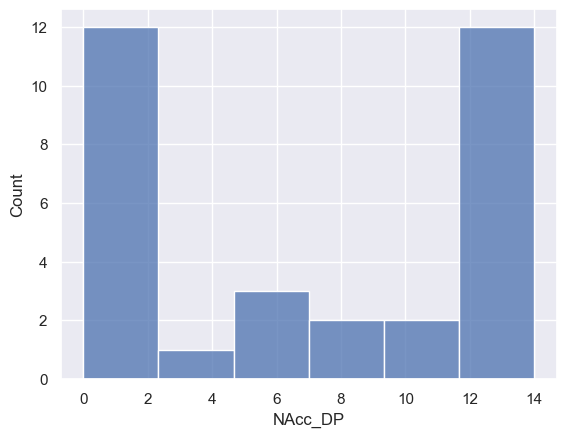

In [35]:
sns.histplot(peak_info_df["NAcc_DP"])


In [36]:

# Create keys addind +1 TR at the begginning and end of trailer. 
# NAcc_trailer_keys2 = ["NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", 
#                       "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", 
#                       "NAcc_TR13", "NAcc_TR14", "NAcc_TR15", "NAcc_TR16", "NAcc_TR17"]

# AIns_trailer_keys2 = ["AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", 
#                       "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", 
#                       "AIns_TR13", "AIns_TR14", "AIns_TR15", "AIns_TR16", "AIns_TR17"]

# Amyg_trailer_keys2 = ["Amyg_TR3", "Amyg_TR4", "Amyg_TR5", "Amyg_TR6", "Amyg_TR7", 
#                       "Amyg_TR8", "Amyg_TR9", "Amyg_TR10", "Amyg_TR11", "Amyg_TR12", 
#                       "Amyg_TR13", "Amyg_TR14", "Amyg_TR15", "Amyg_TR16", "Amyg_TR17"]

# MPFC_trailer_keys2 = ["MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", 
#                       "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", 
#                       "MPFC_TR13", "MPFC_TR14", "MPFC_TR15", "MPFC_TR16", "MPFC_TR17"]

NAcc_trailer_keys2 = NAcc_trailer_key
AIns_trailer_keys2 = AIns_trailer_key
Amyg_trailer_keys2 = Amyg_trailer_key
MPFC_trailer_keys2 = MPFC_trailer_key



In [37]:
def getPeaks(array, key, type):
    
    #print("Array: ", array)

    key = int(key)

    array = array.astype('float64')
    array=array[0]

    if(type == 1):

        return np.nanmean(array[key:key+3])#np.nanmean(array[key:key+1])
    
        #try:
        #    return np.nanmean(array[key:key+1])
        #except:
        #    return 0
    elif (type == 2):

        return np.nanmean(array[key:key+2])
    
        #try:
        #    return np.nanmean(array[key-1:key+1])
        #except:
        #    return 0
    
def getSumPeaks(P1_key, P2_key, P3_key, key, time_series):

    #print("Time series: ", time_series[0])

    time_series = time_series[0]

    sum = 0

    if(key==2):
        sum = time_series[P1_key] + time_series[P2_key]
    elif(key==3):
        sum = time_series[P1_key] + time_series[P2_key] + time_series[P3_key]

    return sum

def getAVGPeaks(P1_key, P2_key, P3_key, key, time_series):

    time_series = time_series[0]

    avg = 0

    if(key==2):
        avg = (time_series[P1_key] + time_series[P2_key]) / 2
    elif(key==3):
        avg = (time_series[P1_key] + time_series[P2_key] + time_series[P3_key]) / 3

    return avg


def getIndividualPeaks(key, time_series, type):

    #print("Time series: ", time_series[0])

    time_series = time_series[0]

    sorted_indices = np.argsort(time_series)

    P1 = time_series[sorted_indices[-1]]
    P2 = time_series[sorted_indices[-2]]
    P3 = time_series[sorted_indices[-3]]
    P4 = time_series[sorted_indices[-4]]

    output = 0

    if(key == 1):
        if(type == "sum"):
            output = P1 + P2
        elif(type == "avg"):
            output = (P1 + P2) / 2
    elif(key==2):
        if (type == "sum"):
            output = P1 + P2 + P3
        elif(type == "avg"):
            output = (P1 + P2 + P3) / 3
    elif(key==3):
        if (type == "sum"):
            output = P1 + P2 + P3 + P4
        elif(type == "avg"):
            output = (P1 + P2 + P3 + P4) / 4

    return output

In [38]:
type(NAcc_trailer_key)

list

In [39]:
test_key = ["Participant"] + (NAcc_trailer_key)

all_participants_proccessed_df[all_participants_proccessed_df["Trailer"] == "uh2"][test_key]


,Participant,NAcc_TR1,NAcc_TR2,NAcc_TR3,NAcc_TR4,NAcc_TR5,NAcc_TR6,NAcc_TR7,NAcc_TR8,NAcc_TR9,NAcc_TR10,NAcc_TR11,NAcc_TR12,NAcc_TR13,NAcc_TR14,NAcc_TR15
8,sub-01,0.237115,-0.074053,0.203110,0.007667,0.210915,0.285268,0.526267,-0.241025,-0.658393,-0.323407,-0.631281,-0.404341,-0.130621,-0.213096,-0.666039
40,sub-02,0.407142,0.125239,-0.237211,-0.711532,-0.130521,-0.296799,-0.012642,0.180133,-0.297894,-0.070858,0.045573,0.155673,-0.167629,-0.183598,-0.082171
72,sub-03,0.282529,-0.315549,-0.159480,0.168558,-0.286435,-0.078448,-0.246108,-0.246890,0.290988,0.136929,-0.317479,-0.068716,0.038226,-0.092605,0.444860
104,sub-04,-0.451975,-0.334830,-0.550596,-0.447933,-0.115183,0.039466,0.351706,-0.078463,0.116865,-0.476709,-0.201816,-0.047810,-0.273316,0.125323,0.165804
136,sub-08,0.355644,0.161946,-0.219752,-0.401048,-0.514008,-0.462947,-0.826527,-0.465321,-0.226104,0.333981,0.712567,0.042952,-0.138036,-0.109957,-0.021440
168,sub-09,0.416582,0.177092,0.014570,-0.263128,0.121297,0.012975,-0.408527,-0.240352,-0.356880,0.018304,-0.355762,-0.412467,0.215138,0.506611,-0.219041
200,sub-10,0.338618,-0.185627,-0.173985,0.022808,0.051765,0.033389,-0.627542,-0.029101,-0.140269,0.290379,0.174360,-0.483138,-0.398104,-0.347121,0.002136
232,sub-11,-0.199448,-0.125396,0.142628,0.050970,0.116519,-0.292687,-0.493852,-0.187412,0.200623,-0.160791,-0.018369,0.208640,-0.240505,0.012477,-0.127380
264,sub-12,-0.228348,-0.298136,-0.582608,-0.259093,-0.376900,0.155079,0.174273,0.167214,0.063805,0.198108,0.051047,0.164608,0.202336,0.298853,0.346104
296,sub-13,0.170201,0.321464,0.225381,0.234865,0.106424,0.319733,0.455698,0.110855,0.062239,0.428519,0.053588,-0.479918,-0.302579,-0.484236,0.014371


In [40]:
all_participants_proccessed_peaks_df = pd.DataFrame()

# Loop through each participant. 
for sub_id in all_participants_proccessed_df["Participant"].unique():

    # Get the data for the current participant.
    current_sub_df = all_participants_proccessed_df.loc[all_participants_proccessed_df["Participant"] == sub_id]

    # Replace nan strings with np.nans.
    #current_sub_df.replace(nan_object, np.nan, inplace=True)

    # Get the trailer keys for the current participant.
    current_sub_trailer_keys = current_sub_df["Trailer"].unique().tolist()

    # Add columns for the peak information.
    current_sub_df["NAcc_DP"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_DP"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_DP"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_DP"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_DPy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_DPy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_DPy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_DPy"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_STD"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_STD"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_STD"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_STD"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_STDy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_STDy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_STDy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_STDy"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_DP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_DP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_DP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_DP2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_DPy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_DPy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_DPy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_DPy2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_STD2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_STDy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_STDy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_STDy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_STDy2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_AvgP"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_AvgP"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_AvgP"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_AvgP"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_AvgPy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_AvgPy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_AvgPy"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_AvgPy"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_AvgP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_AvgP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_AvgP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_AvgP2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_AvgPy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_AvgPy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_AvgPy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_AvgPy2"] = np.zeros(current_sub_df.shape[0])

    ## Experimental peaks. 
    current_sub_df["NAcc_PS2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PS2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PS2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PS2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PS3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PS3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PS3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PS3"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PSy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PSy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PSy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PSy2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PSy3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PSy3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PSy3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PSy3"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PA2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PA2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PA2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PA2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PA3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PA3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PA3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PA3"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PAy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PAy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PAy2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PAy2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_PAy3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_PAy3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_PAy3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_PAy3"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_P_STD1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_P_STD1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_P_STD1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_P_STD1"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_YES_P_STD1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_YES_P_STD1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_YES_P_STD1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_YES_P_STD1"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_P_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_P_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_P_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_P_STD2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_YES_P_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_YES_P_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_YES_P_STD2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_YES_P_STD2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_P_STD3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_P_STD3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_P_STD3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_P_STD3"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_YES_P_STD3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_YES_P_STD3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_YES_P_STD3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_YES_P_STD3"] = np.zeros(current_sub_df.shape[0])

    # Individual peaks (IP):
    current_sub_df["NAcc_IP1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_IP1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_IP1"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_IP1"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_IP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_IP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_IP2"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_IP2"] = np.zeros(current_sub_df.shape[0])

    current_sub_df["NAcc_IP3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["AIns_IP3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["Amyg_IP3"] = np.zeros(current_sub_df.shape[0])
    current_sub_df["MPFC_IP3"] = np.zeros(current_sub_df.shape[0])

    # Loop through each trailer.
    for trailer_id in current_sub_trailer_keys:

        current_NAcc_time_series = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][NAcc_trailer_keys2].to_numpy()
        current_AIns_time_series = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][AIns_trailer_keys2].to_numpy()
        current_Amyg_time_series = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][Amyg_trailer_keys2].to_numpy()
        current_MPFC_time_series = current_sub_df.loc[current_sub_df["Trailer"] == trailer_id][MPFC_trailer_keys2].to_numpy()

        # Get id for peaks.
        # Add +1 to the peak id to match the time series... this time series has 17 TRs one more at the beggining and at the end.
        NAcc_DP_key = peak_info[trailer_id]["NAcc_DP"] 
        AIns_DP_key = peak_info[trailer_id]["AIns_DP"] 
        Amyg_DP_key = peak_info[trailer_id]["Amyg_DP"] 
        MPFC_DP_key = peak_info[trailer_id]["MPFC_DP"] 

        NAcc_DPy_key = peak_info[trailer_id]["NAcc_DPy"] 
        AIns_DPy_key = peak_info[trailer_id]["AIns_DPy"] 
        Amyg_DPy_key = peak_info[trailer_id]["Amyg_DPy"] 
        MPFC_DPy_key = peak_info[trailer_id]["MPFC_DPy"] 

        NAcc_STD_key = peak_info[trailer_id]["NAcc_peak_std"] 
        AIns_STD_key = peak_info[trailer_id]["AIns_peak_std"] 
        Amyg_STD_key = peak_info[trailer_id]["Amyg_peak_std"] 
        MPFC_STD_key = peak_info[trailer_id]["MPFC_peak_std"] 

        NAcc_STDy_key = peak_info[trailer_id]["NAcc_peak_std_YES"] 
        AIns_STDy_key = peak_info[trailer_id]["AIns_peak_std_YES"] 
        Amyg_STDy_key = peak_info[trailer_id]["Amyg_peak_std_YES"] 
        MPFC_STDy_key = peak_info[trailer_id]["MPFC_peak_std_YES"] 

        NAcc_AvgP_key = peak_info[trailer_id]["NAcc_peak"] 
        AIns_AvgP_key = peak_info[trailer_id]["AIns_peak"] 
        Amyg_AvgP_key = peak_info[trailer_id]["Amyg_peak"] 
        MPFC_AvgP_key = peak_info[trailer_id]["MPFC_peak"] 

        NAcc_AvgPy_key = peak_info[trailer_id]["NAcc_peak_YES"] 
        AIns_AvgPy_key = peak_info[trailer_id]["AIns_peak_YES"] 
        Amyg_AvgPy_key = peak_info[trailer_id]["Amyg_peak_YES"] 
        MPFC_AvgPy_key = peak_info[trailer_id]["MPFC_peak_YES"] 

        NAcc_P1_key = peak_info[trailer_id]["NAcc_P1"] 
        AIns_P1_key = peak_info[trailer_id]["AIns_P1"] 
        Amyg_P1_key = peak_info[trailer_id]["Amyg_P1"] 
        MPFC_P1_key = peak_info[trailer_id]["MPFC_P1"] 

        NAcc_P2_key = peak_info[trailer_id]["NAcc_P2"] 
        AIns_P2_key = peak_info[trailer_id]["AIns_P2"] 
        Amyg_P2_key = peak_info[trailer_id]["Amyg_P2"] 
        MPFC_P2_key = peak_info[trailer_id]["MPFC_P2"] 

        NAcc_P3_key = peak_info[trailer_id]["NAcc_P3"] 
        AIns_P3_key = peak_info[trailer_id]["AIns_P3"] 
        Amyg_P3_key = peak_info[trailer_id]["Amyg_P3"] 
        MPFC_P3_key = peak_info[trailer_id]["MPFC_P3"] 

        NAcc_YES_P1_key = peak_info[trailer_id]["NAcc_YES_P1"] 
        AIns_YES_P1_key = peak_info[trailer_id]["AIns_YES_P1"] 
        Amyg_YES_P1_key = peak_info[trailer_id]["Amyg_YES_P1"] 
        MPFC_YES_P1_key = peak_info[trailer_id]["MPFC_YES_P1"] 

        NAcc_YES_P2_key = peak_info[trailer_id]["NAcc_YES_P2"] 
        AIns_YES_P2_key = peak_info[trailer_id]["AIns_YES_P2"] 
        Amyg_YES_P2_key = peak_info[trailer_id]["Amyg_YES_P2"] 
        MPFC_YES_P2_key = peak_info[trailer_id]["MPFC_YES_P2"] 

        NAcc_YES_P3_key = peak_info[trailer_id]["NAcc_YES_P3"] 
        AIns_YES_P3_key = peak_info[trailer_id]["AIns_YES_P3"] 
        Amyg_YES_P3_key = peak_info[trailer_id]["Amyg_YES_P3"] 
        MPFC_YES_P3_key = peak_info[trailer_id]["MPFC_YES_P3"] 

        NAcc_P_STD_key = peak_info[trailer_id]["NAcc_P_STD"] 
        AIns_P_STD_key = peak_info[trailer_id]["AIns_P_STD"] 
        Amyg_P_STD_key = peak_info[trailer_id]["Amyg_P_STD"] 
        MPFC_P_STD_key = peak_info[trailer_id]["MPFC_P_STD"] 

        NAcc_YES_P_STD_key = peak_info[trailer_id]["NAcc_YES_P_STD"] 
        AIns_YES_P_STD_key = peak_info[trailer_id]["AIns_YES_P_STD"] 
        Amyg_YES_P_STD_key = peak_info[trailer_id]["Amyg_YES_P_STD"] 
        MPFC_YES_P_STD_key = peak_info[trailer_id]["MPFC_YES_P_STD"] 

        # Add to dataframe.
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_DP"] = getPeaks(current_NAcc_time_series, NAcc_DP_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_DP"] = getPeaks(current_AIns_time_series, AIns_DP_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_DP"] = getPeaks(current_Amyg_time_series, Amyg_DP_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_DP"] = getPeaks(current_MPFC_time_series, MPFC_DP_key, 1)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_DPy"] = getPeaks(current_NAcc_time_series, NAcc_DPy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_DPy"] = getPeaks(current_AIns_time_series, AIns_DPy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_DPy"] = getPeaks(current_Amyg_time_series, Amyg_DPy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_DPy"] = getPeaks(current_MPFC_time_series, MPFC_DPy_key, 1)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_STD"] = getPeaks(current_NAcc_time_series, NAcc_STD_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_STD"] = getPeaks(current_AIns_time_series, AIns_STD_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_STD"] = getPeaks(current_Amyg_time_series, Amyg_STD_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_STD"] = getPeaks(current_MPFC_time_series, MPFC_STD_key, 1)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_STDy"] = getPeaks(current_NAcc_time_series, NAcc_STDy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_STDy"] = getPeaks(current_AIns_time_series, AIns_STDy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_STDy"] = getPeaks(current_Amyg_time_series, Amyg_STDy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_STDy"] = getPeaks(current_MPFC_time_series, MPFC_STDy_key, 1)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_DP2"] = getPeaks(current_NAcc_time_series, NAcc_DP_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_DP2"] = getPeaks(current_AIns_time_series, AIns_DP_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_DP2"] = getPeaks(current_Amyg_time_series, Amyg_DP_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_DP2"] = getPeaks(current_MPFC_time_series, MPFC_DP_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_DPy2"] = getPeaks(current_NAcc_time_series, NAcc_DPy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_DPy2"] = getPeaks(current_AIns_time_series, AIns_DPy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_DPy2"] = getPeaks(current_Amyg_time_series, Amyg_DPy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_DPy2"] = getPeaks(current_MPFC_time_series, MPFC_DPy_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_STD2"] = getPeaks(current_NAcc_time_series, NAcc_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_STD2"] = getPeaks(current_AIns_time_series, AIns_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_STD2"] = getPeaks(current_Amyg_time_series, Amyg_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_STD2"] = getPeaks(current_MPFC_time_series, MPFC_STD_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_STDy2"] = getPeaks(current_NAcc_time_series, NAcc_STDy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_STDy2"] = getPeaks(current_AIns_time_series, AIns_STDy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_STDy2"] = getPeaks(current_Amyg_time_series, Amyg_STDy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_STDy2"] = getPeaks(current_MPFC_time_series, MPFC_STDy_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_AvgP"] = getPeaks(current_NAcc_time_series, NAcc_AvgP_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_AvgP"] = getPeaks(current_AIns_time_series, AIns_AvgP_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_AvgP"] = getPeaks(current_Amyg_time_series, Amyg_AvgP_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_AvgP"] = getPeaks(current_MPFC_time_series, MPFC_AvgP_key, 1)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_AvgPy"] = getPeaks(current_NAcc_time_series, NAcc_AvgPy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_AvgPy"] = getPeaks(current_AIns_time_series, AIns_AvgPy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_AvgPy"] = getPeaks(current_Amyg_time_series, Amyg_AvgPy_key, 1)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_AvgPy"] = getPeaks(current_MPFC_time_series, MPFC_AvgPy_key, 1)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_AvgP2"] = getPeaks(current_NAcc_time_series, NAcc_AvgP_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_AvgP2"] = getPeaks(current_AIns_time_series, AIns_AvgP_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_AvgP2"] = getPeaks(current_Amyg_time_series, Amyg_AvgP_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_AvgP2"] = getPeaks(current_MPFC_time_series, MPFC_AvgP_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_AvgPy2"] = getPeaks(current_NAcc_time_series, NAcc_AvgPy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_AvgPy2"] = getPeaks(current_AIns_time_series, AIns_AvgPy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_AvgPy2"] = getPeaks(current_Amyg_time_series, Amyg_AvgPy_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_AvgPy2"] = getPeaks(current_MPFC_time_series, MPFC_AvgPy_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PS2"] = getSumPeaks(NAcc_P1_key, NAcc_P2_key, NAcc_P3_key, 2, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PS2"] = getSumPeaks(AIns_P1_key, AIns_P2_key, AIns_P3_key, 2, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PS2"] = getSumPeaks(Amyg_P1_key, Amyg_P2_key, Amyg_P3_key, 2, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PS2"] = getSumPeaks(MPFC_P1_key, MPFC_P2_key, MPFC_P3_key, 2, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PS3"] = getSumPeaks(NAcc_P1_key, NAcc_P2_key, NAcc_P3_key, 3, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PS3"] = getSumPeaks(AIns_P1_key, AIns_P2_key, AIns_P3_key, 3, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PS3"] = getSumPeaks(Amyg_P1_key, Amyg_P2_key, Amyg_P3_key, 3, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PS3"] = getSumPeaks(MPFC_P1_key, MPFC_P2_key, MPFC_P3_key, 3, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PSy2"] = getSumPeaks(NAcc_YES_P1_key, NAcc_YES_P2_key, NAcc_YES_P3_key, 2, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PSy2"] = getSumPeaks(AIns_YES_P1_key, AIns_YES_P2_key, AIns_YES_P3_key, 2, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PSy2"] = getSumPeaks(Amyg_YES_P1_key, Amyg_YES_P2_key, Amyg_YES_P3_key, 2, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PSy2"] = getSumPeaks(MPFC_YES_P1_key, MPFC_YES_P2_key, MPFC_YES_P3_key, 2, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PSy3"] = getSumPeaks(NAcc_YES_P1_key, NAcc_YES_P2_key, NAcc_YES_P3_key, 3, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PSy3"] = getSumPeaks(AIns_YES_P1_key, AIns_YES_P2_key, AIns_YES_P3_key, 3, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PSy3"] = getSumPeaks(Amyg_YES_P1_key, Amyg_YES_P2_key, Amyg_YES_P3_key, 3, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PSy3"] = getSumPeaks(MPFC_YES_P1_key, MPFC_YES_P2_key, MPFC_YES_P3_key, 3, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PA2"] = getAVGPeaks(NAcc_P1_key, NAcc_P2_key, NAcc_P3_key, 2, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PA2"] = getAVGPeaks(AIns_P1_key, AIns_P2_key, AIns_P3_key, 2, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PA2"] = getAVGPeaks(Amyg_P1_key, Amyg_P2_key, Amyg_P3_key, 2, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PA2"] = getAVGPeaks(MPFC_P1_key, MPFC_P2_key, MPFC_P3_key, 2, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PA3"] = getAVGPeaks(NAcc_P1_key, NAcc_P2_key, NAcc_P3_key, 3, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PA3"] = getAVGPeaks(AIns_P1_key, AIns_P2_key, AIns_P3_key, 3, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PA3"] = getAVGPeaks(Amyg_P1_key, Amyg_P2_key, Amyg_P3_key, 3, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PA3"] = getAVGPeaks(MPFC_P1_key, MPFC_P2_key, MPFC_P3_key, 3, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PAy2"] = getAVGPeaks(NAcc_YES_P1_key, NAcc_YES_P2_key, NAcc_YES_P3_key, 2, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PAy2"] = getAVGPeaks(AIns_YES_P1_key, AIns_YES_P2_key, AIns_YES_P3_key, 2, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PAy2"] = getAVGPeaks(Amyg_YES_P1_key, Amyg_YES_P2_key, Amyg_YES_P3_key, 2, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PAy2"] = getAVGPeaks(MPFC_YES_P1_key, MPFC_YES_P2_key, MPFC_YES_P3_key, 2, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_PAy3"] = getAVGPeaks(NAcc_YES_P1_key, NAcc_YES_P2_key, NAcc_YES_P3_key, 3, current_NAcc_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_PAy3"] = getAVGPeaks(AIns_YES_P1_key, AIns_YES_P2_key, AIns_YES_P3_key, 3, current_AIns_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_PAy3"] = getAVGPeaks(Amyg_YES_P1_key, Amyg_YES_P2_key, Amyg_YES_P3_key, 3, current_Amyg_time_series)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_PAy3"] = getAVGPeaks(MPFC_YES_P1_key, MPFC_YES_P2_key, MPFC_YES_P3_key, 3, current_MPFC_time_series)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_P_STD1"] = current_NAcc_time_series[0][NAcc_P_STD_key]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_P_STD1"] = current_AIns_time_series[0][AIns_P_STD_key]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_P_STD1"] = current_Amyg_time_series[0][Amyg_P_STD_key]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_P_STD1"] = current_MPFC_time_series[0][MPFC_P_STD_key]

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_YES_P_STD1"] = current_NAcc_time_series[0][NAcc_YES_P_STD_key]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_YES_P_STD1"] = current_AIns_time_series[0][AIns_YES_P_STD_key]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_YES_P_STD1"] = current_Amyg_time_series[0][Amyg_YES_P_STD_key]
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_YES_P_STD1"] = current_MPFC_time_series[0][MPFC_YES_P_STD_key]

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_P_STD2"] = getPeaks(current_NAcc_time_series, NAcc_P_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_P_STD2"] = getPeaks(current_AIns_time_series, AIns_P_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_P_STD2"] = getPeaks(current_Amyg_time_series, Amyg_P_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_P_STD2"] = getPeaks(current_MPFC_time_series, MPFC_P_STD_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_YES_P_STD2"] = getPeaks(current_NAcc_time_series, NAcc_YES_P_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_YES_P_STD2"] = getPeaks(current_AIns_time_series, AIns_YES_P_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_YES_P_STD2"] = getPeaks(current_Amyg_time_series, Amyg_YES_P_STD_key, 2)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_YES_P_STD2"] = getPeaks(current_MPFC_time_series, MPFC_YES_P_STD_key, 2)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_P_STD3"] = getPeaks(current_NAcc_time_series, NAcc_P_STD_key, 3)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_P_STD3"] = getPeaks(current_AIns_time_series, AIns_P_STD_key, 3)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_P_STD3"] = getPeaks(current_Amyg_time_series, Amyg_P_STD_key, 3)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_P_STD3"] = getPeaks(current_MPFC_time_series, MPFC_P_STD_key, 3)

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_YES_P_STD3"] = getPeaks(current_NAcc_time_series, NAcc_YES_P_STD_key, 3)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_YES_P_STD3"] = getPeaks(current_AIns_time_series, AIns_YES_P_STD_key, 3)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_YES_P_STD3"] = getPeaks(current_Amyg_time_series, Amyg_YES_P_STD_key, 3)
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_YES_P_STD3"] = getPeaks(current_MPFC_time_series, MPFC_YES_P_STD_key, 3)

        # Individual peaks (IP):
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_IP1"] = getIndividualPeaks(1, current_NAcc_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_IP1"] = getIndividualPeaks(1, current_AIns_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_IP1"] = getIndividualPeaks(1, current_Amyg_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_IP1"] = getIndividualPeaks(1, current_MPFC_time_series, "avg")

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_IP2"] = getIndividualPeaks(2, current_NAcc_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_IP2"] = getIndividualPeaks(2, current_AIns_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_IP2"] = getIndividualPeaks(2, current_Amyg_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_IP2"] = getIndividualPeaks(2, current_MPFC_time_series, "avg")

        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "NAcc_IP3"] = getIndividualPeaks(3, current_NAcc_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "AIns_IP3"] = getIndividualPeaks(3, current_AIns_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "Amyg_IP3"] = getIndividualPeaks(3, current_Amyg_time_series, "avg")
        current_sub_df.loc[current_sub_df["Trailer"] == trailer_id, "MPFC_IP3"] = getIndividualPeaks(3, current_MPFC_time_series, "avg")
       
    all_participants_proccessed_peaks_df = pd.concat([all_participants_proccessed_peaks_df, current_sub_df], ignore_index=False)
              




In [41]:
all_participants_proccessed_peaks_df.to_csv("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/Neuro_AFNI_processed.csv", index=False)

In [42]:
#print("Dataframe shape before removing nan values: ", all_participants_proccessed_peaks_df.shape)

#all_participants_proccessed_peaks_df = all_participants_proccessed_peaks_df.dropna()

#print("Dataframe shape after removing nan values: ", all_participants_proccessed_peaks_df.shape)

# Okay, apparently most of TR 23 and 24 have missing values, when dropping nans I should consider these coloumns.


Both_display_matrix1 shape before dropping nan values:  (960, 78)
Both_display_matrix1 shape after dropping nan values:  (960, 78)


<Axes: >

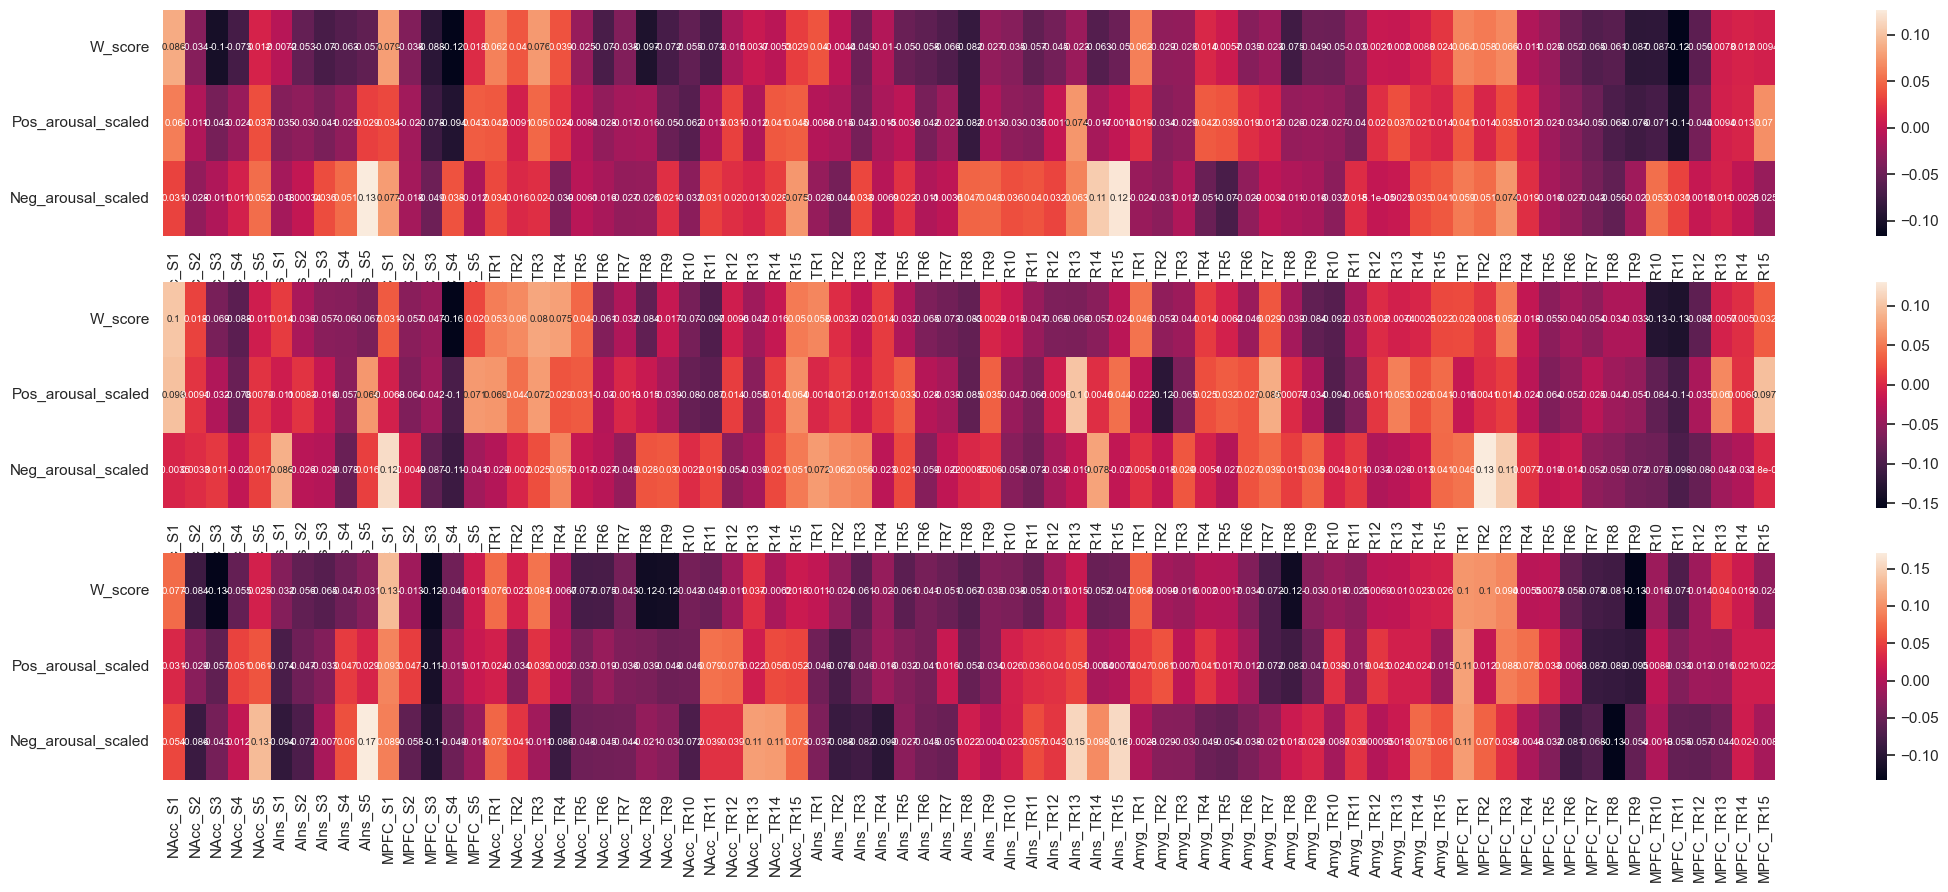

In [43]:
relevant_columns1 = ['W_score', 'Pos_arousal_scaled', 'Neg_arousal_scaled', #'F_score_scaled', 'A_score_scaled',
                     'NAcc_S1', "NAcc_S2", "NAcc_S3", "NAcc_S4", "NAcc_S5", "AIns_S1", "AIns_S2", "AIns_S3", "AIns_S4", "AIns_S5",
                     #'Amyg_S1', 'Amyg_S2', 'Amyg_S3', 'Amyg_S4', 'Amyg_S5', 
                     'MPFC_S1', 'MPFC_S2', 'MPFC_S3', 'MPFC_S4', 'MPFC_S5',
                     #'NAcc_AVG', 'AIns_AVG', 'Amyg_AVG', 'MPFC_AVG',
                     'NAcc_TR1', 'NAcc_TR2', 'NAcc_TR3', 'NAcc_TR4', 'NAcc_TR5', 'NAcc_TR6', 'NAcc_TR7', 'NAcc_TR8', 
                     'NAcc_TR9', 'NAcc_TR10', 'NAcc_TR11', 'NAcc_TR12', 'NAcc_TR13', 'NAcc_TR14', 'NAcc_TR15', #'NAcc_TR16',
                     #'NAcc_TR17', #'NAcc_TR18',
                     'AIns_TR1', 'AIns_TR2', 'AIns_TR3', 'AIns_TR4', 'AIns_TR5', 'AIns_TR6', 'AIns_TR7', 'AIns_TR8',
                     'AIns_TR9', 'AIns_TR10', 'AIns_TR11', 'AIns_TR12', 'AIns_TR13', 'AIns_TR14', 'AIns_TR15', 
                     'Amyg_TR1',
                     'Amyg_TR2', 'Amyg_TR3', 'Amyg_TR4', 'Amyg_TR5', 'Amyg_TR6', 'Amyg_TR7', 'Amyg_TR8', 'Amyg_TR9', 'Amyg_TR10', 
                     'Amyg_TR11', 'Amyg_TR12', 'Amyg_TR13', 'Amyg_TR14', 'Amyg_TR15',  
                     'MPFC_TR1', 'MPFC_TR2', 
                     'MPFC_TR3', 'MPFC_TR4', 
                     'MPFC_TR5', 'MPFC_TR6', 'MPFC_TR7', 'MPFC_TR8', 'MPFC_TR9', 'MPFC_TR10','MPFC_TR11', 'MPFC_TR12', 'MPFC_TR13', 
                     'MPFC_TR14', 'MPFC_TR15', #'MPFC_TR16', 'MPFC_TR17', #'MPFC_TR18'
                     ]

relevant_columns2 = ['W_score', 'Pos_arousal_scaled', 'Neg_arousal_scaled', #'F_score_scaled', 'A_score_scaled',
                     'NAcc_max', 'AIns_max', 'Amyg_max', 'MPFC_max', 'NAcc_DP', 'AIns_DP', 'Amyg_DP', 'MPFC_DP', 'NAcc_DPy', 
                     'AIns_DPy', 'Amyg_DPy', 'MPFC_DPy', 
                     'NAcc_DP2', 'AIns_DP2', 'Amyg_DP2', 'MPFC_DP2', 'NAcc_DPy2', 'AIns_DPy2', 'Amyg_DPy2', 'MPFC_DPy2', 'NAcc_AvgP', 'AIns_AvgP', 'Amyg_AvgP',
                    'MPFC_AvgP', 'NAcc_AvgPy', 'AIns_AvgPy', 'Amyg_AvgPy', 
                     'MPFC_AvgPy', 'NAcc_AvgP2', 'AIns_AvgP2', 'Amyg_AvgP2',
                     'MPFC_AvgP2', 'NAcc_AvgPy2', 'AIns_AvgPy2', 'Amyg_AvgPy2', 'MPFC_AvgPy2', 
                     #'NAcc_STD', 'AIns_STD', 'Amyg_STD', 'MPFC_STD', 'NAcc_STDy', 'AIns_STDy', 'Amyg_STDy', 'MPFC_STDy',
                     #'NAcc_STD2', 'AIns_STD2', 'Amyg_STD2', 'MPFC_STD2', 'NAcc_STDy2', 'AIns_STDy2', 'Amyg_STDy2', 'MPFC_STDy2'
                     "NAcc_PS2", "AIns_PS2", "Amyg_PS2", "MPFC_PS2", "NAcc_PS3", "AIns_PS3", "Amyg_PS3", "MPFC_PS3",
                        "NAcc_PSy2", "AIns_PSy2", "Amyg_PSy2", "MPFC_PSy2", "NAcc_PSy3", "AIns_PSy3", "Amyg_PSy3", "MPFC_PSy3",
                        #"NAcc_PA2", "AIns_PA2", "Amyg_PA2", "MPFC_PA2", "NAcc_PA3", "AIns_PA3", "Amyg_PA3", "MPFC_PA3",
                        #"NAcc_PAy2", "AIns_PAy2", "Amyg_PAy2", "MPFC_PAy2", "NAcc_PAy3", "AIns_PAy3", "Amyg_PAy3", "MPFC_PAy3",
                        #"NAcc_P_STD1", "AIns_P_STD1", "Amyg_P_STD1", "MPFC_P_STD1", "NAcc_YES_P_STD1", "AIns_YES_P_STD1", "Amyg_YES_P_STD1", "MPFC_YES_P_STD1",
                        #"NAcc_P_STD2", "AIns_P_STD2", "Amyg_P_STD2", "MPFC_P_STD2", "NAcc_YES_P_STD2", "AIns_YES_P_STD2", "Amyg_YES_P_STD2", "MPFC_YES_P_STD2",
                        #"NAcc_P_STD3", "AIns_P_STD3", "Amyg_P_STD3", "MPFC_P_STD3", "NAcc_YES_P_STD3", "AIns_YES_P_STD3", "Amyg_YES_P_STD3", "MPFC_YES_P_STD3"
                     #"NAcc_IP1", "AIns_IP1", "Amyg_IP1", "MPFC_IP1", "NAcc_IP2", "AIns_IP2", "Amyg_IP2", "MPFC_IP2", "NAcc_IP3", "AIns_IP3", "Amyg_IP3", "MPFC_IP3"
                        ]

# Separate by genre.
all_participants_proccessed_peaks_comedy_df = all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Type"] == "Comedy"]
all_participants_proccessed_peaks_horror_df = all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Type"] == "Horror"]

# Select relevant columns.
Both_display_matrix1 = all_participants_proccessed_peaks_df[relevant_columns1]
Both_display_matrix2 = all_participants_proccessed_peaks_df[relevant_columns2]

Comedy_display_matrix1 = all_participants_proccessed_peaks_comedy_df[relevant_columns1]
Comedy_display_matrix2 = all_participants_proccessed_peaks_comedy_df[relevant_columns2]

Horror_display_matrix1 = all_participants_proccessed_peaks_horror_df[relevant_columns1]
Horror_display_matrix2 = all_participants_proccessed_peaks_horror_df[relevant_columns2]

# Drop nan values.
print("Both_display_matrix1 shape before dropping nan values: ", Both_display_matrix1.shape)
#Both_display_matrix1 = Both_display_matrix1.dropna()
#Both_display_matrix2 = Both_display_matrix2.dropna()
print("Both_display_matrix1 shape after dropping nan values: ", Both_display_matrix1.shape)

#Comedy_display_matrix1 = Comedy_display_matrix1.dropna()
#Comedy_display_matrix2 = Comedy_display_matrix2.dropna()

#Horror_display_matrix1 = Horror_display_matrix1.dropna()
#Horror_display_matrix2 = Horror_display_matrix2.dropna()

# Correlate the data.
Both_corr1 = Both_display_matrix1.corr()
Both_corr2 = Both_display_matrix2.corr()

Comedy_corr1 = Comedy_display_matrix1.corr()
Comedy_corr2 = Comedy_display_matrix2.corr()

Horror_corr1 = Horror_display_matrix1.corr()
Horror_corr2 = Horror_display_matrix2.corr()

fig, axs = plt.subplots(3, 1, figsize=(26, 10), sharex=False) 

sns.heatmap(Both_corr1.iloc[:3, 3:], ax=axs[0], annot=True, annot_kws={'size':7})

sns.heatmap(Comedy_corr1.iloc[:3, 3:], ax=axs[1], annot=True, annot_kws={'size':7})

sns.heatmap(Horror_corr1.iloc[:3, 3:], ax=axs[2], annot=True, annot_kws={'size':7})






<Axes: >

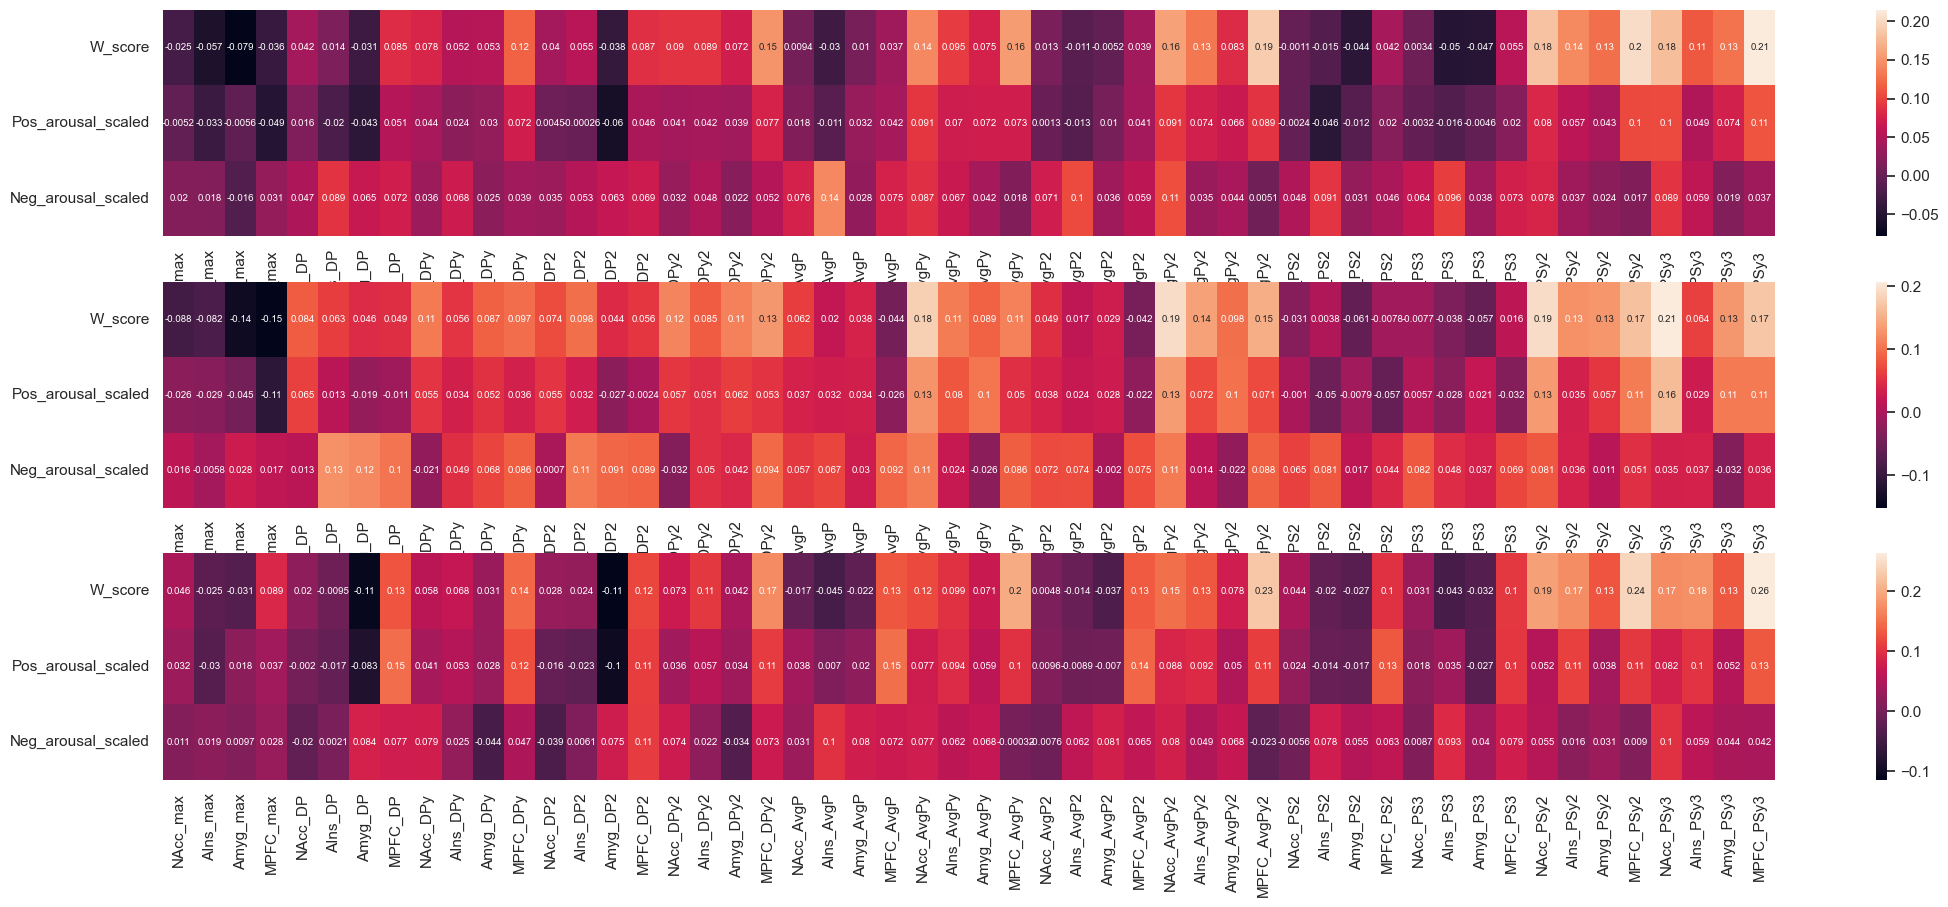

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(26, 10), sharex=False) 

sns.heatmap(Both_corr2.iloc[:3, 3:], ax=axs[0], annot=True, annot_kws={'size':7})

sns.heatmap(Comedy_corr2.iloc[:3, 3:], ax=axs[1], annot=True, annot_kws={'size':7})

sns.heatmap(Horror_corr2.iloc[:3, 3:], ax=axs[2], annot=True, annot_kws={'size':7})

In [45]:
# aggregate_df = all_participants_proccessed_peaks_df.groupby("Trailer", as_index=False, dropna=False)#.mean()
# aggregate_means_df = aggregate_df.mean(skip) 
# aggregate_means_df

In [46]:
# Get average neural signals for each trailer. 
#aggregate_df = all_participants_proccessed_peaks_df.groupby("Trailer", as_index=False, dropna=False).mean()
aggregate_df = all_participants_proccessed_peaks_df.groupby("Trailer", as_index=False, dropna=True).mean()

aggregate_df.reset_index(inplace=True)

all_participants_proccessed_peaks_comedy_df = all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Type"] == "Comedy"]
all_participants_proccessed_peaks_horror_df = all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Type"] == "Horror"]

aggregate_comedy_df = all_participants_proccessed_peaks_comedy_df.groupby("Trailer", as_index=False, dropna=True).mean()
aggregate_comedy_df.reset_index(inplace=True)

aggregate_horror_df = all_participants_proccessed_peaks_horror_df.groupby("Trailer", as_index=False, dropna=True).mean()
aggregate_horror_df.reset_index(inplace=True)

comedy_trailers_list = all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Type"] == "Comedy"]["Trailer"].unique().tolist()
horror_trailers_list = all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Type"] == "Horror"]["Trailer"].unique().tolist()

# Add genre of movie. 
aggregate_df["Type"] = aggregate_df["Trailer"].apply(lambda x: "Comedy" if x in comedy_trailers_list else "Horror")



In [47]:
#aggregate_metrics_df3

In [48]:
# Read aggregate metrics dataframe. 
#aggregate_metricts_path = "/Users/luisalvarez/Documents/SpanLab/Aggregate_metrics_final.csv"
#aggregate_metricts_path2 = "/Users/luisalvarez/Documents/SpanLab/Aggregate_metrics3.csv"
aggregate_metricts_path3 = "/Users/luisalvarez/Documents/SpanLab/fmrimatch_aggregate_updated.csv"

#aggregate_metrics_df = pd.read_csv(aggregate_metricts_path)#.dropna(subset=['Gross_World_num'], inplace=True)
#aggregate_metrics_df2 = pd.read_csv(aggregate_metricts_path2)
aggregate_metrics_df3 = pd.read_csv(aggregate_metricts_path3)

# Remove nan.
#aggregate_metrics_df.dropna(subset=['Gross_World_num'], inplace=True)
#aggregate_metrics_df2.dropna(subset=['NumT_WK2'], inplace=True)
aggregate_metrics_df3.dropna(subset=['title'], inplace=True)

# print(aggregate_metrics_df.shape)
# print(aggregate_metrics_df2.shape)
print(aggregate_metrics_df3.shape)

# aggregate_metrics_df.reset_index(inplace=True)
# aggregate_metrics_df2.reset_index(inplace=True)
# aggregate_metrics_df3.
# aggregate_metrics_df=aggregate_metrics_df.join(aggregate_metrics_df2.set_index('label'), on='label', rsuffix='2')
# aggregate_metrics_df=aggregate_metrics_df.join(aggregate_metrics_df3.set_index('label'), on='label', rsuffix='3')
# #print(aggregate_metrics_df.shape)
# aggregate_metrics_df.head(30)

(32, 19)


In [49]:
# Join both dataframes.
#aggregate_combined_df = aggregate_df.join(aggregate_metrics_df3, lsuffix='Trailer', rsuffix='label')
#aggregate_combined_df = aggregate_df.set_index('Trailer').join(aggregate_metrics_df3.set_index('label'), lsuffix='Trailer', rsuffix='label')

aggregate_combined_df = pd.merge(aggregate_df, aggregate_metrics_df3, left_on='Trailer', right_on='label', how='left')
aggregate_comedy_metrics_df = pd.merge(aggregate_comedy_df, aggregate_metrics_df3, left_on='Trailer', right_on='label', how='left')
aggregate_horror_metrics_df = pd.merge(aggregate_horror_df, aggregate_metrics_df3, left_on='Trailer', right_on='label', how='left')

#aggregate_comedy_metrics_df = aggregate_comedy_df.join(aggregate_metrics_df3, lsuffix='Trailer', rsuffix='label')
#aggregate_horror_metrics_df = aggregate_horror_df.join(aggregate_metrics_df3, lsuffix='Trailer', rsuffix='label')

# aggregate_combined_df.dropna(subset=['title'], inplace=True)
# aggregate_comedy_metrics_df.dropna(subset=['title'], inplace=True)
# aggregate_horror_metrics_df.dropna(subset=['title'], inplace=True)
#aggregate_comedy_metrics_df.dropna(subset=['DG_WK4_Ulabel'], inplace=True)
#

aggregate_combined_df.reset_index(inplace=True)
aggregate_comedy_metrics_df.reset_index(inplace=True)
aggregate_horror_metrics_df.reset_index(inplace=True)

aggregate_combined_col = aggregate_combined_df.columns

print("The shape of the combined dataframe is: ", aggregate_combined_df.shape)

columns_to_drop = ["Onset", "Offset", 'index2', 'title2', 'year2', 'Release_date', 'genre2', 
                   'released', 'url', 'genre3', 
                   #'NAcc_pos_peak','AIns_pos_peak', 'MPFC_pos_peak',
       #'NAcc_neg_peak', 'AIns_neg_peak',
       #'MPFC_neg_peak', #'NAcc_slope_peak', 'AIns_slope_peak',
       #'MPFC_slope_peak', 'NAcc_slope_peak_avg', 'AIns_slope_peak_avg', 'MPFC_slope_peak_avg', 
       #'NAcc_narrow_slope_peak', 'AIns_narrow_slope_peak', 'MPFC_narrow_slope_peak',
       #'NAcc_narrow_slope_peak_avg', 'AIns_narrow_slope_peak_avg', 'MPFC_narrow_slope_peak_avg', 
       #'NAcc_delta_peak', 'AIns_delta_peak',
       #'MPFC_delta_peak', 'NAcc_delta_peak_avg', 'AIns_delta_peak_avg','MPFC_delta_peak_avg', 
       #'NAcc_narrow_delta_peak', 'AIns_narrow_delta_peak', 'MPFC_narrow_delta_peak',
       #'NAcc_narrow_delta_peak_avg', 'AIns_narrow_delta_peak_avg', 'MPFC_narrow_delta_peak_avg', 
       'year', 'Release time', 'genre', 'released3', 'url3',
       'released (1 = yes, 0 = no)', 'url to trailer', #'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 39', 'Unnamed: 40'
       'The tool used to get the thumbnail: https://youtu.be/otNh9bTjXWg?si=NJaRcikG3tZUpNBl , size of thumbnail 640*480',
       'downloaded', 'video trimmed', 'audio extracted', 'budget']

# Drop columns that are not needed.
#aggregate_combined_df.drop(columns=columns_to_drop, inplace=True) 


print("After dropping columns, the shape of the combined dataframe is: ", aggregate_combined_df.shape)

# Calculate first month gross for US.
#aggregate_combined_df["Gross_US_M1"] = aggregate_combined_df["Gross_US_W4_num"] 
#aggregate_combined_df["Theaters_US_M1"] = aggregate_combined_df["Theaters_US_W1_num"] + aggregate_combined_df["Theaters_US_W2_num"] + aggregate_combined_df["Theaters_US_W3_num"] + aggregate_combined_df["Theaters_US_W4_num"]
aggregate_combined_df["Gross_M1_updated"] = aggregate_combined_df["DG_WK1_U"] + aggregate_combined_df["DG_WK2_U"] + aggregate_combined_df["DG_WK3_U"] + aggregate_combined_df["DG_WK4_U"]
#aggregate_combined_df["Gross_M1_updated"] = aggregate_combined_df["DG_WK1"] + aggregate_combined_df["DG_WK2"] + aggregate_combined_df["DG_WK3"] + aggregate_combined_df["DG_WK4"]
aggregate_combined_df["Gross_M1_updated_log"] = np.log(aggregate_combined_df["Gross_M1_updated"])
aggregate_combined_df["Gross_M1_updated_rank"] = aggregate_combined_df["Gross_M1_updated"].rank()

#aggregate_comedy_metrics_df["Gross_US_M1"] = aggregate_comedy_metrics_df["Gross_US_W4_num"]
#aggregate_comedy_metrics_df["Theaters_US_M1"] = aggregate_comedy_metrics_df["Theaters_US_W1_num"] + aggregate_comedy_metrics_df["Theaters_US_W2_num"] + aggregate_comedy_metrics_df["Theaters_US_W3_num"] + aggregate_comedy_metrics_df["Theaters_US_W4_num"]
aggregate_comedy_metrics_df["Gross_M1_updated"] = aggregate_comedy_metrics_df["DG_WK1_U"] + aggregate_comedy_metrics_df["DG_WK2_U"] + aggregate_comedy_metrics_df["DG_WK3_U"] + aggregate_comedy_metrics_df["DG_WK4_U"]
#aggregate_comedy_metrics_df["Gross_M1_updated"] = aggregate_comedy_metrics_df["DG_WK1"] + aggregate_comedy_metrics_df["DG_WK2"] + aggregate_comedy_metrics_df["DG_WK3"] + aggregate_comedy_metrics_df["DG_WK4"]
aggregate_comedy_metrics_df["Gross_M1_updated_log"] = np.log(aggregate_comedy_metrics_df["Gross_M1_updated"])
aggregate_comedy_metrics_df["Gross_M1_updated_rank"] = aggregate_comedy_metrics_df["Gross_M1_updated"].rank()

#aggregate_horror_metrics_df["Gross_US_M1"] = aggregate_horror_metrics_df["Gross_US_W4_num"]
#aggregate_horror_metrics_df["Theaters_US_M1"] = aggregate_horror_metrics_df["Theaters_US_W1_num"] + aggregate_horror_metrics_df["Theaters_US_W2_num"] + aggregate_horror_metrics_df["Theaters_US_W3_num"] + aggregate_horror_metrics_df["Theaters_US_W4_num"]
aggregate_horror_metrics_df["Gross_M1_updated"] = aggregate_horror_metrics_df["DG_WK1_U"] + aggregate_horror_metrics_df["DG_WK2_U"] + aggregate_horror_metrics_df["DG_WK3_U"] + aggregate_horror_metrics_df["DG_WK4_U"]
#aggregate_horror_metrics_df["Gross_M1_updated"] = aggregate_horror_metrics_df["DG_WK1"] + aggregate_horror_metrics_df["DG_WK2"] + aggregate_horror_metrics_df["DG_WK3"] + aggregate_horror_metrics_df["DG_WK4"]
aggregate_horror_metrics_df["Gross_M1_updated_log"] = np.log(aggregate_horror_metrics_df["Gross_M1_updated"])
aggregate_horror_metrics_df["Gross_M1_updated_rank"] = aggregate_horror_metrics_df["Gross_M1_updated"].rank()

aggregate_combined_df.head(30)
aggregate_comedy_metrics_df.head(30)

The shape of the combined dataframe is:  (32, 253)
After dropping columns, the shape of the combined dataframe is:  (32, 253)


,level_0,index,Trailer,W_score,F_score,A_score,Pos_arousal,Neg_arousal,W_score_scaled,F_score_scaled,...,NumT_WK1_U,DG_WK2_U,NumT_WK2_U,DG_WK3_U,NumT_WK3_U,DG_WK4_U,NumT_WK4_U,Gross_M1_updated,Gross_M1_updated_log,Gross_M1_updated_rank
0,0,0,rc1,3.033333,3.500000,2.500000,4.242641,-0.707107,0.753042,0.994543,...,2820.0,4126183.0,2820.0,590993.0,335.0,138616.0,66.0,12897789.0,16.372566,6.0
1,1,1,rc10,2.206897,3.034483,1.966667,3.559917,-0.731490,-0.061221,0.518493,...,3175.0,3389040.0,3176.0,1276610.0,1574.0,435645.0,553.0,12660865.0,16.354026,5.0
2,2,2,rc11,2.066667,3.300000,1.766667,3.582674,-1.084230,-0.213625,0.794543,...,3650.0,6931615.0,3678.0,4405550.0,3078.0,1688985.0,1474.0,26897765.0,17.107554,10.0
3,3,3,rc12,1.866667,2.931034,1.700000,3.267321,-0.877788,-0.413625,0.415044,...,2464.0,3192716.0,2464.0,1309700.0,960.0,455065.0,273.0,11681574.0,16.273523,4.0
4,4,4,rc2,1.933333,2.900000,1.733333,3.276261,-0.824958,-0.346958,0.394543,...,3912.0,9678153.0,3939.0,5969470.0,3119.0,2856102.0,2397.0,37473383.0,17.439141,11.0
5,5,5,rc3,2.566667,3.068966,2.000000,3.608683,-0.731490,0.286375,0.564989,...,4.0,6137646.0,637.0,20123123.0,3802.0,12956615.0,3802.0,39302864.0,17.486808,12.0
6,6,6,rc4,3.233333,3.666667,2.533333,4.384062,-0.801388,0.953042,1.161210,...,4099.0,38304475.0,4115.0,20436665.0,3977.0,22381420.0,3919.0,87225415.0,18.284006,14.0
7,7,7,rc5,2.566667,3.233333,2.310345,3.925662,-0.658341,0.286375,0.727876,...,3223.0,6734995.0,3232.0,3833775.0,2486.0,1191435.0,1500.0,23236435.0,16.961232,9.0
8,8,8,rc6,2.200000,2.900000,1.900000,3.394113,-0.707107,-0.080291,0.394543,...,3030.0,4463030.0,3039.0,2228870.0,1917.0,947325.0,1121.0,15199130.0,16.536749,7.0
9,9,9,rc7,1.966667,3.133333,1.633333,3.370542,-1.060660,-0.313625,0.627876,...,3508.0,5086750.0,3513.0,1664920.0,1339.0,397880.0,382.0,17274770.0,16.664758,8.0


In [50]:
#aggregate_comedy_df.shape
#aggregate_combined_df[["Trailer", "DG_WK1_U", "DG_WK2_U", "DG_WK3_U", "DG_WK4_U", "Gross_M1_updated", "Gross_M1_updated_rank"]]

In [51]:
#aggregate_combined_df[["Trailer", "Gross_M1_updated", "NAcc_TR3"]]

In [52]:
# movies_to_drop = ["uc1", "uc2", 'uc3', 'uc4', 'uh1', 'uh2', 'uh3', 'uh4'] 
# comedies_to_drop = ["uc1", "uc2", 'uc3', 'uc4']
# horrors_to_drop = ['uh1', 'uh2', 'uh3', 'uh4']

# aggregate_combined_df = aggregate_combined_df[~aggregate_combined_df["Trailer"].isin(movies_to_drop)]
# aggregate_comedy_metrics_df = aggregate_comedy_metrics_df[~aggregate_comedy_metrics_df["Trailer"].isin(comedies_to_drop)]
# aggregate_horror_metrics_df = aggregate_horror_metrics_df[~aggregate_horror_metrics_df["Trailer"].isin(horrors_to_drop)]



In [53]:
aggregate_combined_df.dropna(subset=["Gross_M1_updated"], inplace=True)
aggregate_combined_df.shape

(30, 256)

In [54]:


aggregate_combined_df.to_csv("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/NeuroAgg_AFNI_processed.csv", index=False)

<Axes: >

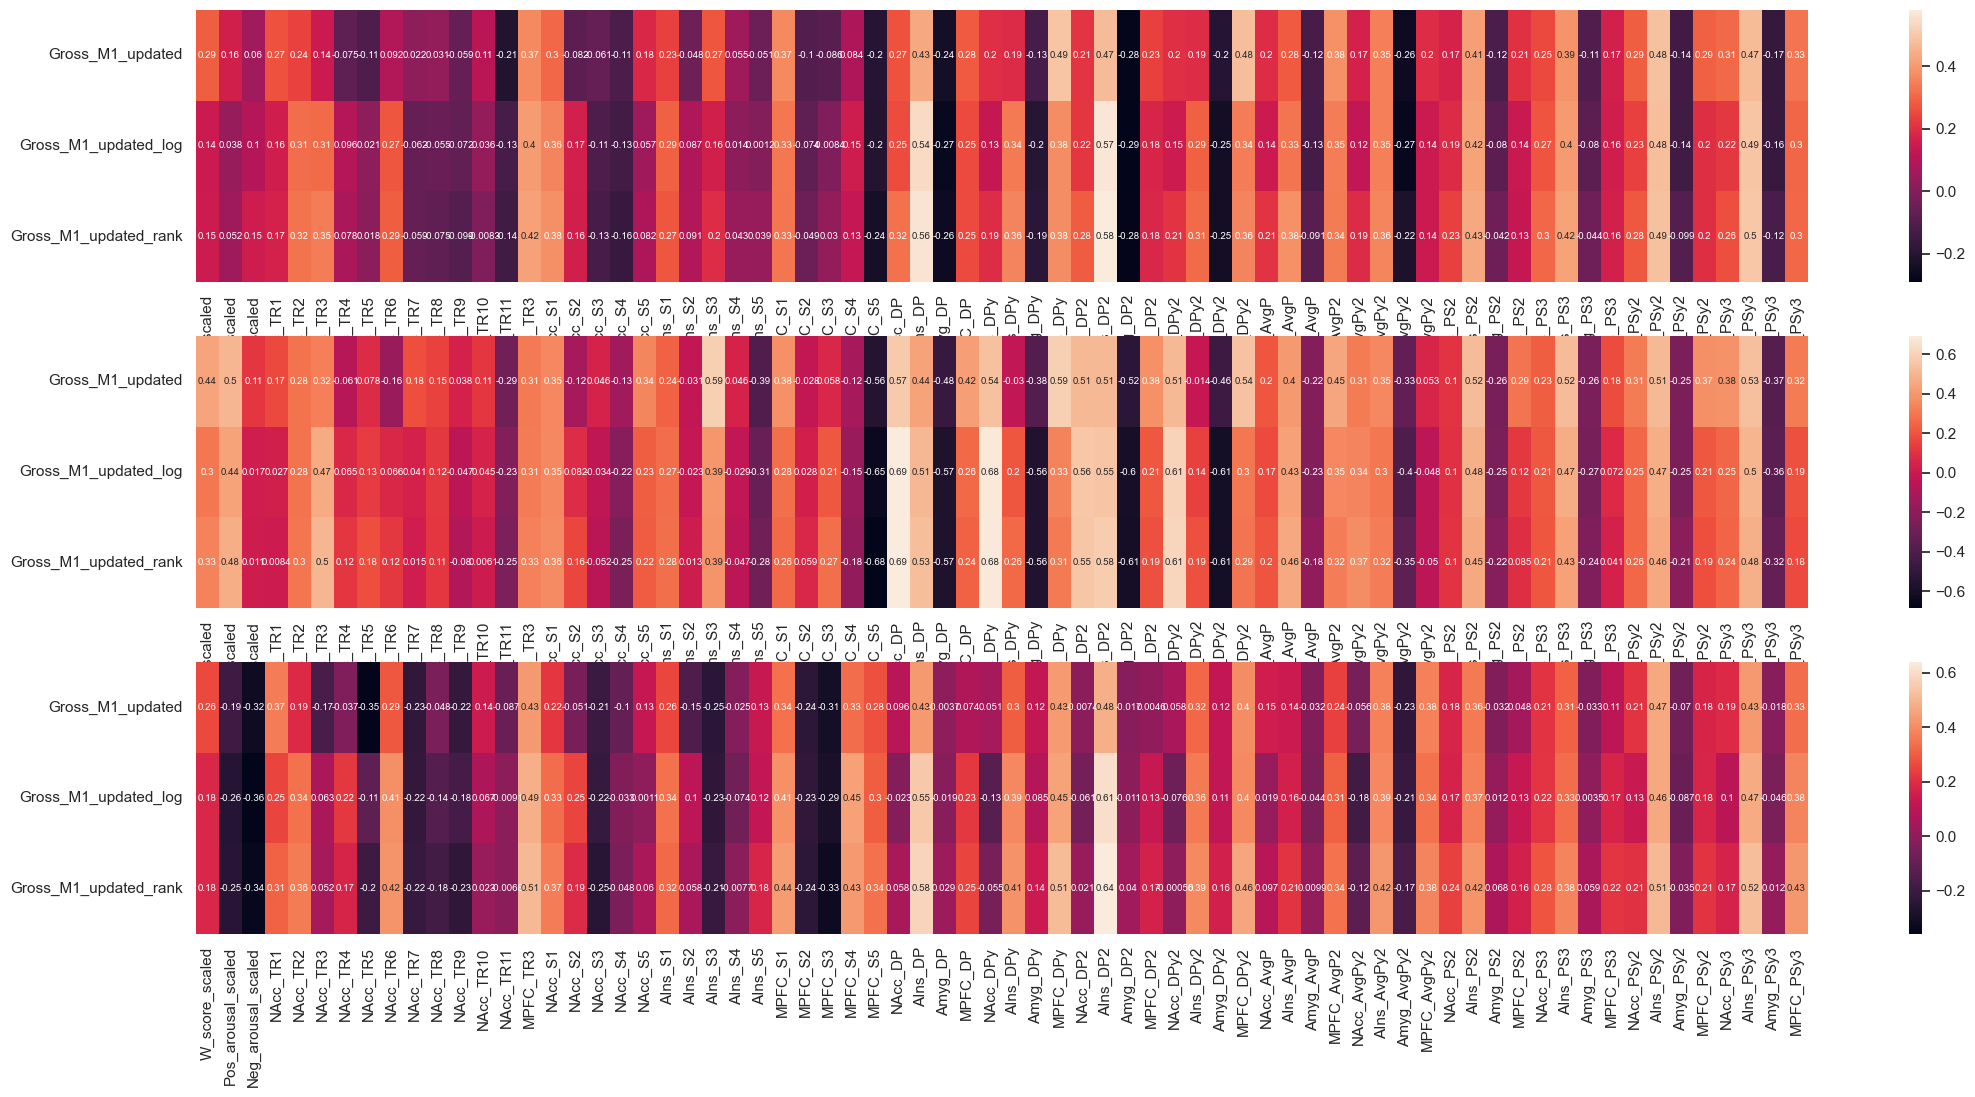

In [55]:
relevant_agg_cols = ["Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank", 'W_score_scaled', 'Pos_arousal_scaled', 'Neg_arousal_scaled',
                     
                     "NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", 
                     "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "MPFC_TR3", 
                     #"NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15", #"NAcc_TR16", #"NAcc_17", 
                     #"NAcc_18", "NAcc_19", "NAcc_20", "NAcc_21", "NAcc_22", "NAcc_23", "NAcc_24",
                    'NAcc_S1', "NAcc_S2", "NAcc_S3", "NAcc_S4", "NAcc_S5", "AIns_S1", "AIns_S2", "AIns_S3", "AIns_S4", "AIns_S5",
                     #'Amyg_S1', 'Amyg_S2', 'Amyg_S3', 'Amyg_S4', 'Amyg_S5', 
                     'MPFC_S1', 'MPFC_S2', 'MPFC_S3', 'MPFC_S4', 'MPFC_S5',
                      #'NAcc_max', 'AIns_max', 'Amyg_max', 'MPFC_max', 
                      'NAcc_DP', 'AIns_DP', 'Amyg_DP', 'MPFC_DP', 'NAcc_DPy', 
                     'AIns_DPy', 'Amyg_DPy', 'MPFC_DPy', 'NAcc_DP2', 'AIns_DP2',
                     'Amyg_DP2', 'MPFC_DP2', 'NAcc_DPy2', 'AIns_DPy2', 'Amyg_DPy2', 'MPFC_DPy2', 'NAcc_AvgP', 'AIns_AvgP', 'Amyg_AvgP', 
                     #'MPFC_AvgP', 'NAcc_AvgPy', 'AIns_AvgPy', 'Amyg_AvgPy', 
                     #'MPFC_AvgPy', 'NAcc_AvgP2', 'AIns_AvgP2', 'Amyg_AvgP2',
                     'MPFC_AvgP2', 'NAcc_AvgPy2', 'AIns_AvgPy2', 'Amyg_AvgPy2', 'MPFC_AvgPy2',
                     "NAcc_PS2", "AIns_PS2", "Amyg_PS2", "MPFC_PS2", "NAcc_PS3", "AIns_PS3", "Amyg_PS3", "MPFC_PS3",
                     "NAcc_PSy2", "AIns_PSy2", "Amyg_PSy2", "MPFC_PSy2", "NAcc_PSy3", "AIns_PSy3", "Amyg_PSy3", "MPFC_PSy3",
                     #"NAcc_PA2", "AIns_PA2", "Amyg_PA2", "MPFC_PA2", "NAcc_PA3", "AIns_PA3", "Amyg_PA3", "MPFC_PA3",
                     #"NAcc_PAy2", "AIns_PAy2", "Amyg_PAy2", "MPFC_PAy2", "NAcc_PAy3", "AIns_PAy3", "Amyg_PAy3", "MPFC_PAy3"
                     #"NAcc_P_STD1", "AIns_P_STD1", "Amyg_P_STD1", "MPFC_P_STD1", "NAcc_YES_P_STD1", "AIns_YES_P_STD1", "Amyg_YES_P_STD1", "MPFC_YES_P_STD1",
                     #"NAcc_P_STD2", "AIns_P_STD2", "Amyg_P_STD2", "MPFC_P_STD2", "NAcc_YES_P_STD2", "AIns_YES_P_STD2", "Amyg_YES_P_STD2", "MPFC_YES_P_STD2",
                     #"NAcc_IP1", "AIns_IP1", "Amyg_IP1", "MPFC_IP1", "NAcc_IP2", "AIns_IP2", "Amyg_IP2", "MPFC_IP2", "NAcc_IP3", "AIns_IP3", "Amyg_IP3", "MPFC_IP3"
                     ]

# aggregate_comedy_matrix = aggregate_combined_df.loc[aggregate_combined_df["Type"] == "Comedy"].copy()
# aggregate_horror_matrix = aggregate_combined_df.loc[aggregate_combined_df["Type"] == "Horror"].copy()

aggregate_comedy_df = aggregate_combined_df.loc[aggregate_combined_df["Type"] == "Comedy"].copy()
aggregate_horror_df = aggregate_combined_df.loc[aggregate_combined_df["Type"] == "Horror"].copy()

# Select relevant columns.
aggregate_combined_matrix = aggregate_combined_df[relevant_agg_cols]
aggregate_comedy_matrix = aggregate_comedy_df[relevant_agg_cols]
aggregate_horror_matrix = aggregate_horror_df[relevant_agg_cols]

# Drop nan values.
#aggregate_combined_matrix = aggregate_combined_matrix.dropna()
#aggregate_comedy_matrix = aggregate_comedy_matrix.dropna()
#aggregate_horror_matrix = aggregate_horror_matrix.dropna()

# Correlate the data.
aggregate_combined_corr = aggregate_combined_matrix.corr()
aggregate_comedy_corr = aggregate_comedy_matrix.corr()
aggregate_horror_corr = aggregate_horror_matrix.corr()

fig, axs = plt.subplots(3, 1, figsize=(26, 12), sharex=False)

sns.heatmap(aggregate_combined_corr.iloc[:3, 3:], ax=axs[0], annot=True, annot_kws={'size':7})

sns.heatmap(aggregate_comedy_corr.iloc[:3, 3:], ax=axs[1], annot=True, annot_kws={'size':7})

sns.heatmap(aggregate_horror_corr.iloc[:3, 3:], ax=axs[2], annot=True, annot_kws={'size':7})



<Axes: >

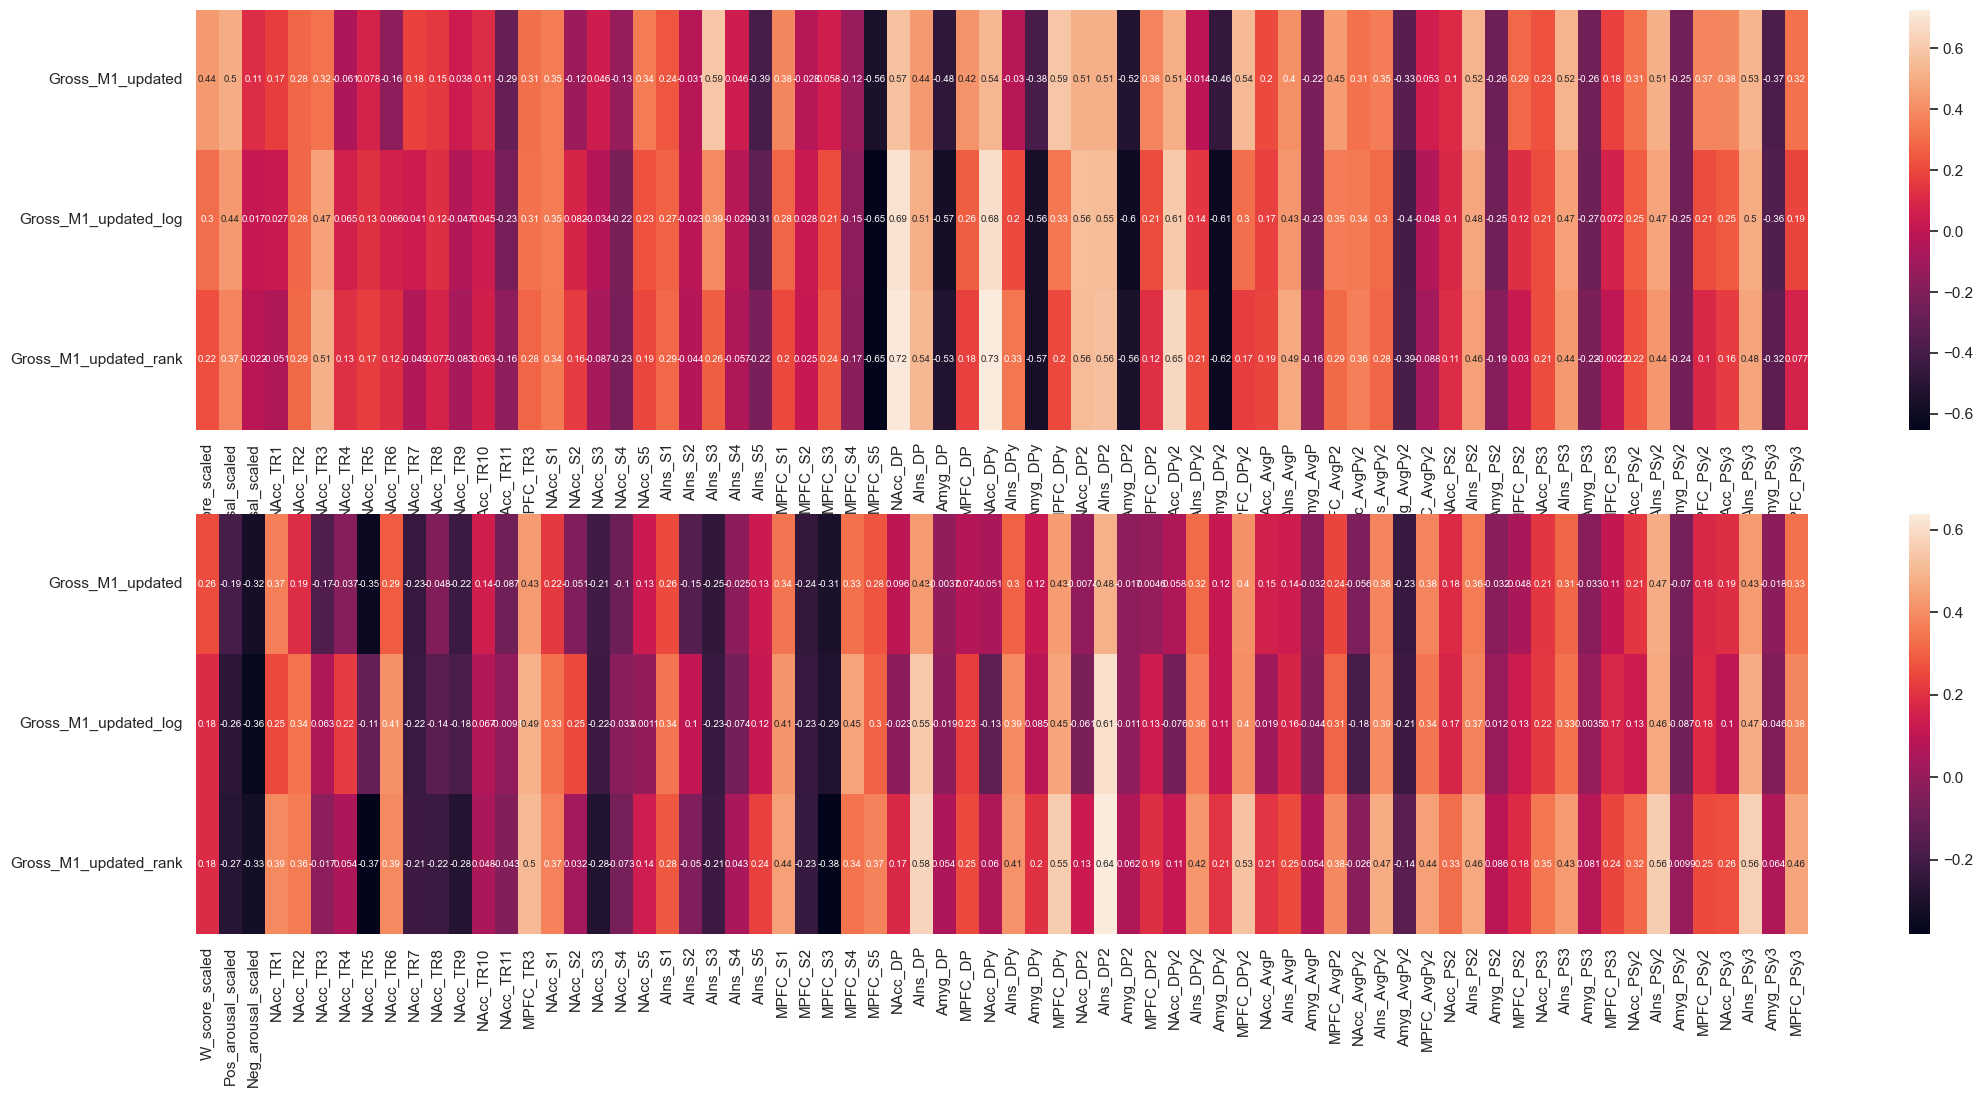

In [56]:
#DP mean(t: t+1)
#DP2 mean(t-1: t+1)  

aggregate_comedy_metrics_matrix = aggregate_comedy_metrics_df[relevant_agg_cols]
aggregate_horror_metrics_matrix = aggregate_horror_metrics_df[relevant_agg_cols]

# Drop nan values.
#aggregate_comedy_metrics_matrix = aggregate_comedy_metrics_matrix.dropna()
#aggregate_horror_metrics_matrix = aggregate_horror_metrics_matrix.dropna()

# Correlate the data.
aggregate_comedy_metrics_corr = aggregate_comedy_metrics_matrix.corr()
aggregate_horror_metrics_corr = aggregate_horror_metrics_matrix.corr()

fig, axs = plt.subplots(2, 1, figsize=(26, 12), sharex=False)

sns.heatmap(aggregate_comedy_metrics_corr.iloc[:3, 3:], ax=axs[0], annot=True, annot_kws={'size':7})

sns.heatmap(aggregate_horror_metrics_corr.iloc[:3, 3:], ax=axs[1], annot=True, annot_kws={'size':7})

In [57]:
aggregate_combined_df[aggregate_combined_df["Type"]=="Comedy"].shape

(16, 256)

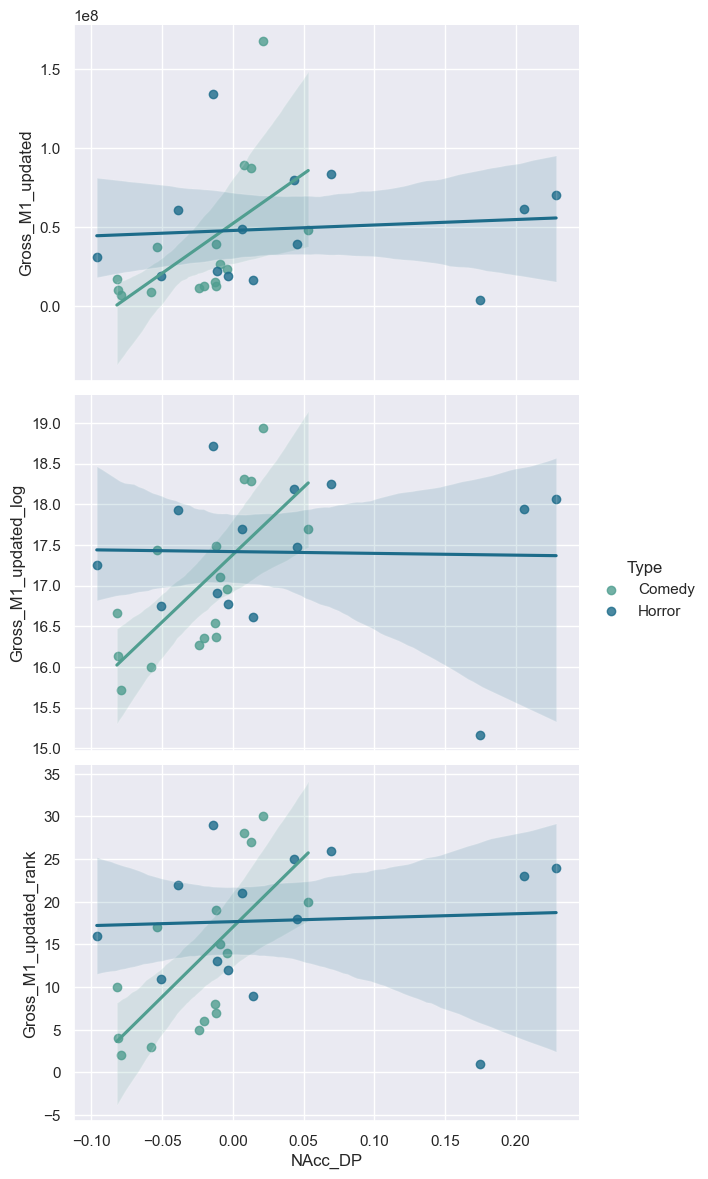

In [58]:
sns.pairplot(
      aggregate_combined_df,
      kind="reg",
      y_vars=["Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank"],
      x_vars=["NAcc_DP"],
      palette="crest",
      hue="Type",
      height=4,
      aspect=1.5)

In [59]:
all_participants_proccessed_peaks_df

,Participant,Trailer,W_score,F_score,A_score,Pos_arousal,Neg_arousal,W_score_scaled,F_score_scaled,A_score_scaled,...,Amyg_IP1,MPFC_IP1,NAcc_IP2,AIns_IP2,Amyg_IP2,MPFC_IP2,NAcc_IP3,AIns_IP3,Amyg_IP3,MPFC_IP3
0,sub-01,rh6,3.0,2.0,3.0,3.535534,0.707107,0.56250,-0.5000,0.375,...,NaN,NaN,NaN,0.577947,NaN,NaN,NaN,0.471769,NaN,NaN
1,sub-01,uh1,1.0,3.0,3.0,4.242641,0.000000,-1.43750,0.5000,0.375,...,0.190795,1.100620,0.762951,0.472833,0.144769,1.002327,0.691564,0.376794,0.119802,0.946020
2,sub-01,rc2,1.0,3.0,1.0,2.828427,-1.414214,-1.43750,0.5000,-1.625,...,0.383549,1.028239,0.797678,0.337108,0.370581,0.902604,0.762536,0.292744,0.358355,0.798806
3,sub-01,rh2,3.0,2.0,2.0,2.828427,0.000000,0.56250,-0.5000,-0.625,...,0.329867,0.613608,0.424565,0.411831,0.308072,0.569528,0.375955,0.349227,0.291524,0.547057
4,sub-01,rh1,4.0,2.0,3.0,3.535534,0.707107,1.56250,-0.5000,0.375,...,0.262646,1.096910,0.405585,0.946115,0.240004,0.910881,0.323544,0.720974,0.210065,0.809813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,sub-37,rh8,1.0,1.0,2.0,2.121320,0.707107,-1.15625,-1.1875,0.000,...,NaN,0.777718,0.306834,0.535067,NaN,0.655252,0.258618,0.454878,NaN,0.564902
956,sub-37,rc10,3.0,3.0,3.0,4.242641,0.000000,0.84375,0.8125,1.000,...,0.316190,0.397609,0.243383,0.164656,0.271825,0.349606,0.225929,0.139408,0.242737,0.304696
957,sub-37,uh3,1.0,1.0,1.0,1.414214,0.000000,-1.15625,-1.1875,-1.000,...,0.311093,NaN,0.197630,0.791262,0.304031,NaN,0.154911,0.706563,0.292026,NaN
958,sub-37,rc7,2.0,3.0,2.0,3.535534,-0.707107,-0.15625,0.8125,0.000,...,0.291207,0.879548,0.127546,0.883288,0.273998,0.797612,0.113266,0.793574,0.260443,0.746010


In [60]:


NAcc_TRs_cols = ["NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15"]
AIns_TRs_cols = ["AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15"]
MPFC_TRs_cols = ["MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15"]

# Transform the NAcc activation from long to wide format.
NAcc_long_df = pd.melt(all_participants_proccessed_peaks_df, id_vars=['Participant', 'Trailer', 'Watch_choice'], value_vars=NAcc_TRs_cols,
                       var_name='TR', value_name='Signal')

NAcc_long_df.head()

,Participant,Trailer,Watch_choice,TR,Signal
0,sub-01,rh6,Yes,NAcc_TR1,0.955701
1,sub-01,uh1,No,NAcc_TR1,0.141641
2,sub-01,rc2,No,NAcc_TR1,-1.155910
3,sub-01,rh2,Yes,NAcc_TR1,0.232092
4,sub-01,rh1,Yes,NAcc_TR1,0.085599


In [61]:

r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

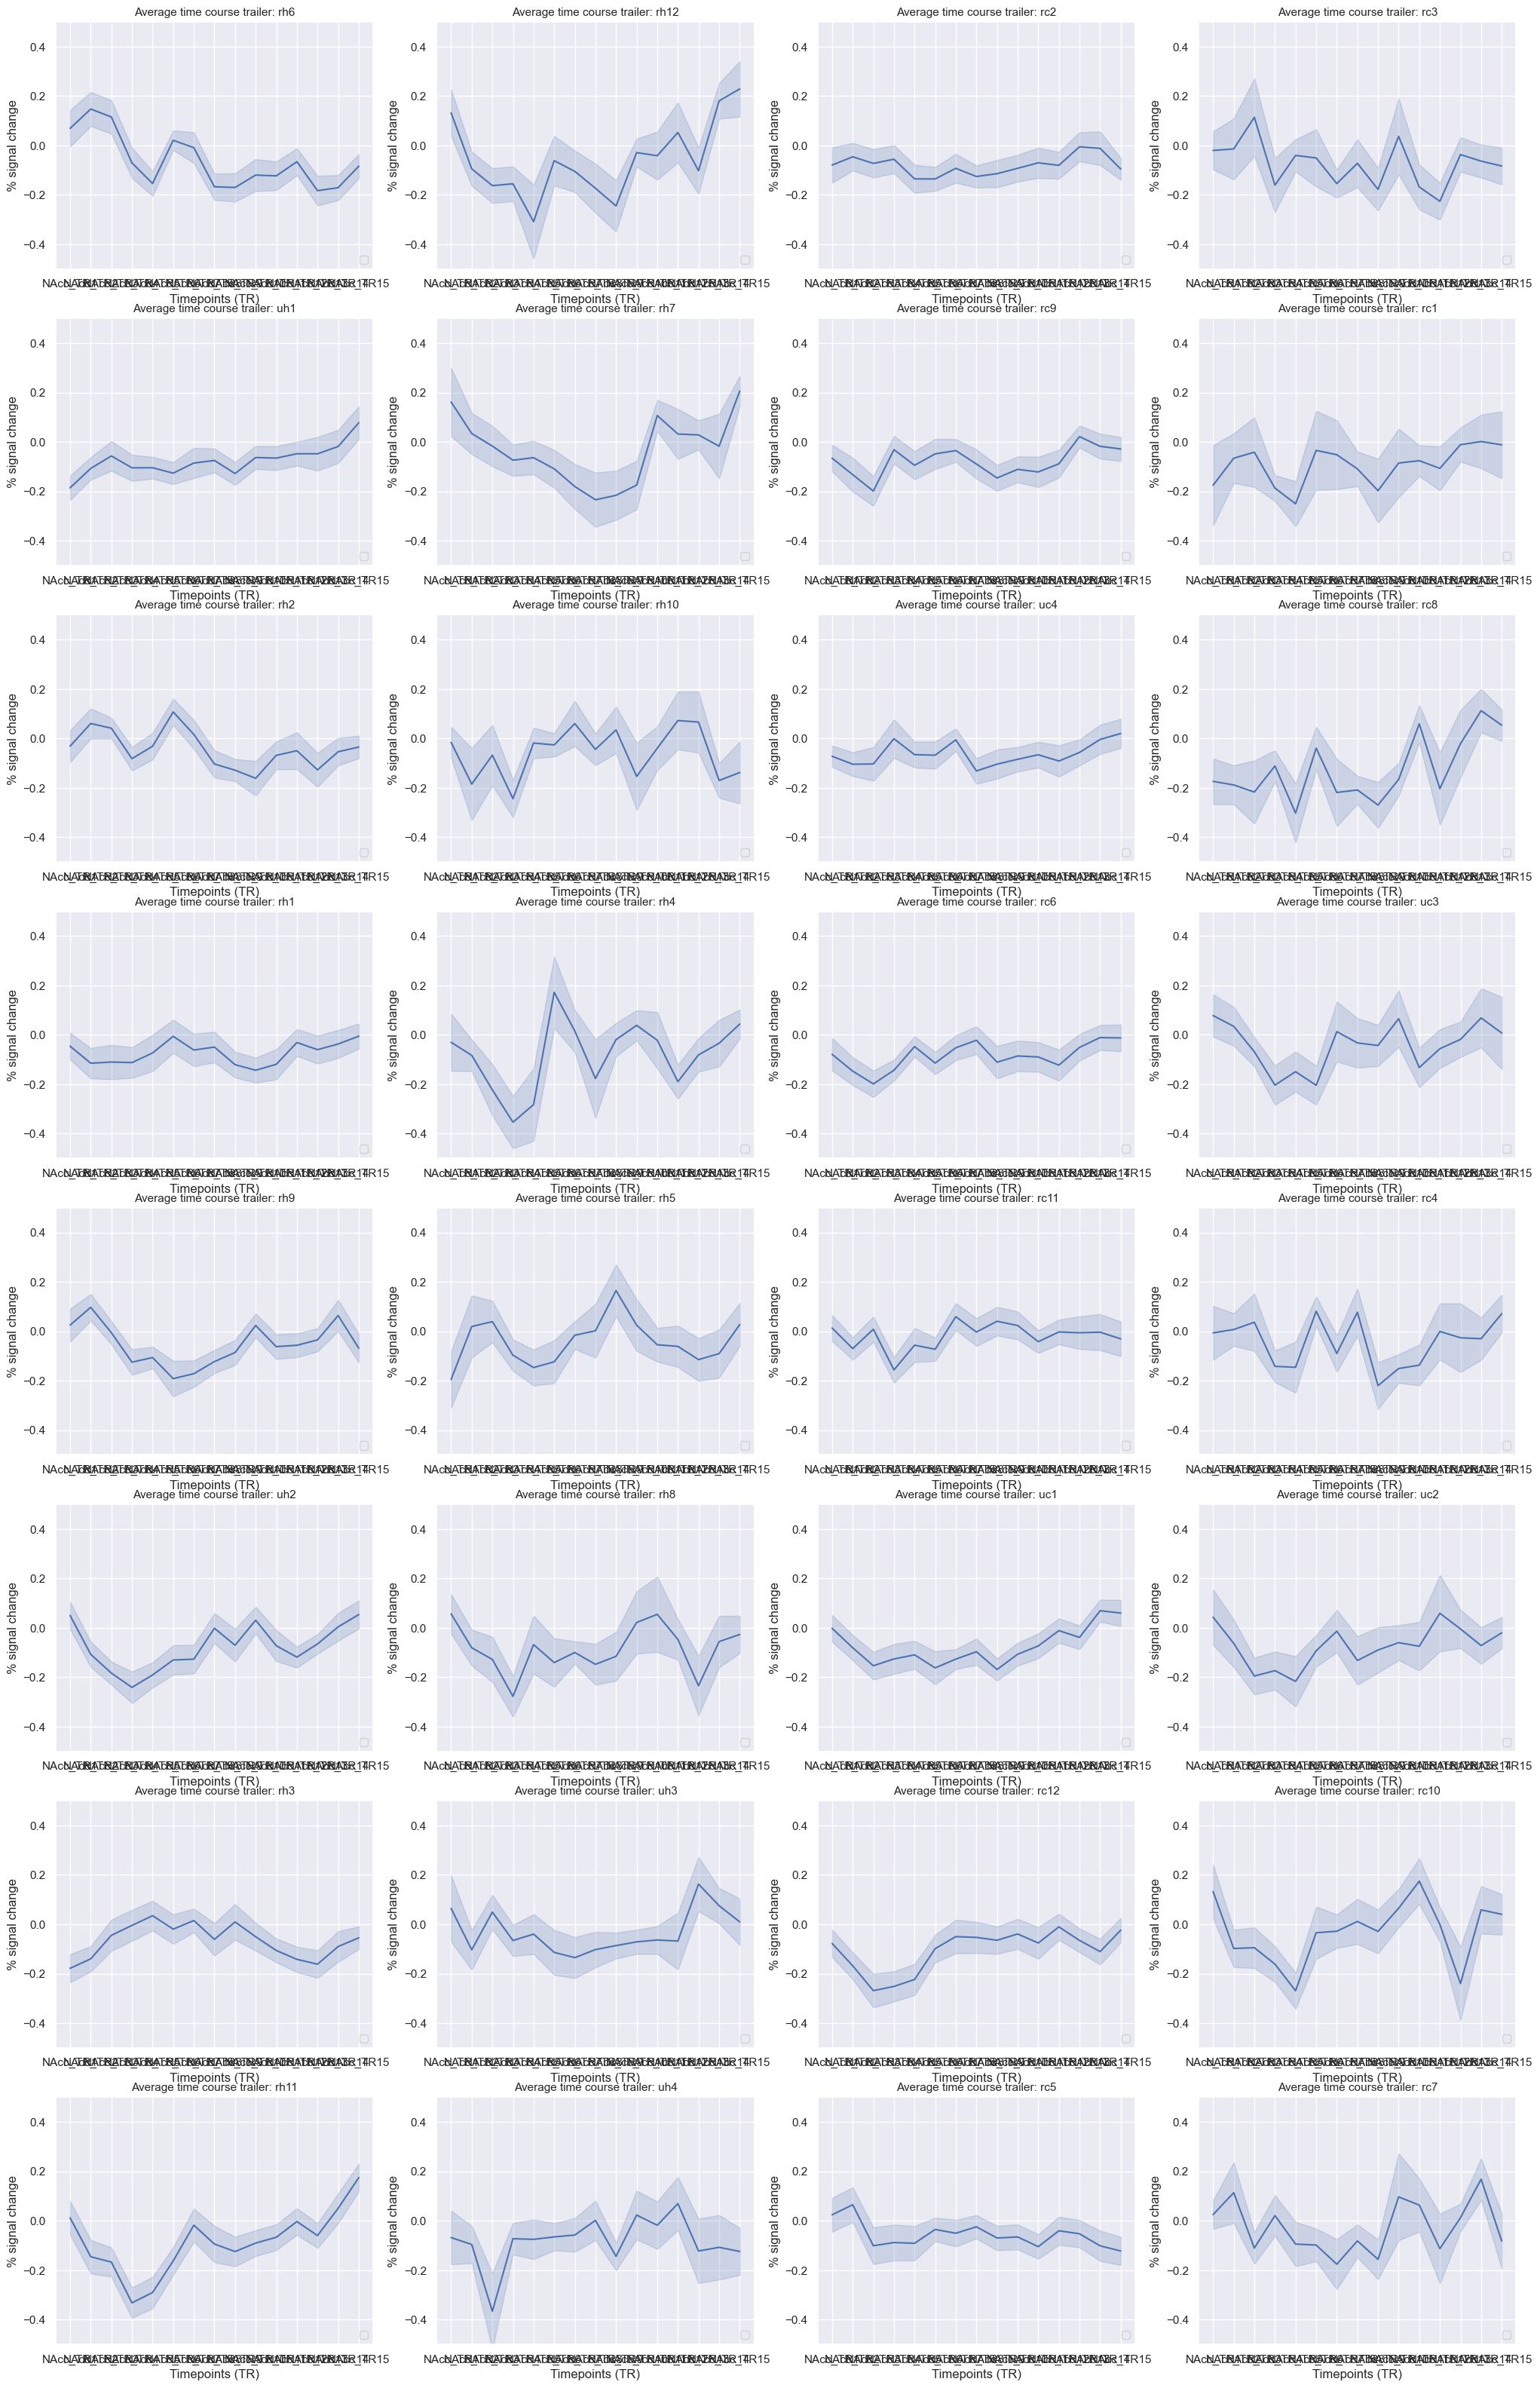

In [62]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=NAcc_long_df[NAcc_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal",  ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.5, .5)
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 0])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 0])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 0])

    sns.lineplot(data=NAcc_long_df[NAcc_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.5, .5)
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 1])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 1])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=NAcc_long_df[NAcc_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.5, .5)
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 2])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 2])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 2])

    sns.lineplot(data=NAcc_long_df[NAcc_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.5, .5)
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 3])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 3])
    #plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

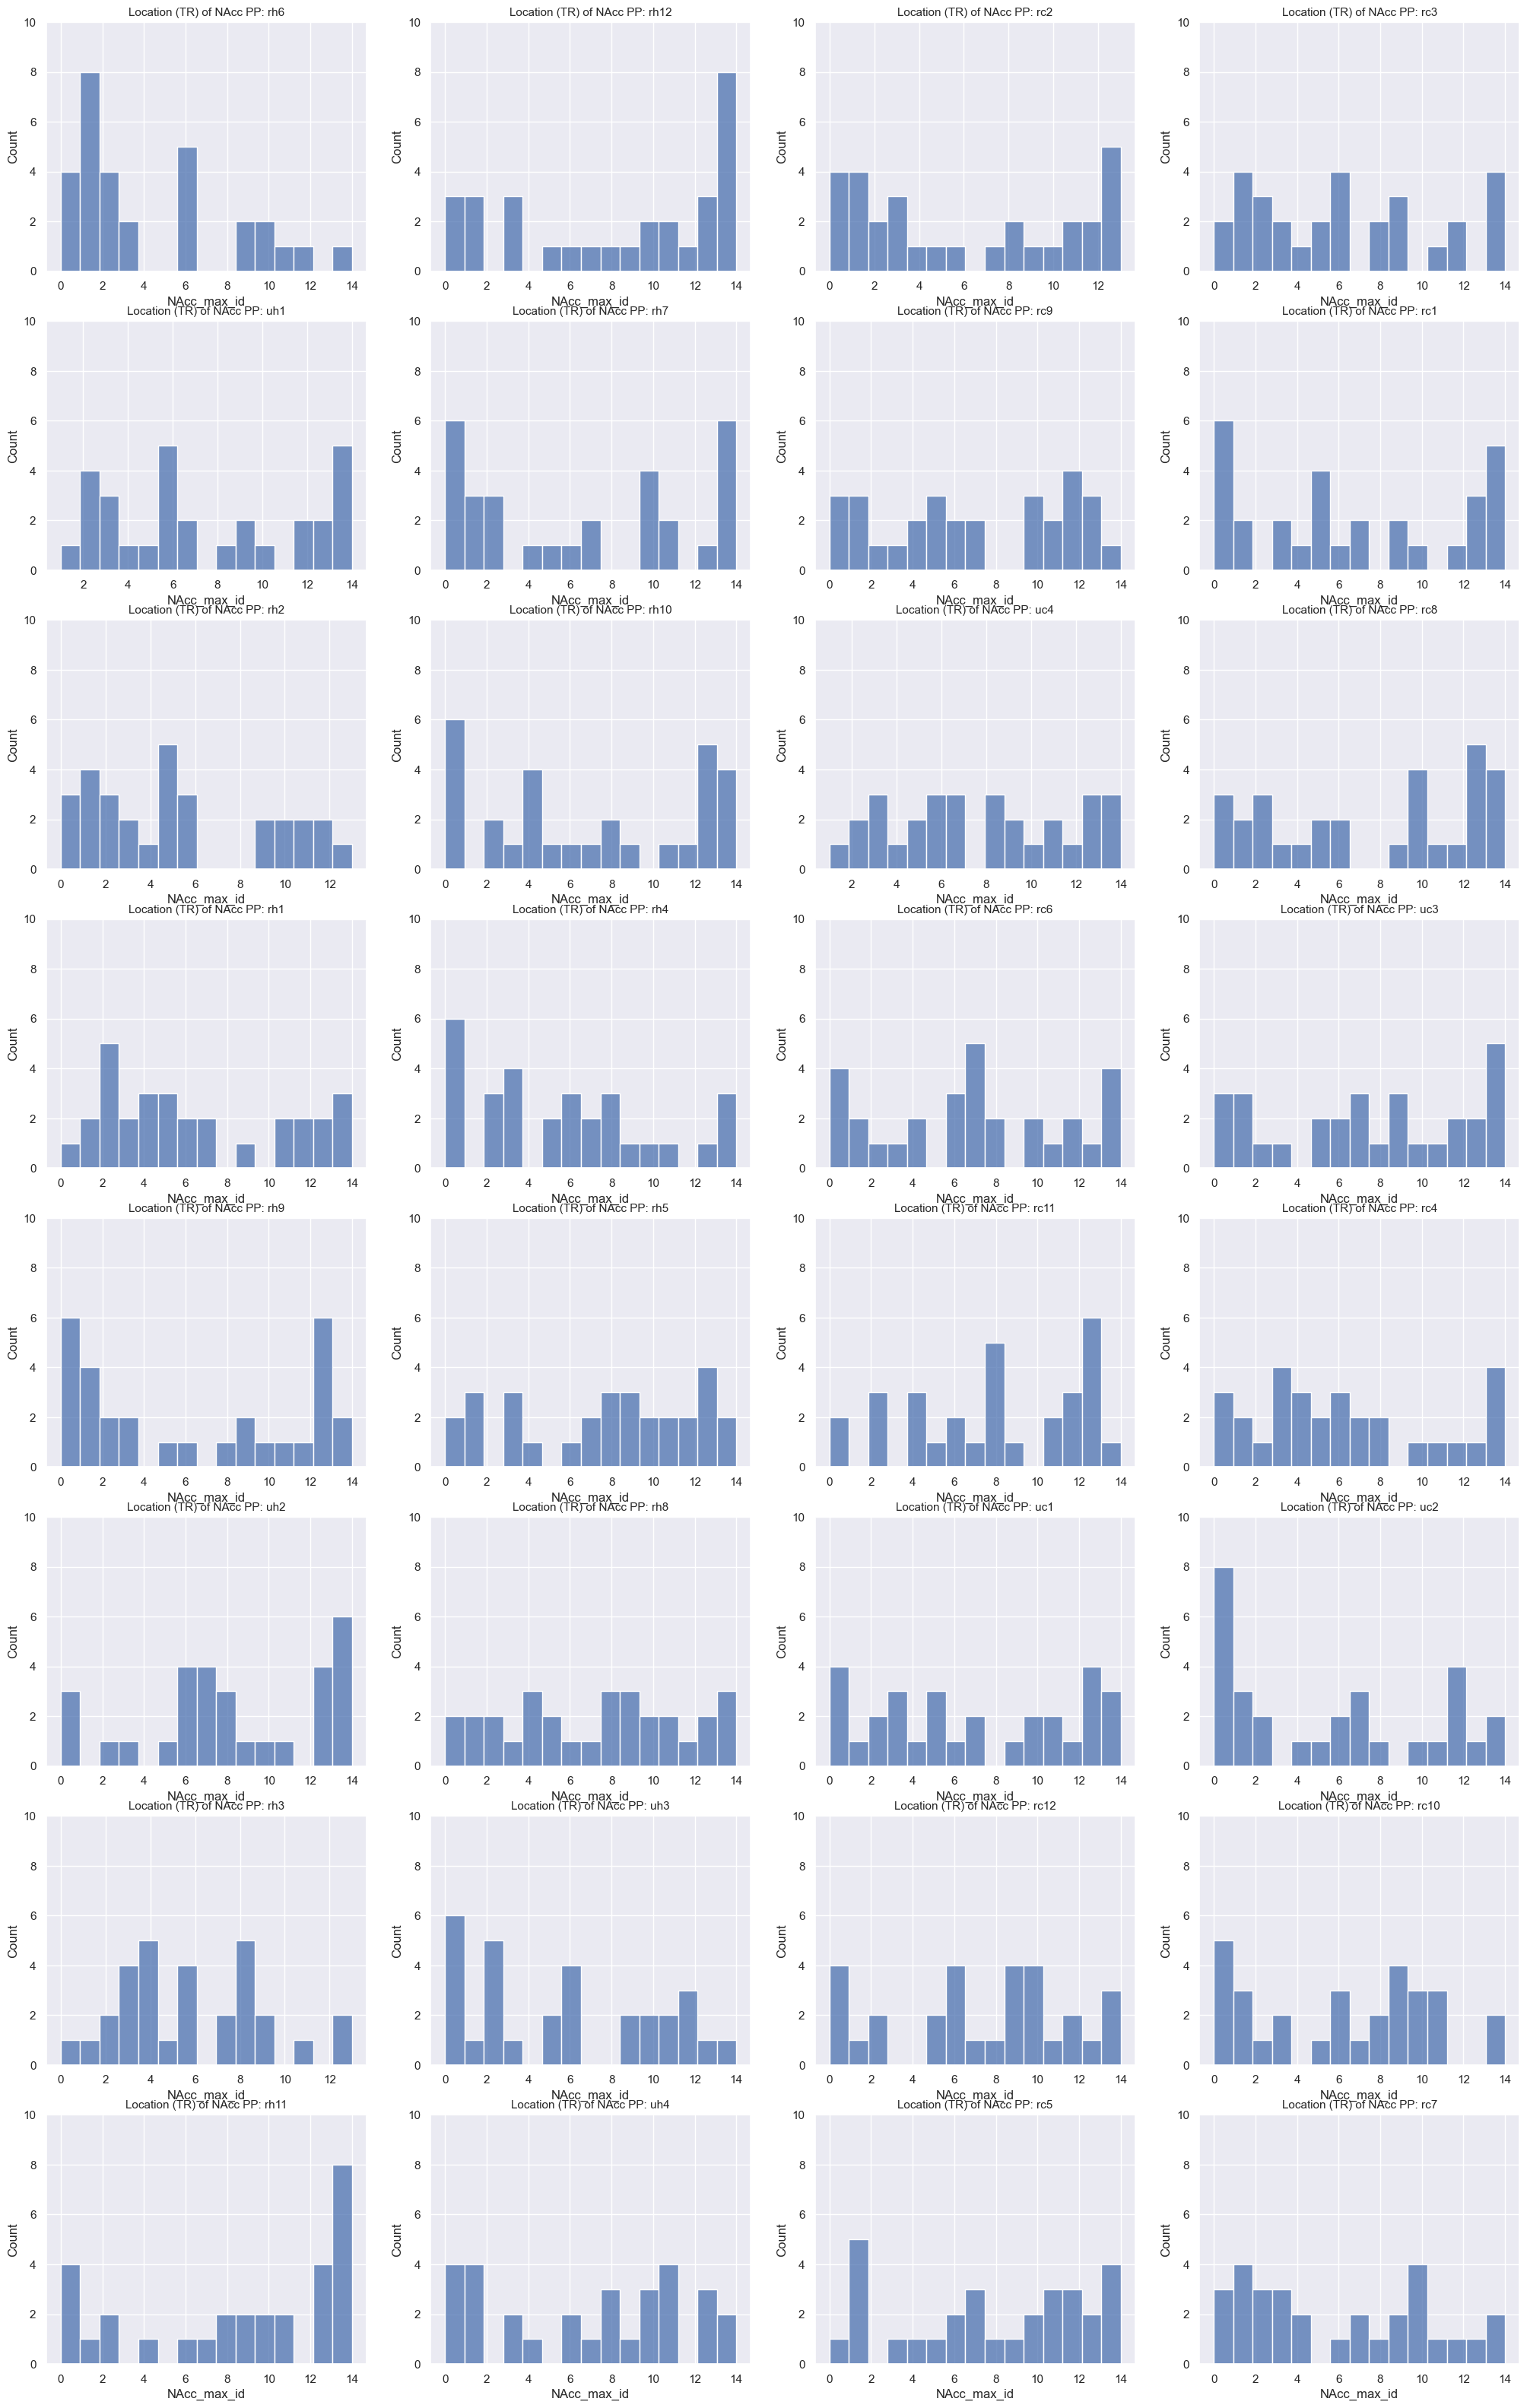

In [63]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0 

for id in range(8):

    sns.histplot(data=all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Trailer"] == r1_keys_sorted[runner]],
                x="NAcc_max_id",  ax=axs[id, 0], bins=15) #hue="Watch_choice", palette=dict(Yes="blue", No="red"),
    axs[id, 0].set_title("Location (TR) of NAcc PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylim(0, 10)

    sns.histplot(data=all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Trailer"] == r2_keys_sorted[runner]],
                x="NAcc_max_id", ax=axs[id, 1], bins=15) # hue="Watch_choice", palette=dict(Yes="blue", No="red"),
    axs[id, 1].set_title("Location (TR) of NAcc PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylim(0, 10)
    runner +=1

    sns.histplot(data=all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Trailer"] == r1_keys_sorted[runner]],
            x="NAcc_max_id", ax=axs[id, 2], bins=15) #, hue="Watch_choice", palette=dict(Yes="blue", No="red"),
    axs[id, 2].set_title("Location (TR) of NAcc PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylim(0, 10)

    sns.histplot(data=all_participants_proccessed_peaks_df[all_participants_proccessed_peaks_df["Trailer"] == r2_keys_sorted[runner]],
                x="NAcc_max_id", ax=axs[id, 3], bins=15) # hue="Watch_choice", palette=dict(Yes="blue", No="red"),
    axs[id, 3].set_title("Location (TR) of NAcc PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylim(0, 10)
    runner +=1
    
